In [799]:
import pandas as pd
import numpy as np
import requests
from pprint import pprint
from math import ceil
import copy
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import ast
import json

In [299]:
pd.set_option('display.float_format', '{:.0f}'.format)

# Guidelines (DON'T edit on 2 files at once)

1. Common Tables
- For canonical data/unified app data, use "df_game_full_info"
- For app info (aka local app info), use "df_all_app_info_list"
- For mapping unified_app_id : list of local apps, use "list_of_dicts_game_app_list"
- For flattened version of mapping unified_app_id : list of local apps, use "list_of_dicts_game_app_list_flattened"
- For mapping publisher_id : revenue_multiplier, use "dict_publisher_id_revenue_multiplier"
- For full-info table of apps requiring rev adjustment: "df_app_requiring_rev_adjustment"
- For list of app ids requiring rev adjustment: "list_app_id_requiring_rev_adjustment"
- For list of game ids (unified ids) requiring rev adjustment: "list_game_ids_requiring_rev_adjustment"

# API Credentials

In [5]:
api_key = 'ST0_ejEo8DwM_vCjQJzNhPbpmhQ'
base_url = 'https://api.sensortower.com'

# using authentication token from chi Tram's account

# Supporting Functions

In [6]:
def chunk_list(lst, chunk_size):
    """
    Splits a list into chunks of specified size.
    
    Parameters:
        lst (list): The list to split.
        chunk_size (int): The maximum size of each chunk.
        
    Returns:
        generator: A generator that yields chunks of the list.
    """
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

In [7]:
def parse_string_to_list(input_string):
    """
    Converts a string representation of a list into an actual Python list.

    Args:
        input_string (str): The input string representing a list, e.g., 
                            "['US', 'AU', 'CA']".

    Returns:
        list: A Python list parsed from the input string.
    """
    # Use eval to safely parse the string into a list
    try:
        result = eval(input_string)
        if isinstance(result, list):
            return result
        else:
            raise ValueError("Input string does not represent a valid list.")
    except Exception as e:
        raise ValueError(f"Failed to parse input string: {e}")

In [8]:
def string_to_timestamp(date_string):
    """
    Converts an ISO 8601 date string into a Unix timestamp.
    
    Args:
        date_string (str): The date string in ISO 8601 format, e.g., "2010-05-29T00:00:00Z".
    
    Returns:
        int: The Unix timestamp (seconds since epoch).
    """
    # Parse the date string to a datetime object
    dt = datetime.strptime(date_string, "%Y-%m-%dT%H:%M:%SZ")
    
    # Convert to a timestamp
    return int(dt.timestamp())

In [9]:
def string_to_timestamp_v2(date_string):
    """
    Converts a date string in 'YYYY/MM/DD' format into a Unix timestamp.
    
    Args:
        date_string (str): The date string in 'YYYY/MM/DD' format, e.g., "2013/02/25".
    
    Returns:
        int: The Unix timestamp (seconds since epoch).
    """
    # Parse the date string to a datetime object
    dt = datetime.strptime(date_string, "%Y/%m/%d")
    
    # Convert to a timestamp
    return int(dt.timestamp())

In [10]:
def timestamp_to_string(timestamp):
    """
    Converts a Unix timestamp into a date string in 'YYYY/MM/DD' format.
    
    Args:
        timestamp (int): The Unix timestamp to convert.
    
    Returns:
        str: The formatted date string, e.g., "2013/02/25".
    """
    # Convert the timestamp to a datetime object
    dt = datetime.fromtimestamp(timestamp)
    
    # Format the datetime object as a string
    date_string = dt.strftime("%Y/%m/%d")
    
    return date_string

In [11]:
def add_days_to_date(date_str, days_to_add):
    """
    Adds a certain number of days to a given date string.

    Args:
        date_str (str): The input date string in the format "YYYY-MM-DD".
        days_to_add (int): The number of days to add.

    Returns:
        str: The resulting date string in the format "YYYY-MM-DD".
    """
    # Parse the input date string to a datetime object
    date_obj = datetime.strptime(date_str, "%Y-%m-%d")
    # Add the specified number of days
    new_date_obj = date_obj + timedelta(days=days_to_add)
    # Convert back to a string and return
    return new_date_obj.strftime("%Y-%m-%d")

In [12]:
def get_unified_app_data(api_key, base_url, app_ids):
    """
    Fetch unified app data from the SensorTower API in batches of 100 IDs per request.
    
    Parameters:
        api_key (str): Your SensorTower API key.
        base_url (str): The base URL for the API.
        app_ids (list[str]): List of unified app IDs to fetch.
        
    Returns:
        list[dict]: Combined response data from all requests.
    """
    
    # API endpoint
    endpoint = "/v1/unified/apps"
    url = f"{base_url}{endpoint}"
    
    headers = {
        'Authorization': f'Bearer {api_key}'
    }
    
    all_responses = []
    chunk_size = 100
    count = 1
    
    # Split the list of app_ids into chunks of 100
    for app_id_chunk in chunk_list(app_ids, chunk_size):
        params = {
            'app_id_type': 'unified',
            'app_ids': ','.join(app_id_chunk)
        }
        
        print('making call for chunk number {}'.format(count))
        
        # Make the API request for this chunk
        response = requests.get(url, headers=headers, params=params)
        
        if response.status_code == 200:
            print('call successful!')
            all_responses.extend(response.json().get('apps', []))
        else:
            print(f"Request failed with status code {response.status_code}: {response.text}")
        
        count += 1
    
    return all_responses

In [13]:
def get_required_tags(api_key, base_url, app_ids):


    # API endpoint
    endpoint = "/v1/app_tag/tags_for_apps"
    url = f"{base_url}{endpoint}"

    headers = {
        'Authorization': f'Bearer {api_key}'
    }
    
    
    all_responses = []
    chunk_size = 100
    count = 1
    
    # Split the list of app_ids into chunks of 100
    for app_id_chunk in chunk_list(app_ids, chunk_size):
        # params = {
        #     'app_ids': 'eu.nordeus.topeleven.android',
        #     'field_categories[]':'gaming',  
        #     'field_categories[]':'release_info',  
        # }

        # params = {
        #     'app_ids': 'eu.nordeus.topeleven.android',
        #     'field_categories[]':['gaming', 'release_info']  
        # }

        params = {
            'app_ids': ','.join(app_id_chunk),
            'fields[]':['Game Class', 
                        'Game Genre', 
                        'Game Sub-genre',
                        'Game Art Style',
                        'Game Camera POV',
                        'Game Setting',
                        'Game Theme',
                        'Game Product Model',
                        'IP: Corporate Parent',
                        'IP: IP Operator',
                        'IP: Media Type',
                        'IP: Licensed IP',
                        'Earliest Release Date',
                        'Release Date (WW)',
                        'Release Date (US)',
                        'Release Date (JP)',
                        'Release Date (CN)'
                       ]  
        }
        
        print('making call for chunk number {}'.format(count))
        
        # Make the API request for this chunk
        response = requests.get(url, headers=headers, params=params)
        
        if response.status_code == 200:
            print('call successful!')
            all_responses.extend(response.json().get('data', []))
        else:
            print(f"Request failed with status code {response.status_code}: {response.text}")
        
        count += 1
    
    return all_responses

In [14]:
def find_row_cell_value(row_name, tag_list):
    try:
        return list(filter(lambda x: x['name'] == row_name, tag_list))[0]['exact_value']
    except:
        return None

In [15]:
def get_tags_table(tags_data):
    
    tags_table = []

    for raw_row in tags_data:

        current_tag_list = raw_row['tags']

        new_row = dict()
        new_row['canonical_app_id'] = raw_row['app_id']
        new_row['game_class'] = find_row_cell_value('Game Class', current_tag_list)
        new_row['game_genre'] = find_row_cell_value('Game Genre', current_tag_list)
        new_row['game_subgenre'] = find_row_cell_value('Game Sub-genre', current_tag_list)
        new_row['game_art_style'] = find_row_cell_value('Game Art Style', current_tag_list)
        new_row['game_camera_pov'] = find_row_cell_value('Game Camera POV', current_tag_list)
        new_row['game_setting'] = find_row_cell_value('Game Setting', current_tag_list)
        new_row['game_theme'] = find_row_cell_value('Game Theme', current_tag_list)
        new_row['game_product_model'] = find_row_cell_value('Game Product Model', current_tag_list)
        new_row['game_ip_corporate_parent'] = find_row_cell_value('IP: Corporate Parent', current_tag_list)
        new_row['game_ip_operator'] = find_row_cell_value('IP: IP Operator', current_tag_list)
        new_row['game_ip_media_type'] = find_row_cell_value('IP: Media Type', current_tag_list)
        new_row['game_licensed_ip'] = find_row_cell_value('IP: Licensed IP', current_tag_list)
        new_row['game_earliest_release_date'] = find_row_cell_value('Earliest Release Date', current_tag_list)
        new_row['game_release_date_ww'] = find_row_cell_value('Release Date (WW)', current_tag_list)
        new_row['game_release_date_us'] = find_row_cell_value('Release Date (US)', current_tag_list)
        new_row['game_release_date_jp'] = find_row_cell_value('Release Date (JP)', current_tag_list)
        new_row['game_release_date_cn'] = find_row_cell_value('Release Date (CN)', current_tag_list) 
        tags_table.append(new_row)
    
    return tags_table

In [16]:
def extract_app_ids(list_of_dict):
    return list(map(lambda d: d['app_id'], list_of_dict))

In [17]:
def get_app_id_lists(unified_app_data):
#     also known as canonical data, cuz it also contains canonical id thingy
    itunes_app_id_list = []
    android_app_id_list = []
    
    for app in unified_app_data:
        current_app_itunes_app_ids = app['itunes_apps']
        current_app_android_app_ids = app['android_apps']
        itunes_app_id_list.extend(extract_app_ids(current_app_itunes_app_ids))
        android_app_id_list.extend(extract_app_ids(current_app_android_app_ids))
    
#     ios app id list needs to be adjusted (but not for android app id list)
    itunes_app_id_list_adjusted = list(map(lambda x: str(x),itunes_app_id_list))
    
    result_list = []
    
    for app_id in itunes_app_id_list_adjusted:
        result_list.append(
            {
                'os':'ios',
                'app_id':app_id
            }
        
        )

    for app_id in android_app_id_list:
        result_list.append(
            {
                'os':'android',
                'app_id':app_id
            }
        
        )
    
    return result_list

In [18]:
def get_local_app_info(api_key, base_url, os, app_ids):
    
    # API endpoint
    endpoint = "/v1/{}/apps".format(os)
    url = f"{base_url}{endpoint}"
    
    headers = {
        'Authorization': f'Bearer {api_key}'
    }
    
    all_responses = []
    chunk_size = 100
    count = 1
    
    # Split the list of app_ids into chunks of 100
    for app_id_chunk in chunk_list(app_ids, chunk_size):
        params = {
            'app_ids': ','.join(app_id_chunk)
        }
        
        print('making call for chunk number {}'.format(count))
        
        # Make the API request for this chunk
        response = requests.get(url, headers=headers, params=params)
        
        if response.status_code == 200:
            print('call successful!')
            all_responses.extend(response.json().get('apps', []))
        else:
            print(f"Request failed with status code {response.status_code}: {response.text}")
        
        count += 1
    
    return all_responses

In [19]:
def get_unified_id(local_app_id):
    return list(filter(lambda x: x['app_id'] == local_app_id, local_id_to_unified_id_mapping))[0]['unified_app_id']

In [20]:
def get_apps_performance(api_key, base_url, os, app_ids, country_code, granularity, max_periods, start_date, end_date):
    
    def split_date_range(start_date, end_date, granularity, max_periods):
        
        current_start = datetime.strptime(start_date, '%Y-%m-%d')
        final_end = datetime.strptime(end_date, '%Y-%m-%d')
        date_ranges = []
        
        day_count_per_granularity = {
            'daily': 1,
            'weekly': 7,
            'monthly': 30,
            'quarterly': 91
        }

        while current_start < final_end:
            
            # Calculate the end date for the current range
            current_end = current_start + timedelta(days=max_periods * day_count_per_granularity[granularity])
            # Ensure current_end does not exceed final_end
            current_end = min(current_end, final_end)
            
            if granularity == 'daily':
                date_ranges.append((current_start.strftime('%Y-%m-%d'), current_end.strftime('%Y-%m-%d')))
                current_start = current_end + timedelta(days=1)
            elif granularity == 'weekly':
                current_end = current_end + timedelta(days=(6 - current_end.weekday()))
                date_ranges.append((current_start.strftime('%Y-%m-%d'), current_end.strftime('%Y-%m-%d')))
                current_start = current_end + timedelta(days=1)
            elif granularity == 'monthly':
                current_end = (current_end.replace(day=1) + timedelta(days=32)).replace(day=1) - timedelta(days=1)
                date_ranges.append((current_start.strftime('%Y-%m-%d'), current_end.strftime('%Y-%m-%d')))
                current_start = (current_end + timedelta(days=1)).replace(day=1)
            elif granularity == 'quarterly':
                # Move current_end to the last day of the quarter
                quarter = (current_end.month - 1) // 3 + 1  # Calculate current quarter (1, 2, 3, or 4)
                next_quarter_start_month = quarter * 3 + 1  # Month of the next quarter's first day
                if next_quarter_start_month > 12:
                    next_quarter_start = current_end.replace(year=current_end.year + 1, month=1, day=1)
                else:
                    next_quarter_start = current_end.replace(month=next_quarter_start_month, day=1)
                current_end = next_quarter_start - timedelta(days=1)  # Move to the last day of the current quarter
                date_ranges.append((current_start.strftime('%Y-%m-%d'), current_end.strftime('%Y-%m-%d')))
                current_start = (current_end + timedelta(days=1)).replace(day=1)
#                 print('current_start: {}'.format(current_start))

        return date_ranges

    
    # API endpoint   
    endpoint = "/v1/{}/sales_report_estimates".format(os)
    url = f"{base_url}{endpoint}"
    headers = {
        'Authorization': f'Bearer {api_key}'
    }
    
    date_ranges = split_date_range(start_date, end_date, granularity, max_periods)
    print("Date ranges: {}".format(date_ranges))
    
    all_results = []
    chunk_size = 100

    for start, end in date_ranges:
        
        print("Requesting Data for Range:", start, "to", end)
        count = 1
        
        # Split the list of app_ids into chunks of 100
        for app_id_chunk in chunk_list(app_ids, chunk_size):

            params = {
                'os': os,
                'app_ids': ','.join(app_id_chunk),
                'countries': country_code,
                'date_granularity': granularity,
                'start_date': start,
                'end_date': end,
            }

            print('making call for chunk number {}'.format(count))

            request = requests.Request("GET", url, headers=headers, params=params)
            prepared_request = request.prepare()

            response = requests.get(url, headers=headers, params=params)

            if response.status_code == 200:
                print(f"Data retrieved for {start} to {end}")
                json_data = response.json()
                if isinstance(json_data, list):  # If the response is a list
                    all_results.extend(json_data)
                elif isinstance(json_data, dict):  # If the response is a dictionary
                    all_results.extend(json_data.get('data', []))
                else:
                    print(f"Unexpected response format for {start} to {end}: {json_data}")
            else:
                print(f"Failed for {start} to {end}. Status Code: {response.status_code}")
                print(response.text)

            count += 1
        
    return all_results 

In [21]:
def get_monthly_app_performance_single_app_id(api_key, base_url, os, app_id, country_code, start_date, end_date):
    """
    Query monthly app performance data in 12-month segments if the range exceeds 12 months.
    """
    
    def split_date_range(start_date, end_date, max_months=12):
        """
        Split a date range into non-overlapping segments of up to `max_months` months.
        """
        current_start = datetime.strptime(start_date, '%Y-%m-%d')
        final_end = datetime.strptime(end_date, '%Y-%m-%d')
        date_ranges = []

        while current_start < final_end:
            # Calculate the end date for the current range
            current_end = current_start + timedelta(days=max_months * 30)  # Approximate 12 months
            # Ensure current_end does not exceed final_end
            current_end = min(current_end, final_end)
            # Adjust current_end to the last day of the month
            current_end = (current_end.replace(day=1) + timedelta(days=32)).replace(day=1) - timedelta(days=1)

            # Add the range to the list
            date_ranges.append((current_start.strftime('%Y-%m-%d'), current_end.strftime('%Y-%m-%d')))

            # Move current_start to the first day of the next month after current_end
            current_start = (current_end + timedelta(days=1)).replace(day=1)

        return date_ranges
    
    print("Getting performance data for app id {}".format(app_id))

    endpoint = "/v1/{}/sales_report_estimates".format(os)
    url = f"{base_url}{endpoint}"

    headers = {
        'Authorization': f'Bearer {api_key}'
    }

    date_ranges = split_date_range(start_date, end_date)
    
#     print("Date Ranges")
#     print(date_ranges)
    
    
    all_results = []

    for start, end in date_ranges:
        params = {
            'os': os,
            'app_ids': app_id,
            'countries': country_code,
            'date_granularity': 'monthly',
            'start_date': start,
            'end_date': end,
        }

        request = requests.Request("GET", url, headers=headers, params=params)
        prepared_request = request.prepare()

#         print("Requesting Data for Range:", start, "to", end)
#         print("Full Request URL:", prepared_request.url)

        response = requests.get(url, headers=headers, params=params)

        if response.status_code == 200:
            print(f"Data retrieved for {start} to {end}")
            json_data = response.json()
            if isinstance(json_data, list):  # If the response is a list
                all_results.extend(json_data)
            elif isinstance(json_data, dict):  # If the response is a dictionary
                all_results.extend(json_data.get('data', []))
            else:
                print(f"Unexpected response format for {start} to {end}: {json_data}")
        else:
            print(f"Failed for {start} to {end}. Status Code: {response.status_code}")
            print(response.text)
    
    return all_results

In [22]:
def get_performance_streams_from_list_of_app_ids(api_key, base_url, country_code, start_date, end_date, list_app_ids):
#     currently only get monthly performance
    result = []
    
    for app in list_app_ids:
        os = app["os"]
        app_id = app["app_id"]
        app_performance = get_monthly_app_performance_single_app_id(
            api_key, 
            base_url, 
            os, 
            app_id, 
            country_code,
            start_date, 
            end_date
        )
        result.append(
            {
                'app_id': app_id,
                'os': os,
                'app_performance': app_performance
            }
        )

    return result

In [23]:
def get_unique_dates(performance_streams_data):
    result = []
    for app in performance_streams_data:
        for record in app['app_performance']:
            if not(record['d'] in result):
                result.append(record['d'])
    return sorted(result)

In [24]:
def get_app_ids_from_performance_stream_data(performance_stream_data):
    return list(map(lambda x: x['app_id'], performance_stream_data))

In [25]:
def fill_performance_streams_df(blank_df, performance_streams_data):
    for row in performance_streams_data:
        if row['os'] == 'ios':
            for record in row['app_performance']:
                revenue_ar = record['ar']/100 if 'ar' in record else 0
                revenue_ir = record['ir']/100 if 'ir' in record else 0
                blank_df.at[row['app_id'], record['d']] = revenue_ar + revenue_ir
        elif row['os'] == 'android':
            for record in row['app_performance']:        
                blank_df.at[row['app_id'], record['d']] = record['r']/100 if 'r' in record else 0
    return blank_df

In [26]:
def generate_performance_streams_df(performance_streams_data):
#     prepare blank dataframe
    unique_dates = get_unique_dates(performance_streams_data)
    app_ids = get_app_ids_from_performance_stream_data(performance_streams_data)
    df = pd.DataFrame(index=app_ids, columns=unique_dates)
    
# fill the data
    return fill_performance_streams_df(df, performance_streams_data)

In [27]:
def get_daily_app_performance_single_unified_id(api_key, base_url, unified_id, country_code, start_date, end_date):
    """
    Fetch unified app data from the SensorTower API in batches of 100 IDs per request.
    
    Parameters:
        api_key (str): Your SensorTower API key.
        base_url (str): The base URL for the API.
        app_ids (list[str]): List of unified app IDs to fetch.
        
    Returns:
        list[dict]: Combined response data from all requests.
    """
    
    # API endpoint
    endpoint = "/v1/unified/sales_report_estimates"
    url = f"{base_url}{endpoint}"
    
    headers = {
        'Authorization': f'Bearer {api_key}'
    }

    params = {
        'app_ids': unified_id,
        'countries': country_code,
        'date_granularity': 'daily',
        'start_date': start_date,
        'end_date': end_date,
    }
    
    response = requests.get(url, headers=headers, params=params)
    
    return response.json()

In [28]:
def calc_download_revenue_sum_from_sales_report_estimates(sales_report):
    unified_id = sales_report[0]['app_id']
    start_date = sales_report[0]['date']
    end_date = sales_report[-1]['date']
    
    download_sum = 0
    revenue_sum = 0
    for row in sales_report:
        download_sum = download_sum + row['unified_units']
        revenue_sum = revenue_sum + row['unified_revenue']
    return {
        'unified_id': unified_id,
        'start_date': start_date,
        'end_date': end_date,
        'download': download_sum,
        'revenue': revenue_sum/100
    }

In [29]:
def get_first_n_day_sum_performance_single_unified_id(api_key, base_url, unified_id, country_code, release_date, n):

    query_result = get_daily_app_performance_single_unified_id(
        api_key = api_key, 
        base_url = base_url, 
        unified_id = unified_id, 
        country_code = country_code, 
        start_date = release_date, 
        end_date = add_days_to_date(start_date, n)
    )
    
    print(query_result)
    
    return calc_download_revenue_sum_from_sales_report_estimates(query_result)

In [30]:
def transform_df_local_app_info_to_dict_unified_id_local_app_info(df_local_app_info):
    table_app_ids = df_local_app_info.to_dict(orient='records')
    
    # get the list of unique unified_ids
    set_unified_ids = set(map(lambda x: x['unified_app_id'], table_app_ids))
    
    # Initiate the data structure unified_id: list of app of id info
    dict_unified_id_app_ids = dict()    
    
    for unified_id in set_unified_ids:
        dict_unified_id_app_ids[unified_id] = list(filter(lambda x: x['unified_app_id'] == unified_id, table_app_ids))
    
    return dict_unified_id_app_ids

In [31]:
def filter_vn_app_id(app_id_list):
    result = []
    for app in app_id_list:
        if 'VN' in parse_string_to_list(app['valid_countries']) or 'VN' in parse_string_to_list(app['top_countries']):
            result.append(app)
    return result

In [33]:
def get_top_games_by_year(df, percentile):
    """
    Get top games (Unified ID) contributing 90% of total revenue for each year.
    
    Args:
        df (DataFrame): Input DataFrame containing game performance data.
    
    Returns:
        dict: Dictionary with years as keys and lists of Unified IDs as values.
    """
    # Ensure the 'Date' column is datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Extract the year from the 'Date' column
    df['Year'] = df['Date'].dt.year

    # Initialize result dictionary
    top_games_by_year = {}

    # Iterate through each year in the dataset
    for year, group in df.groupby('Year'):
        # Total revenue for the year
        total_revenue = group['Revenue (Absolute, $)'].sum()

        # Sort by revenue in descending order
        group = group.sort_values(by='Revenue (Absolute, $)', ascending=False)

        # Calculate cumulative revenue and cumulative percentage
        group['Cumulative Revenue'] = group['Revenue (Absolute, $)'].cumsum()
        group['Cumulative %'] = group['Cumulative Revenue'] / total_revenue

        # Get the IDs that contribute up to <percentile>% of the revenue
        top_ids = group.loc[group['Cumulative %'] <= percentile, 'Unified ID'].tolist()

        # Store the result for the year
        top_games_by_year[year] = top_ids

    return top_games_by_year

In [34]:
def extract_all_values(dictionary):
    """
    Extract all values from a dictionary into a single list.
    
    Args:
        dictionary (dict): Input dictionary with values being lists.
    
    Returns:
        list: A list containing all values across all keys.
    """
    return [value for values in dictionary.values() for value in values]

In [35]:
# A function that takes in the set of unified_id 
# then output the full-info table of those unified_id (canonical, game tags and stuff)

def retrieve_full_info_game_table(api_key, base_url, set_unified_ids):
    
    print("Get canonical app data...")
    
    canonical_app_data = get_unified_app_data(
        api_key = api_key, 
        base_url = base_url, 
        app_ids = list(set_unified_ids)
    )
    
    df_canonical_app_data = pd.DataFrame(canonical_app_data)
    
    canonical_id_list = list(df_canonical_app_data['canonical_app_id'])
    
    canonical_id_list_fixed = [str(item) for item in canonical_id_list]
    
    print("Get game tags...")
    
    tags_data = get_required_tags(
        api_key, 
        base_url, 
        canonical_id_list_fixed
    )
    
    
    
    tags_table = get_tags_table(tags_data)
    
    df_tags_table = pd.DataFrame(tags_table)
    
    df_game_full_info = pd.merge(
        df_tags_table,
        df_canonical_app_data,
        how = 'left',
        on = 'canonical_app_id'
    )
    
    new_order = [
        'unified_app_id',
        'canonical_app_id',
        'name',
        'cohort_id',
        'itunes_apps',
        'android_apps',
        'unified_publisher_ids',
        'itunes_publisher_ids',
        'android_publisher_ids',
        'game_class',
        'game_genre',
        'game_subgenre',
        'game_art_style',
        'game_camera_pov',
        'game_setting',
        'game_theme',
        'game_product_model',
        'game_ip_corporate_parent',
        'game_ip_operator',
        'game_ip_media_type',
        'game_licensed_ip',
        'game_earliest_release_date',
        'game_release_date_ww',
        'game_release_date_us',
        'game_release_date_jp',
        'game_release_date_cn'
    ]
    
    return df_game_full_info[new_order]   

In [36]:
def compare_dataframes(df1, df2):
    """
    Compare two DataFrames cell by cell and record differences.

    Args:
        df1 (DataFrame): First DataFrame to compare.
        df2 (DataFrame): Second DataFrame to compare.

    Returns:
        list: A list of dictionaries containing the differences with details.
    """
    # Ensure both DataFrames have the same shape
    if df1.shape != df2.shape:
        raise ValueError("DataFrames do not have the same shape.")

    differences = []

    # Iterate over each cell in the DataFrame
    for row_idx in range(len(df1)):
        for col in df1.columns:
            if df1.at[row_idx, col] != df2.at[row_idx, col]:
                differences.append({
                    'Row': row_idx,
                    'Column': col,
                    'Value_df1': df1.at[row_idx, col],
                    'Value_df2': df2.at[row_idx, col]
                })
    
    return differences

In [37]:
def flatten_app_list_of_dicts(list_of_dict):
    result = []
    for item in list_of_dict:
        result.append(str(item['app_id']))
    return result

In [38]:
def plot_performance_streams_df(df_original):
    
    df = df_original.copy()
    
#     # Convert columns to datetime for proper handling
#     df.columns = pd.to_datetime(df.columns)

#     # Plot individual app revenue time series
#     plt.figure(figsize=(12, 6))
#     for app in df.index:
#         plt.plot(df.columns, df.loc[app], marker='o', label=f'{app}')
#         # Add data labels to each point
#         for x, y in zip(df.columns, df.loc[app]):
#             plt.annotate(f'{y}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center')

#     # Plot total revenue time series
#     total_revenue = df.sum(axis=0)
#     plt.plot(df.columns, total_revenue, marker='o', linestyle='--', color='black', label='Total Revenue')
#     # Add data labels for total revenue
#     for x, y in zip(df.columns, total_revenue):
#         plt.annotate(f'{y}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center')

#     # Customize the plot
#     plt.title('Revenue Trends of Individual Apps and Total Revenue')
#     plt.xlabel('Time')
#     plt.ylabel('Revenue')
#     plt.xticks(df.columns, rotation=45)
#     plt.legend()
#     plt.tight_layout()
#     plt.grid(True)

#     # Show the plot
#     plt.show()
    
    
    
    # Convert column names (quarters) to datetime
    df.columns = pd.to_datetime(df.columns)

    # Transpose for easier time-based plotting
    df_transposed = df.T

    # Plot each app's time series
    plt.figure(figsize=(12, 6))
    for app_id in df_transposed.columns:
        plt.plot(df_transposed.index, df_transposed[app_id], label=f'App: {app_id}')

    # Calculate and plot total revenue
    total_revenue = df_transposed.sum(axis=1)
    plt.plot(df_transposed.index, total_revenue, label='Total Revenue', color='black', linewidth=2, linestyle='--')

    # Add plot labels and legend
    plt.title('Revenue Time Series of Apps')
    plt.xlabel('Time')
    plt.ylabel('Revenue')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Show the plot
    plt.show()   

In [39]:
def plot_interactive_performance_streams_df(df_original):
    
    df = df_original.copy()
    
    # Create a Plotly Figure
    fig = go.Figure()

    # Add lines for individual apps
    for app in df.index:
        fig.add_trace(go.Scatter(
            x=df.columns, 
            y=df.loc[app], 
            mode='lines+markers', 
            name=f'{app}',
            text=df.loc[app],
            hovertemplate='App: %{name}<br>Date: %{x}<br>Revenue: %{y}<extra></extra>'
        ))

    # Add a line for total revenue
    total_revenue = df.sum(axis=0)
    fig.add_trace(go.Scatter(
        x=df.columns, 
        y=total_revenue, 
        mode='lines+markers', 
        name='Total Revenue',
        line=dict(dash='dot', color='black'),
        text=total_revenue,
        hovertemplate='Total Revenue<br>Date: %{x}<br>Revenue: %{y}<extra></extra>'
    ))

    # Customize layout
    fig.update_layout(
        title='Revenue Trends of Individual Apps and Total Revenue',
        xaxis_title='Time',
        yaxis_title='Revenue',
        xaxis=dict(rangeslider=dict(visible=True), type='date'),
        hovermode='x unified',
        template='plotly_white',
        legend=dict(title="Apps"),
    )

    # Show interactive plot
    fig.show()

In [321]:
def get_adjusted_yearly_revenue(revenue_df, app_info_df):
    
    def get_revenue_multiplier_of_app_id(app_id):
        return list(app_info_df[
            app_info_df[
                'app_id'].astype(str) == str(app_id)
        ]['revenue_multiplier'])[0]
    
    revenue_multiplier_vector = list(
        map(
            lambda x: get_revenue_multiplier_of_app_id(x),
            list(revenue_df.index)
        )
    )
    
    revenue_df_adjusted = revenue_df.mul(revenue_multiplier_vector, axis=0)
    
    revenue_df_adjusted_sum = revenue_df_adjusted.fillna(0).sum(axis=0)
    
    # Convert index to datetime
    revenue_df_adjusted_sum.index = pd.to_datetime(revenue_df_adjusted_sum.index)

    # Group by year and sum the revenue for each year
    yearly_revenue = revenue_df_adjusted_sum.resample('Y').sum()

    # Convert the index to year only
    yearly_revenue.index = yearly_revenue.index.year
    
    return yearly_revenue

In [322]:
def get_yearly_revenue_no_multiplier(revenue_df, app_info_df):
    
    revenue_df_sum = revenue_df.fillna(0).sum(axis=0)
    
    # Convert index to datetime
    revenue_df_sum.index = pd.to_datetime(revenue_df_sum.index)

    # Group by year and sum the revenue for each year
    yearly_revenue = revenue_df_sum.resample('Y').sum()

    # Convert the index to year only
    yearly_revenue.index = yearly_revenue.index.year
    
    return yearly_revenue

In [581]:
def get_adjusted_daily_revenue(revenue_df, app_info_df):
    
    def get_revenue_multiplier_of_app_id(app_id):
        return list(app_info_df[
            app_info_df[
                'app_id'].astype(str) == str(app_id)
        ]['revenue_multiplier'])[0]
    
    revenue_multiplier_vector = list(
        map(
            lambda x: get_revenue_multiplier_of_app_id(x),
            list(revenue_df.index)
        )
    )
    
    revenue_df_adjusted = revenue_df.mul(revenue_multiplier_vector, axis=0)
    
    revenue_df_adjusted_sum = revenue_df_adjusted.fillna(0).sum(axis=0)
    
    # Convert index to datetime
    revenue_df_adjusted_sum.index = pd.to_datetime(revenue_df_adjusted_sum.index)

    # Convert the index to date format (YYYY-MM-DD)
    revenue_df_adjusted_sum.index = revenue_df_adjusted_sum.index.date
    
    return revenue_df_adjusted_sum

In [583]:
def get_daily_revenue_no_multiplier(revenue_df):
    
    revenue_df_sum = revenue_df.fillna(0).sum(axis=0)
    
    # Convert index to datetime
    revenue_df_sum.index = pd.to_datetime(revenue_df_sum.index)

    # Convert the index to date format (YYYY-MM-DD)
    revenue_df_sum.index = revenue_df_sum.index.date
    
    return revenue_df_sum

In [343]:
def transform_raw_revenue_dataframe(df_input):
    
    df = df_input.copy()
    
    # Ensure the 'Date' column is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Extract the year from the 'Date' column
    df['Year'] = df['Date'].dt.year
    
    # Pivot the DataFrame
    transformed_df = df.pivot(index='Unified ID', columns='Year', values='Revenue (Absolute, $)')
    
    # Sort columns chronologically (ascending order by year)
    transformed_df = transformed_df.sort_index(axis=1, ascending=True)
    
    # Reset the column names (optional, to remove "Year" label)
    transformed_df.columns.name = None
    
    # Sort by the latest year (the last column after sorting columns by year)
    latest_year = transformed_df.columns[-1]  # Get the latest year
    transformed_df = transformed_df.sort_values(by=latest_year, ascending=False)
    
    return transformed_df

In [344]:
def adjust_revenue_df(original_df, replacement_data):
    """
    Replace the revenue series for specific game IDs in a DataFrame.
    
    Parameters:
    - original_df: The original DataFrame where index is 'unified_app_id' and columns are years.
    - replacement_data: A list of dictionaries with 'unified_app_id' and 'yearly_sum_performance_series'.
    
    Returns:
    - A new DataFrame with updated revenue values.
    """
    # Create a copy to avoid modifying the original DataFrame
    updated_df = original_df.copy()
    
    for replacement in replacement_data:
        unified_app_id = replacement['unified_app_id']
        new_series = replacement['yearly_sum_performance_series']
        
        # Replace the row corresponding to the unified_app_id with the new series
        for year, value in new_series.items():
            updated_df.at[unified_app_id, year] = value
            
    return updated_df

In [403]:
def get_top_items_contributing_x_pct_from_series(series_input, x):
    s = series_input.copy()
    total = s.sum()
    s = s.sort_values(ascending = False)
    s_cumsum = s.fillna(0).cumsum()
    s_cumulative_pct = s_cumsum/total
    return list(s_cumulative_pct[s_cumulative_pct <= x].index)

In [404]:
def get_unified_ids_contributing_x_pct_revenue_each_year(df_game_revenue_adjusted, x):
    
    top_items_contributing_x_pct_revenue_per_year = dict()

    for year in df_game_revenue_adjusted.columns:
        top_items_contributing_x_pct_revenue_per_year[year] = get_top_items_contributing_x_pct_from_series(df_game_revenue_adjusted[year], x)
    
    all_year_set = set()

    for id_list in top_items_contributing_x_pct_revenue_per_year.values():
        all_year_set.update(id_list)

    top_items_contributing_x_pct_revenue_per_year['all_year'] = list(all_year_set)
    
    return top_items_contributing_x_pct_revenue_per_year

In [473]:
def process_game_taxonomy(file_path):
    # Read the Excel file with the given path
    taxonomy_tree = pd.read_excel(file_path, sheet_name='taxonomy_tree')
    definition = pd.read_excel(file_path, sheet_name='definition')

    # Create a dictionary with a composite key of (item, level)
    definition_dict = {(row['item'], row['level']): row['definition'] for _, row in definition.iterrows()}

    # Process the data into the nested structure
    st_game_taxonomy = []

    # Group by game_class to start building the hierarchy
    for game_class, class_group in taxonomy_tree.groupby('game_class'):
        game_class_key = (game_class, 'game_class')
        game_class_dict = {
            'game_class': game_class,
            'definition': definition_dict.get(game_class_key, ''),
            'genres': []
        }
        
        # Group by game_genre within the game_class
        for game_genre, genre_group in class_group.groupby('game_genre'):
            game_genre_key = (game_genre, 'game_genre')
            game_genre_dict = {
                'game_genre': game_genre,
                'definition': definition_dict.get(game_genre_key, ''),
                'subgenres': []
            }
            
            # Add subgenres to the genre
            for _, row in genre_group.iterrows():
                game_subgenre_key = (row['game_subgenre'], 'game_subgenre')
                game_subgenre_dict = {
                    'game_subgenre': row['game_subgenre'],
                    'definition': definition_dict.get(game_subgenre_key, '')
                }
                game_genre_dict['subgenres'].append(game_subgenre_dict)
            
            game_class_dict['genres'].append(game_genre_dict)
        
        st_game_taxonomy.append(game_class_dict)
    
    return st_game_taxonomy

In [499]:
def transform_df_local_app_info_to_dict_unified_id_local_app_info(df_local_app_info):
    table_app_ids = df_local_app_info.to_dict(orient='records')
    
    # get the list of unique unified_ids
    set_unified_ids = set(map(lambda x: x['unified_app_id'], table_app_ids))
    
    # Initiate the data structure unified_id: list of app of id info
    dict_unified_id_app_ids = dict()    
    
    for unified_id in set_unified_ids:
        dict_unified_id_app_ids[unified_id] = list(filter(lambda x: x['unified_app_id'] == unified_id, table_app_ids))
    
    return dict_unified_id_app_ids

In [500]:
def filter_vn_app_id(app_id_list):
    result = []
    for app in app_id_list:
        if 'VN' in parse_string_to_list(app['valid_countries']) or 'VN' in parse_string_to_list(app['top_countries']):
            result.append(app)
    return result

In [1072]:
def get_release_date_from_unified_id(df_local_app_info, df_unified_full_info, unified_id):
    
#     deprecated due to old algorithm

    dict_unified_id_local_app_info = transform_df_local_app_info_to_dict_unified_id_local_app_info(df_local_app_info)
    
    list_local_app_info_vn = filter_vn_app_id(dict_unified_id_local_app_info[unified_id])
    
    if not list_local_app_info_vn:
        return string_to_timestamp_v2(df_unified_full_info[df_unified_full_info['unified_app_id'] == unified_id]['game_earliest_release_date'])
    else:
        return min(list(map(lambda x: string_to_timestamp(x['country_release_date']), list_local_app_info_vn)))   

In [580]:
def get_release_year(dataframe, unified_id):
    
#     Input dataframe = df_game_revenue_adjusted (index being the unified ids, columns being the years)

    """
    Finds the starting year of the revenue time series for a specific game.

    Args:
        dataframe (pd.DataFrame): The input table with revenue time series data, 
                                  with Unified ID as the index.
        unified_id (str): The Unified ID of the game.

    Returns:
        int: The starting year (release year) of the game, or None if no revenue is found.
    """
    # Check if the Unified ID exists in the index
    if unified_id not in dataframe.index:
        print(f"Game with Unified ID {unified_id} not found.")
        return None

    # Extract the revenue time series for the given Unified ID
    row_revenue = dataframe.loc[unified_id]

    # Find the first year with non-NaN and non-zero revenue
    for year, revenue in row_revenue.items():
        if not pd.isna(revenue) and revenue > 0:
            return int(year)

    # If no revenue is found, return None
    return None

In [1162]:
def get_release_date_from_daily_game_performance_table(table, unified_id):
#     not the full revenue table like input of the function get_release_year
    
    print("Processing unified app id: {}".format(unified_id))
    
    date_series = list(
        filter(
            lambda x: x['unified_app_id'] == unified_id,
            table
        )
    )[0]['daily_adjusted_revenue_series']
    
    if date_series.empty:
        return None
    
    return date_series.index[0]

In [688]:
def calculate_first_n_day_revenue(daily_sum_performance_df_for_games, unified_app_id, n):
    """
    Calculate the first N-day revenue for a specific game.

    Args:
        daily_sum_performance_df_for_games (list): List of dictionaries containing game data.
        unified_app_id (str): The unified app ID of the game.
        n (int): The number of days (N) to calculate the revenue for.

    Returns:
        float or None: The first N-day revenue for the specified game, or None if the game is not found
                       or doesn't have enough data points.
    """
    # Find the game with the specified unified_app_id
    for game_data in daily_sum_performance_df_for_games:
        if game_data['unified_app_id'] == unified_app_id:
            # Get the Pandas Series for the game's daily revenue
            daily_revenue_series = game_data['daily_adjusted_revenue_series']
            
            # Sort the Series by the index to ensure chronological order
            daily_revenue_series = daily_revenue_series.sort_index()
            
            # Check if the revenue series has at least N data points
            if len(daily_revenue_series) < n:
                print(f"Game {unified_app_id} does not have enough data points for {n}-day revenue.")
                return None
            
            # Calculate the first N-day revenue
            first_n_day_revenue = daily_revenue_series.head(n).sum()
            return first_n_day_revenue
    
    # Return None if the game with the specified ID is not found
    print(f"Game with unified_app_id {unified_app_id} not found.")
    return None

In [703]:
def calculate_performance_for_new_games(daily_sum_performance_df_for_games, new_games_ids):
    """
    Calculate the first 7-day, 30-day, and 90-day revenue for new games.

    Args:
        daily_sum_performance_df_for_games (list): List of dictionaries containing game data.
        new_games_ids (list): List of unified_app_id for new games.

    Returns:
        list: A list of dictionaries containing unified_app_id and calculated revenue metrics.
    """
    performance_list = []

    for game_id in new_games_ids:
        # Initialize the dictionary for the game
        game_performance = {'unified_app_id': game_id}
        
        # Calculate revenue for 7-day, 30-day, and 90-day
        game_performance['first 7-day revenue'] = calculate_first_n_day_revenue(daily_sum_performance_df_for_games, game_id, 7)
        game_performance['first 30-day revenue'] = calculate_first_n_day_revenue(daily_sum_performance_df_for_games, game_id, 30)
        game_performance['first 90-day revenue'] = calculate_first_n_day_revenue(daily_sum_performance_df_for_games, game_id, 90)
        
        # Add the result to the list
        performance_list.append(game_performance)

    return performance_list

In [776]:
def update_game_classification(df_input, df_genre_validation_gpt_output_manually_corrected):
    """
    Updates the 'game_class', 'game_genre', and 'game_subgenre' columns in `df_game_full_info` 
    based on the corrected classifications in `df_genre_validation_gpt_output_manually_corrected`.

    Args:
        df_game_full_info (pd.DataFrame): The main dataframe containing game information.
        df_genre_validation_gpt_output_manually_corrected (pd.DataFrame): 
            The dataframe with corrected classification data.

    Returns:
        pd.DataFrame: Updated `df_game_full_info` with corrected classification for certain games.
    """
    
    df_game_full_info = df_input.copy()
    
    # Create a mapping of game_id to the finalized classifications
    corrected_classifications = df_genre_validation_gpt_output_manually_corrected[
        ['game_id', 'finalized_game_class', 'finalized_game_genre', 'finalized_game_subgenre']
    ].set_index('game_id')

    # Ensure game_id exists in both DataFrames
    df_game_full_info.set_index('unified_app_id', inplace=True)
    
    # Update the game_class, game_genre, and game_subgenre based on the corrected data
    df_game_full_info.update(corrected_classifications.rename(columns={
        'finalized_game_class': 'game_class',
        'finalized_game_genre': 'game_genre',
        'finalized_game_subgenre': 'game_subgenre'
    }))
    
    # Reset index to preserve the original structure
    df_game_full_info.reset_index(inplace=True)
    
    return df_game_full_info

In [882]:
def update_game_classification_for_revenue_df(df_input, additional_genre_data):
    """
    Updates the genre classification information in a DataFrame with additional data.

    Args:
        df (pd.DataFrame): The DataFrame containing game revenue and classification info.
        additional_genre_data (list of dict): List of dictionaries with additional genre data.

    Returns:
        pd.DataFrame: Updated DataFrame with genre classification information.
    """
    
    df = df_input.copy()
    
    # Convert the list of dictionaries to a temporary DataFrame
    additional_genre_df = pd.DataFrame(additional_genre_data)
    
    # Rename columns in the temporary DataFrame to match the target DataFrame
    additional_genre_df.rename(columns={
        'game_id': 'Unified ID',
        'finalized_game_class': 'game_class',
        'finalized_game_genre': 'game_genre',
        'finalized_game_subgenre': 'game_subgenre'
    }, inplace=True)
    
    # Set 'Unified ID' as the index for both DataFrames to facilitate alignment
    additional_genre_df.set_index('Unified ID', inplace=True)
    
    # Update the main DataFrame with the additional genre data
    df.update(additional_genre_df)

    return df

In [796]:
def join_game_genres_to_revenue(df_game_revenue_adjusted, df_game_full_info_with_corrected_genres):
    """
    Joins the fields 'game_class', 'game_genre', and 'game_subgenre' from the 
    df_game_full_info_with_corrected_genres dataframe to the df_game_revenue_adjusted dataframe
    and moves the newly added columns to the leftmost position.

    Args:
        df_game_revenue_adjusted (pd.DataFrame): The dataframe with revenue data by year.
        df_game_full_info_with_corrected_genres (pd.DataFrame): 
            The dataframe with game information.
        
    Returns:
        pd.DataFrame: Updated dataframe with 'game_class', 'game_genre', and 'game_subgenre' 
                      fields added at the leftmost position.
    """
    # Ensure 'unified_app_id' is the index in df_game_full_info_with_corrected_genres
    df_genres = df_game_full_info_with_corrected_genres.set_index('unified_app_id')[
        ['game_class', 'game_genre', 'game_subgenre']
    ]

    # Join the genre information to the revenue dataframe
    df_merged = df_game_revenue_adjusted.join(df_genres, how='left')

    # Move the new columns to the leftmost position
    new_columns = ['game_class', 'game_genre', 'game_subgenre']
    reordered_columns = new_columns + [col for col in df_merged.columns if col not in new_columns]
    df_merged = df_merged[reordered_columns]

    return df_merged

In [1112]:
def get_monthly_revenue_series(daily_sum_performance, unified_app_id):
    """
    Convert the daily revenue series of a game to a monthly revenue series.

    Args:
        daily_sum_performance (list of dict): The data structure containing game daily revenue.
        unified_app_id (str): The unified_app_id of the game.

    Returns:
        dict: A dictionary with 'unified_app_id' and 'monthly_adjusted_revenue_series'.
    """
    # Find the game with the specified unified_app_id
    for game_data in daily_sum_performance:
        if game_data['unified_app_id'] == unified_app_id:
            # Get the daily revenue series
            daily_series = game_data['daily_adjusted_revenue_series']
            
            # Ensure the index is a datetime index
            daily_series.index = pd.to_datetime(daily_series.index)
            
            # Resample to monthly frequency and sum the revenues
            monthly_series = daily_series.resample('M').sum()
            
            return {
                'unified_app_id': unified_app_id,
                'monthly_adjusted_revenue_series': monthly_series
            }
    
    # If the game is not found, return None or raise an exception
    print(f"Game with unified_app_id '{unified_app_id}' not found.")
    return None

In [1126]:
def calculate_average_30_day_revenue(daily_sum_performance, unified_app_id):
    """
    Calculate the 30-day average revenue for a game based on daily data.
    
    Args:
        daily_sum_performance (list of dict): List of dictionaries with daily revenue series.
        unified_app_id (str): The unified_app_id of the game.
    
    Returns:
        dict: A dictionary containing:
            - 'unified_app_id': The game ID.
            - 'average_30_day_revenue': The average 30-day revenue or None if not enough data.
    """
    
    # Find the game with the specified unified_app_id
    for game_data in daily_sum_performance:
        if game_data['unified_app_id'] == unified_app_id:
            # Get the daily revenue series
            daily_series = game_data['daily_adjusted_revenue_series']
            
            # Check if there are at least 180 data points
            if len(daily_series) >= 180:
                # Calculate the average daily revenue
                avg_daily_revenue = daily_series.mean()
                # Calculate the average 30-day revenue
                avg_30_day_revenue = avg_daily_revenue * 30
                return {
                    'unified_app_id': unified_app_id,
                    'average_30_day_revenue': avg_30_day_revenue
                }
            else:
                # Not enough data to calculate the average
                return {
                    'unified_app_id': unified_app_id,
                    'average_30_day_revenue': None
                }
    
    # If the game is not found, return None
    print(f"Game with unified_app_id '{unified_app_id}' not found.")
    return None

# Testing Supporting Functions

In [40]:
# Test performance data query

In [41]:
test_app_id_set = [
    '1160056295',
    '1428475506',
    '6468942281',
    '1354260888',
    '1483025097',
    '1574489575'
]

In [125]:
# test_performance_result = get_apps_performance(
#     api_key, 
#     base_url, 
#     os = 'ios', 
#     app_ids = test_app_id_set, 
#     country_code = 'VN', 
#     granularity = 'quarterly', 
#     max_periods = 8, 
#     start_date = '2014-01-01', 
#     end_date = '2024-10-31')

# Task Adhoc - Load Downloaded Yearly Performance Data & Create Game Info Table

In [135]:
# Load data
raw_game_data_df = pd.read_excel("data/output/st_game_data_2014_2024.xlsx")

In [136]:
set_unified_ids_full = set(list(raw_game_data_df["Unified ID"]))

In [137]:
df_game_full_info = retrieve_full_info_game_table(
    api_key, 
    base_url, 
    list(set_unified_ids_full)
)

Get canonical app data...
making call for chunk number 1
call successful!
making call for chunk number 2
call successful!
making call for chunk number 3
call successful!
making call for chunk number 4
call successful!
making call for chunk number 5
call successful!
making call for chunk number 6
call successful!
making call for chunk number 7
call successful!
making call for chunk number 8
call successful!
making call for chunk number 9
call successful!
making call for chunk number 10
call successful!
making call for chunk number 11
call successful!
making call for chunk number 12
call successful!
making call for chunk number 13
call successful!
making call for chunk number 14
call successful!
making call for chunk number 15
call successful!
making call for chunk number 16
call successful!
making call for chunk number 17
call successful!
making call for chunk number 18
call successful!
making call for chunk number 19
call successful!
making call for chunk number 20
call successful!
mak

call successful!
making call for chunk number 167
call successful!
making call for chunk number 168
call successful!
making call for chunk number 169
call successful!
making call for chunk number 170
call successful!
making call for chunk number 171
call successful!
making call for chunk number 172
call successful!
making call for chunk number 173
call successful!
making call for chunk number 174
call successful!
making call for chunk number 175
call successful!
making call for chunk number 176
call successful!
making call for chunk number 177
call successful!
making call for chunk number 178
call successful!
making call for chunk number 179
call successful!
making call for chunk number 180
call successful!
making call for chunk number 181
call successful!
making call for chunk number 182
call successful!
making call for chunk number 183
call successful!
making call for chunk number 184
call successful!
making call for chunk number 185
call successful!
making call for chunk number 186


call successful!
making call for chunk number 63
call successful!
making call for chunk number 64
call successful!
making call for chunk number 65
call successful!
making call for chunk number 66
call successful!
making call for chunk number 67
call successful!
making call for chunk number 68
call successful!
making call for chunk number 69
call successful!
making call for chunk number 70
call successful!
making call for chunk number 71
call successful!
making call for chunk number 72
call successful!
making call for chunk number 73
call successful!
making call for chunk number 74
call successful!
making call for chunk number 75
call successful!
making call for chunk number 76
call successful!
making call for chunk number 77
call successful!
making call for chunk number 78
call successful!
making call for chunk number 79
call successful!
making call for chunk number 80
call successful!
making call for chunk number 81
call successful!
making call for chunk number 82
call successful!
mak

call successful!
making call for chunk number 228
call successful!
making call for chunk number 229
call successful!
making call for chunk number 230
call successful!
making call for chunk number 231
call successful!
making call for chunk number 232
call successful!
making call for chunk number 233
call successful!
making call for chunk number 234
call successful!
making call for chunk number 235
call successful!
making call for chunk number 236
call successful!
making call for chunk number 237
call successful!
making call for chunk number 238
call successful!
making call for chunk number 239
call successful!
making call for chunk number 240
call successful!
making call for chunk number 241
call successful!
making call for chunk number 242
call successful!
making call for chunk number 243
call successful!
making call for chunk number 244
call successful!
making call for chunk number 245
call successful!
making call for chunk number 246
call successful!
making call for chunk number 247


In [139]:
# Export to Excel

df_game_full_info.to_excel('data/output/df_game_full_info_2014_20241127.xlsx', index=False)

# Task Adhoc - Assign revenue multiplier to app_id

In [140]:
# Top-down file processing

In [141]:
df_store_account_data_top_down_manual_cleaning = pd.read_csv('data/input/store_account_data_top_down_manual_cleaning.csv')

In [142]:
lod_store_account_data_top_down_manual_cleaning = df_store_account_data_top_down_manual_cleaning.to_dict(orient='records')

In [143]:
ios_app_id_list_store_account_top_down_manual_cleaning = list(map(lambda x: x['app_id_trimmed'], list(filter(lambda x: x['os'] == 'ios', lod_store_account_data_top_down_manual_cleaning))))
android_app_id_list_store_account_top_down_manual_cleaning = list(map(lambda x: x['app_id_trimmed'], list(filter(lambda x: x['os'] == 'android', lod_store_account_data_top_down_manual_cleaning))))

In [144]:
ios_app_info_list_store_account_top_down_manual_cleaning = get_local_app_info(api_key, base_url, "ios", ios_app_id_list_store_account_top_down_manual_cleaning )
android_app_info_list_store_account_top_down_manual_cleaning = get_local_app_info(api_key, base_url, "android", android_app_id_list_store_account_top_down_manual_cleaning)

making call for chunk number 1
call successful!
making call for chunk number 2
call successful!
making call for chunk number 3
call successful!
making call for chunk number 1
call successful!
making call for chunk number 2
call successful!
making call for chunk number 3
call successful!


In [145]:
df_all_app_info_store_account_top_down_manual_cleaning = pd.concat(
    [
        pd.DataFrame(ios_app_info_list_store_account_top_down_manual_cleaning),
        pd.DataFrame(android_app_info_list_store_account_top_down_manual_cleaning)
    ],
    ignore_index=True
)

In [146]:
df_all_app_info_store_account_top_down_manual_cleaning['app_id'] = df_all_app_info_store_account_top_down_manual_cleaning['app_id'].astype(str)

In [147]:
df_store_account_data_top_down = pd.merge(
    df_store_account_data_top_down_manual_cleaning,
    df_all_app_info_store_account_top_down_manual_cleaning,
    left_on = "app_id_trimmed",
    right_on = "app_id",
    how = "left"
)[['os_x', 'cleaned_publisher_name', 'game_name', 'sensor_tower_link', 'app_id_trimmed', 'publisher_id', 'publisher_name']]

In [52]:
df_store_account_data_top_down.to_excel('data/output/df_store_account_data_top_down.xlsx')

In [53]:
# Bottom-up file processing

In [54]:
data_types = {
    "cleaned_publisher_name": "string",
    "publisher_id": "string",
    "publisher_name": "string",
    "revenue_multiplier": "int64"
}

In [55]:
df_revenue_multiplier = pd.read_csv(
    "data/input/revenue_multiplier_bottom_up.csv",
    dtype = data_types
)

In [56]:
# Get cleaned_publisher_name : revenue_multiplier mapping

In [57]:
df_mapping_cleaned_publisher_name_to_revenue_multiplier = df_revenue_multiplier[['cleaned_publisher_name', 'revenue_multiplier']].drop_duplicates().reset_index(drop = True)

In [59]:
# Create the df_revenue_multiplier_top_down_cleaning

In [60]:
df_revenue_multiplier_top_down_cleaning = pd.merge(
    df_store_account_data_top_down,
    df_mapping_cleaned_publisher_name_to_revenue_multiplier,
    on = 'cleaned_publisher_name',
    how = 'left'
)[['cleaned_publisher_name', 'publisher_id', 'publisher_name', 'revenue_multiplier']].drop_duplicates()

In [62]:
# Concatenate 2 revenue_multiplier tables together (one top down and the other bottom up)

In [63]:
df_revenue_multiplier_full = pd.concat(
    [df_revenue_multiplier, df_revenue_multiplier_top_down_cleaning]
).drop_duplicates().reset_index(drop=True)

In [149]:
df_revenue_multiplier_full.to_csv('data/output/df_revenue_multiplier_full.csv', index=False)

In [65]:
# Get the mapping table publisher_id - cleaned_publisher_name

In [66]:
dict_publisher_id_cleaned_publisher_name = dict()

for index, row in df_revenue_multiplier_full.iterrows():
    dict_publisher_id_cleaned_publisher_name[str(row['publisher_id'])] = row['cleaned_publisher_name']

In [67]:
# Get the mapping table publisher_id - multiplier

In [68]:
dict_publisher_id_revenue_multiplier = dict()

for index, row in df_revenue_multiplier_full.iterrows():
    dict_publisher_id_revenue_multiplier[str(row['publisher_id'])] = row['revenue_multiplier']

In [69]:
# Keep only the publisher ids having multiplier > 1

dict_publisher_id_revenue_multiplier = {str(key): value for key, value in dict_publisher_id_revenue_multiplier.items() if value > 1}

# Task ID-000-001

In [151]:
# Get all the app_id and their respective publisher_id

In [152]:
# Read the excel data file that has been created and exported using workbook "load_game_characteristics"

df_game_full_info = pd.read_excel("data/output/df_game_full_info_2014_20241127.xlsx")

In [153]:
list_of_dicts_game_app_list = []

for index,row in df_game_full_info.iterrows():
    list_of_dicts_game_app_list.append(
        {
            'unified_app_id': row['unified_app_id'],
            'itunes_apps': ast.literal_eval(str(row['itunes_apps'])),
            'android_apps': ast.literal_eval(str(row['android_apps'])),
            'itunes_publisher_ids': ast.literal_eval(str(row['itunes_publisher_ids'])),
            'android_publisher_ids': ast.literal_eval(str(row['android_publisher_ids'])),
        }
    )

In [154]:
all_app_ids = get_app_id_lists(list_of_dicts_game_app_list)

In [155]:
ios_app_id_list = list(map(lambda x: x['app_id'], list(filter(lambda x: x['os'] == 'ios', all_app_ids))))

In [156]:
android_app_id_list = list(map(lambda x: x['app_id'], list(filter(lambda x: x['os'] == 'android', all_app_ids))))

In [157]:
print("Getting iOS apps info...")
ios_app_info_list = get_local_app_info(api_key, base_url, "ios", ios_app_id_list)

print("Getting Android apps info...")
android_app_info_list = get_local_app_info(api_key, base_url, "android", android_app_id_list)

Getting iOS apps info...
making call for chunk number 1
call successful!
making call for chunk number 2
call successful!
making call for chunk number 3
call successful!
making call for chunk number 4
call successful!
making call for chunk number 5
call successful!
making call for chunk number 6
call successful!
making call for chunk number 7
call successful!
making call for chunk number 8
call successful!
making call for chunk number 9
call successful!
making call for chunk number 10
call successful!
making call for chunk number 11
call successful!
making call for chunk number 12
call successful!
making call for chunk number 13
call successful!
making call for chunk number 14
call successful!
making call for chunk number 15
call successful!
making call for chunk number 16
call successful!
making call for chunk number 17
call successful!
making call for chunk number 18
call successful!
making call for chunk number 19
call successful!
making call for chunk number 20
call successful!
maki

call successful!
making call for chunk number 167
call successful!
making call for chunk number 168
call successful!
making call for chunk number 169
call successful!
making call for chunk number 170
call successful!
making call for chunk number 171
call successful!
making call for chunk number 172
call successful!
making call for chunk number 173
call successful!
making call for chunk number 174
call successful!
making call for chunk number 175
call successful!
making call for chunk number 176
call successful!
making call for chunk number 177
call successful!
making call for chunk number 178
call successful!
making call for chunk number 179
call successful!
making call for chunk number 180
call successful!
making call for chunk number 181
call successful!
making call for chunk number 182
call successful!
making call for chunk number 183
call successful!
making call for chunk number 184
call successful!
making call for chunk number 185
call successful!
making call for chunk number 186


call successful!
making call for chunk number 45
call successful!
making call for chunk number 46
call successful!
making call for chunk number 47
call successful!
making call for chunk number 48
call successful!
making call for chunk number 49
call successful!
making call for chunk number 50
call successful!
making call for chunk number 51
call successful!
making call for chunk number 52
call successful!
making call for chunk number 53
call successful!
making call for chunk number 54
call successful!
making call for chunk number 55
call successful!
making call for chunk number 56
call successful!
making call for chunk number 57
call successful!
making call for chunk number 58
call successful!
making call for chunk number 59
call successful!
making call for chunk number 60
call successful!
making call for chunk number 61
call successful!
making call for chunk number 62
call successful!
making call for chunk number 63
call successful!
making call for chunk number 64
call successful!
mak

call successful!
making call for chunk number 210
call successful!
making call for chunk number 211
call successful!
making call for chunk number 212
call successful!
making call for chunk number 213
call successful!
making call for chunk number 214
call successful!
making call for chunk number 215
call successful!
making call for chunk number 216
call successful!
making call for chunk number 217
call successful!
making call for chunk number 218
call successful!
making call for chunk number 219
call successful!
making call for chunk number 220
call successful!
making call for chunk number 221
call successful!
making call for chunk number 222
call successful!
making call for chunk number 223
call successful!
making call for chunk number 224
call successful!
making call for chunk number 225
call successful!
making call for chunk number 226
call successful!
making call for chunk number 227
call successful!
making call for chunk number 228
call successful!
making call for chunk number 229


In [158]:
df_ios_app_info_list = pd.DataFrame(ios_app_info_list)
df_android_app_info_list = pd.DataFrame(android_app_info_list)

In [159]:
df_all_app_info_list = pd.concat(
    [df_ios_app_info_list, df_android_app_info_list],
    ignore_index=True
)

In [160]:
# Add column cleaned_publisher_name to df_all_app_info_list

In [161]:
def cast_cleaned_publisher_name(row):
    if str(row['publisher_id']) in dict_publisher_id_cleaned_publisher_name.keys():
        return dict_publisher_id_cleaned_publisher_name[str(row['publisher_id'])]
    else:
        return ""

In [162]:
df_all_app_info_list['cleaned_publisher_name'] = df_all_app_info_list.apply(cast_cleaned_publisher_name, axis=1)

In [163]:
# Add column revenue_multiplier to df_all_app_info_list

In [164]:
# Modify ZingPlay apps' revenue multiplier to 20
# Source: https://docs.google.com/spreadsheets/d/1YeWQ3gbehiLV5pr9PxFHbR4gXNNU9cqtYGqjgx_M95Q/edit?gid=1409559985#gid=1409559985
zingplay_app_ids = ['1528287521', '799319182', '887752917', '904890205', '908617867', '894956701', '853000739', '445297616', '6477903252', '1277551859', 'gsn.game.zingplaynew', 'com.gsn.zps.full', 'gsn.game.zingplaytala', 'gsn.game.zingplaynew3', 'gsn.game.talanew3', 'gsn.game.talanew', 'gsn.game.zingplaynew1', 'gsn.game.zingplaynew2', 'gsn.game.tienlenNew', 'gsn.game.capsaSusun', 'gsn.game.tienlennew', 'gsn.game.binhnew', 'gsn.zingplay.cotuong', 'gsn.zingplay.cotuong.zoom', 'chess.gsn.portalnew', 'com.gsn.zpb', 'com.zps.ctp2', 'gsn.zps.ccn']
zingplay_multiplier = 20

In [165]:
def cast_revenue_multiplier(row):
    if str(row['publisher_id']) in dict_publisher_id_revenue_multiplier.keys():
        if str(row['app_id']) in zingplay_app_ids:
            return zingplay_multiplier
        else:
            return dict_publisher_id_revenue_multiplier[str(row['publisher_id'])]
    else:
        return 1

In [166]:
df_all_app_info_list['revenue_multiplier'] = df_all_app_info_list.apply(cast_revenue_multiplier, axis=1)

In [169]:
# This version contains revenue multiplier for each app
df_all_app_info_list.to_csv('data/output/df_all_app_info_list.csv', index = False)

In [170]:
# Get the list of app ids whose revenue_multiplier > 1 (requiring revenue adjustment)

In [171]:
list_app_ids_requiring_revenue_adjustment = list(
    map(
        lambda x: str(x),
        list(
            df_all_app_info_list[
              df_all_app_info_list['revenue_multiplier'] > 1  
            ]['app_id']
        )
    )
)   

In [172]:
# Get the list of unified_app_ids of these app_ids

In [173]:
list_unified_ids_requiring_revenue_adjustment = list(
    df_all_app_info_list[
       df_all_app_info_list['app_id'].astype(str).isin(list_app_ids_requiring_revenue_adjustment) 
    ]['unified_app_id'].drop_duplicates()
)

In [174]:
# Get the full list of app_ids requiring individual app performance data query

In [175]:
df_app_info_requiring_app_performance_data_query = df_all_app_info_list[
    df_all_app_info_list['unified_app_id'].isin(list_unified_ids_requiring_revenue_adjustment)
]

In [176]:
## get the ios app_ids 

In [177]:
list_app_ids_requiring_app_performance_data_query_ios = list(
    map(lambda x: str(x),
        list(
                df_app_info_requiring_app_performance_data_query[
                    df_app_info_requiring_app_performance_data_query['os'] == 'ios'
                ]['app_id']
            )
        )
    )

In [178]:
## get the android app_ids 

In [179]:
list_app_ids_requiring_app_performance_data_query_android = list(
    map(lambda x: str(x),
        list(
                df_app_info_requiring_app_performance_data_query[
                    df_app_info_requiring_app_performance_data_query['os'] == 'android'
                ]['app_id']
            )
        )
    )

In [180]:
# Query the app performance data (performance piece - each in a period, for an app)

In [181]:
## query for ios apps

In [182]:
app_performance_data_ios = get_apps_performance(
    api_key, 
    base_url, 
    os = 'ios', 
    app_ids = list_app_ids_requiring_app_performance_data_query_ios, 
    country_code = 'VN', 
    granularity = 'quarterly', 
    max_periods = 1000, 
    start_date = '2014-01-01', 
    end_date = '2024-11-28'
)

Date ranges: [('2014-01-01', '2024-12-31')]
Requesting Data for Range: 2014-01-01 to 2024-12-31
making call for chunk number 1
Data retrieved for 2014-01-01 to 2024-12-31
making call for chunk number 2
Data retrieved for 2014-01-01 to 2024-12-31
making call for chunk number 3
Data retrieved for 2014-01-01 to 2024-12-31
making call for chunk number 4
Data retrieved for 2014-01-01 to 2024-12-31
making call for chunk number 5
Data retrieved for 2014-01-01 to 2024-12-31
making call for chunk number 6
Data retrieved for 2014-01-01 to 2024-12-31
making call for chunk number 7
Data retrieved for 2014-01-01 to 2024-12-31
making call for chunk number 8
Data retrieved for 2014-01-01 to 2024-12-31


In [183]:
## query for android apps

In [184]:
app_performance_data_android = get_apps_performance(
    api_key, 
    base_url, 
    os = 'android', 
    app_ids = list_app_ids_requiring_app_performance_data_query_android, 
    country_code = 'VN', 
    granularity = 'quarterly', 
    max_periods = 1000, 
    start_date = '2014-01-01', 
    end_date = '2024-11-28'
)

Date ranges: [('2014-01-01', '2024-12-31')]
Requesting Data for Range: 2014-01-01 to 2024-12-31
making call for chunk number 1
Data retrieved for 2014-01-01 to 2024-12-31
making call for chunk number 2
Data retrieved for 2014-01-01 to 2024-12-31
making call for chunk number 3
Data retrieved for 2014-01-01 to 2024-12-31
making call for chunk number 4
Data retrieved for 2014-01-01 to 2024-12-31
making call for chunk number 5
Data retrieved for 2014-01-01 to 2024-12-31
making call for chunk number 6
Data retrieved for 2014-01-01 to 2024-12-31
making call for chunk number 7
Data retrieved for 2014-01-01 to 2024-12-31
making call for chunk number 8
Data retrieved for 2014-01-01 to 2024-12-31


In [185]:
## join the 2 lists of performance data together

In [186]:
app_performance_data = app_performance_data_ios + app_performance_data_android

In [188]:
### Save to JSON file
with open('data/output/app_performance_data.json', 'w', encoding='utf-8') as file:
    json.dump(app_performance_data, file, ensure_ascii=False, indent=4)  # `ensure_ascii=False` keeps non-ASCII characters readable

In [189]:
# Order the performance pieces into app performance data

In [190]:
## Create a list of dictionaries in the format [{'app_id', 'os', 'app_performance':[...]}] for iOS apps  

In [191]:
app_performance_data_grouped_by_app_ios = []

for app_id in list_app_ids_requiring_app_performance_data_query_ios:
    app_performance_data_grouped_by_app_ios.append(
        {
            'app_id': app_id,
            'os': 'ios',
            'unified_app_id': list(
                df_all_app_info_list[
                    df_all_app_info_list['app_id'].astype(str) == str(app_id)
                ]['unified_app_id']
            )[0],
            'app_performance': sorted(
                list(
                    filter(
                        lambda x: str(x['aid']) == app_id,
                        app_performance_data
                    )
                ),
                key = lambda x: x['d']
            )
        }
    )

In [192]:
## Create a list of dictionaries in the format [{'app_id', 'os', 'app_performance':[...]}] for Android apps  

In [193]:
app_performance_data_grouped_by_app_android = []

for app_id in list_app_ids_requiring_app_performance_data_query_android:
    app_performance_data_grouped_by_app_android.append(
        {
            'app_id': app_id,
            'os': 'android',
            'unified_app_id': list(
                df_all_app_info_list[
                    df_all_app_info_list['app_id'].astype(str) == str(app_id)
                ]['unified_app_id']
            )[0],
            'app_performance': sorted(
                list(
                    filter(
                        lambda x: str(x['aid']) == app_id,
                        app_performance_data
                    )
                ),
                key = lambda x: x['d']
            )
        }
    )

In [194]:
## Combine the 2 lists

In [195]:
app_performance_data_grouped_by_app = app_performance_data_grouped_by_app_ios + app_performance_data_grouped_by_app_android

In [196]:
### Save to JSON file
with open('data/output/app_performance_data_grouped_by_app.json', 'w', encoding='utf-8') as file:
    json.dump(app_performance_data_grouped_by_app, file, ensure_ascii=False, indent=4)  # `ensure_ascii=False` keeps non-ASCII characters readable

In [197]:
# Order the app performance data into game performance data

In [198]:
## Create list of dictionaries of performance per game that requires revenue adjustment

In [199]:
game_performance_data_for_games_requiring_revenue_adjustment = []

for unified_app_id in list_unified_ids_requiring_revenue_adjustment:
    game_performance_data_for_games_requiring_revenue_adjustment.append(
        {
            'unified_app_id': unified_app_id,
            'performance_streams': list(
                filter(
                    lambda x: x['unified_app_id'] == unified_app_id,
                    app_performance_data_grouped_by_app
                )
            )
        }
    )

In [200]:
### Save to JSON file
with open('data/output/game_performance_data_for_games_requiring_revenue_adjustment.json', 'w', encoding='utf-8') as file:
    json.dump(game_performance_data_for_games_requiring_revenue_adjustment, file, ensure_ascii=False, indent=4)  # `ensure_ascii=False` keeps non-ASCII characters readable

In [201]:
# Create the performance dataframe for each game

In [288]:
performance_df_for_games_requiring_revenue_adjustment = []

for game in game_performance_data_for_games_requiring_revenue_adjustment:
    performance_df_for_games_requiring_revenue_adjustment.append(
        {
            'unified_app_id': game['unified_app_id'],
            'performance_df': generate_performance_streams_df(game['performance_streams'])
        }
    )

In [208]:
# Calculate the full adjusted revenue of each game

In [325]:
yearly_sum_performance_df_for_games_requiring_revenue_adjustment = []

for game in performance_df_for_games_requiring_revenue_adjustment:
    yearly_sum_performance_df_for_games_requiring_revenue_adjustment.append(
        {
            'unified_app_id': game['unified_app_id'],
            'yearly_sum_performance_series': get_adjusted_yearly_revenue(game['performance_df'], df_all_app_info_list)
        }
    )
    

In [327]:
# test_df = list(
#     filter(
#         lambda x: x['unified_app_id'] == '61a54e681800977bed4c561d',
#         performance_df_for_games_requiring_revenue_adjustment
#     )
# )[0]['performance_df']

In [307]:
# list(
#     filter(
#         lambda x: x['unified_app_id'] == '61a54e681800977bed4c561d',
#         yearly_sum_performance_df_for_games_requiring_revenue_adjustment
#     )
# )[0]

{'unified_app_id': '61a54e681800977bed4c561d',
 'yearly_sum_performance_series': 2016-12-31 00:00:00+00:00      159251
 2017-12-31 00:00:00+00:00    30669988
 2018-12-31 00:00:00+00:00    73061572
 2019-12-31 00:00:00+00:00    75894666
 2020-12-31 00:00:00+00:00    57048233
 2021-12-31 00:00:00+00:00   104251226
 2022-12-31 00:00:00+00:00   103013964
 2023-12-31 00:00:00+00:00    93514158
 2024-12-31 00:00:00+00:00    72596333
 Freq: A-DEC, dtype: float64}

In [311]:
# Reconcile adjusted yearly revenue of games requiring 
# so with full revenue table

In [312]:
## Get the full table 

In [318]:
df_game_revenue = transform_raw_revenue_dataframe(raw_game_data_df)

In [ ]:
## Replace revenue of games requiring adjustment 

In [330]:
df_game_revenue_adjusted = adjust_revenue_df(
    df_game_revenue,
    yearly_sum_performance_df_for_games_requiring_revenue_adjustment
)

In [333]:
df_game_revenue_adjusted

,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
Unified ID,,,,,,,,,,,
56e35cf19429946c4e0bac66,NaN,0,2243,11978,20103,24055,11570718,3394876,5554933,10708158,25225335
59d296dd60104c08ce201a27,NaN,NaN,NaN,0,17204556,94112146,47659962,104942775,100026400,88106602,89931616
61a54e681800977bed4c561d,NaN,NaN,159251,30669988,73061572,75894666,57048233,104251226,103013964,93514158,72596333
5ac2bdddcfc03208313848db,NaN,NaN,NaN,NaN,947965,6090962,22985831,7673924,25485051,17678458,9448128
55c5028802ac64f9c0001faf,129097,99339,97872,196107,297170,421367,494185,783847,1705017,2768204,2741420
...,...,...,...,...,...,...,...,...,...,...,...
65613fdb90d35f013b308d7f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79,NaN
6577de01fe0b10310b71e29f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55,NaN
6580d67da558800d72ea1057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,NaN


In [320]:
## Adjust 2024 data (simple adjustment)

In [345]:
# Convert end date to datetime
end_date = pd.to_datetime(f"2024-11-27")

# Get the start date for the year 2024
start_date = pd.to_datetime(f"2024-01-01")

# Calculate the number of days from Jan 1, 2024 to the given end date
days_in_data_period = (end_date - start_date).days + 1  # Including the end date

# Total number of days in the year 2024 (leap year)
total_days_in_2024 = 366

# Calculate the annualization factor
annualization_factor = total_days_in_2024 / days_in_data_period

In [352]:
df_game_revenue_adjusted[2024] = df_game_revenue_adjusted[2024]*annualization_factor

In [355]:
df_game_revenue_adjusted.to_csv('data/output/df_game_revenue_adjusted.csv')

# Task: get the list of games requiring genre data cleaning

In [431]:
unified_ids_requiring_genre_cleaning = get_unified_ids_contributing_x_pct_revenue_each_year(
    df_game_revenue_adjusted,
    0.8
)

In [432]:
len(unified_ids_requiring_genre_cleaning['all_year'])

242

In [433]:
df_game_requiring_genre_cleaning = df_game_full_info[
    df_game_full_info['unified_app_id'].isin(unified_ids_requiring_genre_cleaning['all_year'])
]

In [434]:
df_game_requiring_genre_cleaning

,unified_app_id,canonical_app_id,name,cohort_id,itunes_apps,android_apps,unified_publisher_ids,itunes_publisher_ids,android_publisher_ids,game_class,...,game_product_model,game_ip_corporate_parent,game_ip_operator,game_ip_media_type,game_licensed_ip,game_earliest_release_date,game_release_date_ww,game_release_date_us,game_release_date_jp,game_release_date_cn
9,55c5013e02ac64f9c0001f1c,399648212,Smurfs' Village,NaN,"[{'app_id': 399648212}, {'app_id': 904062466},...","[{'app_id': 'com.capcom.smurfsandroid'}, {'app...","['560c7a668ac350643902e31a', '665722b2f85b7766...","[1748851750, 441481846]","['Garden+City+Games', 'Beeline+Interactive+Jap...",Lifestyle & Puzzle,...,Casual,Independent Brand,Peyo,Comics,The Smurfs,2010/11/07,2010/11/11,2010/11/11,2010/11/11,2010/11/11
527,55d93e8f02ac645ad210a5fd,726652663,攻城掠地,NaN,"[{'app_id': 726652663}, {'app_id': 1104208930}...","[{'app_id': 'com.ujoy.gcldxmnew'}, {'app_id': ...","['5615384d3f07e25d29036c05', '561dbb363f07e2c9...","[820040969, 832223463, 1104208929, 1441093238,...","['YUTE+Chen', 'UJOY+INTERACTIVE+ENTERTAINMENT'...",Action & Strategy,...,Mid-core,NaN,NaN,NaN,NaN,2014/03/15,NaN,NaN,NaN,2014/03/15
666,5d5609e88125b80b6f4a2657,com.qjzj4399kr.google,기적의 검,cohort_62e2628e57f50091935e13ea,"[{'app_id': 1499305228}, {'app_id': 1442478849...","[{'app_id': 'com.qjzj4399kr.google'}, {'app_id...","['55f894148ac350426b03b9ce', '62c7caa5b9e7d979...","[1442187340, 1631320611, 1435995183, 797345902]","['4399+KOREA', '4399+Games', 'SPOTLIGHT+NETWOR...",Action & Strategy,...,Mid-core,NaN,NaN,NaN,NaN,2019/09/08,2019/09/08,2019/09/08,2019/09/08,2019/09/08
807,5570f7715a3b416e6a000261,com.Wooriline.Samco,Ongame Sám cô - Xì tố Poker 7 lá,NaN,[{'app_id': 590218388}],[{'app_id': 'com.Wooriline.Samco'}],"['55f892128ac350426b0315ea', '5fe24494ef618870...",[568271609],['Onsmart+Games'],Casino,...,Casual,NaN,NaN,NaN,NaN,2012/12/24,2012/12/24,2012/12/24,2012/12/24,2020/12/24
863,5b220c230e64c70b3e4d02d4,1273957743,EA SPORTS FC Online M,cohort_63f9137057f50059c45d8836,"[{'app_id': 1273957743}, {'app_id': 1387396500...","[{'app_id': 'com.nexon.fo4m'}, {'app_id': 'com...","['5614b2f53f07e2077c000059', '56180ad702ac645b...","[1047094789, 523546006, 1096472396, 446324237]","['Garena+Mobile+Private', 'NEXON+Company', 'Go...",Sports & Racing,...,Mid-core,NaN,NaN,NaN,NaN,2018/07/25,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26459,5d09e4b03ea9836770c1cf5a,1449688300,一拳超人：最强之男,cohort_66bb1b1b6ea867b3916d3046,"[{'app_id': 1449688300}, {'app_id': 1478096431...","[{'app_id': 'com.onepunchman.ggplay.tw'}, {'ap...","['562890fe02ac648b2800231f', '592882fdacd63e66...","[999708042, 1444994195, 886118053, 910435102, ...","['FingerFun+Limited.', 'VNG+Corporation', 'Moo...",Action & Strategy,...,Mid-core,Hitotsubashi Group,Shueisha,Anime / Manga,One-Punch Man,2019/06/19,NaN,NaN,NaN,2019/06/19
26469,5e8d8cbef228a334d5f1beb6,com.pg1.tghmm,Perfect World VNG,NaN,[{'app_id': 1480667271}],[{'app_id': 'com.pg1.tghmm'}],['562890fe02ac648b2800231f'],[717106260],['VNGGames+International'],Action & Strategy,...,Mid-core,NaN,NaN,NaN,NaN,2019/07/25,NaN,NaN,NaN,NaN
26587,63e5633fded9c9175b7fca1e,1523037824,崩坏：星穹铁道,cohort_64c3de7157f5008915f0f927,"[{'app_id': 1523037824}, {'app_id': 1599719154...","[{'app_id': 'com.HoYoverse.hkrpgoversea'}, {'a...","['57ef5b4f0211a6aed3000136', '65260c523590e869...","[1599719156, 1467190250, 1698469667]","['COGNOSPHERE+PTE.+LTD.', '3T+Online+Entertain...",Action & Strategy,...,Mid-core,NaN,NaN,NaN,NaN,2023/04/22,NaN,NaN,NaN,2023/04/22
26606,55c502b302ac64f9c0001fdb,370339723,Texas Hold'em Poker: Pokerist,cohort_9a33a3b1ac4b6dacb25a080b,"[{'app_id': 370339723}, {'app_id': 397553707},...","[{'app_id': 'com.kamagames.pokerist'}, {'app_i...","['55fb04018ac350da40030f05', '5840c2760211a64f...",[312479206],"['KamaGames', 'Mild+Right']",Casino,...,Casual,NaN,NaN,NaN,NaN,2010/05/29,2010/05/29,2010/05/29,2010/05/29,2010/05/29


In [435]:
df_game_requiring_genre_cleaning.to_excel('data/output/df_game_requiring_genre_cleaning_80.xlsx', index = False)

# Task: ChatGPT to clean genre data

In [438]:
# Prepare input data for all entries

Required fields
- game info: unified id
- game info: name
- app_info: short_description
- app info: description
- app info: subtitle
- app info: promo_text
- game info: class
- game info: genre
- game info: subgenre

In [479]:
df_game_requiring_genre_cleaning_90_pct = pd.read_excel('data/output/df_game_requiring_genre_cleaning_85.xlsx')

In [480]:
input_data_for_gpt_genre_cleaning = []

for index, row in df_game_requiring_genre_cleaning_90_pct.iterrows():
    new_data = {
        'game_id': row['unified_app_id'],
        'game_name': row['name'],
        'game_class': row['game_class'],
        'game_genre': row['game_genre'],
        'game_subgenre': row['game_subgenre'],
        'individual_app_info': df_all_app_info_list[
            df_all_app_info_list['unified_app_id'] == row['unified_app_id']
        ][
            ['app_id', 'name', 'short_description', 'description', 'subtitle', 'promo_text']
        ].to_dict(orient='records')
    }
    input_data_for_gpt_genre_cleaning.append(new_data)

In [481]:
with open('data/output/input_data_for_gpt_genre_cleaning_85.json', 'w', encoding='utf-8') as file:
    json.dump(input_data_for_gpt_genre_cleaning, file, ensure_ascii=False, indent=4)  # `ensure_ascii=False` keeps non-ASCII characters readable

In [462]:
# Prepare ST Classification JSON

In [464]:
## Example output 

# st_game_taxonomy = [
#     {
#         'game_class': 'Action & Strategy',
#         'definition': 'Action & Strategy class is a collection of genres which appeal to a more dedicated gaming audience. They typically require a significant time investment by the player and have complex mechanics.',
#         'genres': [
#             {
#                 'game_genre': 'Action',
#                 'definition': 'Action games test the player\'s reflexes and timing through physical challenges, often through fighting. Players must complete levels by maintaining forward momentum, usually requiring defeating enemies without losing health, or completing objectives.'
#                 'subgenres': [
#                     {
#                         'game_subgenre': 'Action Sandbox',
#                         'definition': 'Action games where the player explores and engages in combat in an open world without defined goals or rules. Examples: Grand Theft Auto: San Andreas, Gangstar Vegas - Mafia action, Bully: Anniversary Edition'
#                     },
#                     {
#                         'game_subgenre': 'Asymmetric Battle',
#                         'definition': 'Action games where players compete under different win conditions. In most cases, teams do not have the same number of players, and one team must survive while the other team tries to win via elimination. Examples: Identity V, , Dead by Daylight Mobile, , Mimicry: Online Horror Action'       
#                     },
#                     ...
#                 ]
#             },
#             {
#                 'game_genre': 'RPG',
#                 'definition': 'RPG mobile games usually follow the common elements of RPG games in other mediums: character levelling/customization, a combat system, and an emphasis on story-telling.',
#                 'subgenres': [
#                     ...
#                 ]
#             },...
#         ]
#     },
#     {
#         'game_class': 'Casino',
#         'definition': 'The Casino class is comprised of casino games of all kinds. Casino games attempt to replicate the success of real-life casinos with a focus on gambling mechanics and traditional tabletop gameplay, and rewarding players on a consistent basis. Casino games may allow players to earn or bet real-world currency, but more commonly retain player spend as in-game currency.',
#         'genres': [
#             ...
#         ]
#     }
# ]

In [474]:
# Specify the path to your file
file_path = 'data/input/st_game_taxonomy.xlsx'

# Process the file
taxonomy_structure = process_game_taxonomy(file_path)

In [475]:
taxonomy_structure

[{'game_class': 'Action & Strategy',
  'definition': 'Action & Strategy class is a collection of genres which appeal to a more dedicated gaming audience. They typically require a significant time investment by the player and have complex mechanics.',
  'genres': [{'game_genre': 'Action',
    'definition': "Action games test the player's reflexes and timing through physical challenges, often through fighting. Players must complete levels by maintaining forward momentum, usually requiring defeating enemies without losing health, or completing objectives.",
    'subgenres': [{'game_subgenre': 'Action Sandbox',
      'definition': 'Action games where the player explores and engages in combat in an open world without defined goals or rules. Examples: Grand Theft Auto: San Andreas, Gangstar Vegas - Mafia action, Bully: Anniversary Edition'},
     {'game_subgenre': 'Asymmetric Battle',
      'definition': 'Action games where players compete under different win conditions. In most cases, teams

In [476]:
with open('data/output/sensor_tower_game_classification.json', 'w', encoding='utf-8') as file:
    json.dump(taxonomy_structure, file, ensure_ascii=False, indent=4)  # `ensure_ascii=False` keeps non-ASCII characters readable

In [478]:
list(
    filter(
        lambda x: x['game_id'] == '642ea283c084ff1c6afcc825',
        input_data_for_gpt_genre_cleaning
    )
)

[{'game_id': '642ea283c084ff1c6afcc825',
  'game_name': 'Honkai Impact 3-VN',
  'game_class': 'Action & Strategy',
  'game_genre': 'Strategy',
  'game_subgenre': 'MOBA',
  'individual_app_info': [{'app_id': 6448864292,
    'name': 'Honkai Impact 3-VN',
    'short_description': None,
    'description': 'Honkai Impact 3 là game hành động mạo hiểm mới của HoYoverse.\nGóc nhìn 3D tinh xảo, hệ thống hành động nối chiêu vô hạn, cảm giác sảng khoái mạnh mẽ... Tạo nên trò chơi hành động của thời đại!\nChuỗi câu chuyện Honkai rung động lòng người, cốt truyện sâu sắc, đội ngũ lồng tiếng hào hoa, sẽ đưa bạn chìm đắm vào câu chuyện, tận hưởng cảm giác chưa từng có.\nNguy cơ trên Trái Đất tạm thời đã chấm dứt, cuộc mạo hiểm mới trên Sao Hỏa đã bắt đầu.\nGặp gỡ những Valkyrie với tính cách khác nhau, cùng khám phá bí mật của nền văn minh Sao Hỏa.\n\nHệ thống chỉ huy Hyperion đã sẵn sàng, đang xử lý yêu cầu đăng nhập... Kiểm tra hoàn tất!\nToàn thể nghe lệnh, mở khóa chốt phòng hộ, động cơ tải bắt đầ

# Task ID-061-296

In [482]:
# Lấy dữ liệu thể loại (class, genre, subgenre) của các game năm 2024

In [483]:
# Get the list of games in 2024

In [488]:
df_games_2024 = raw_game_data_df[
    raw_game_data_df['Date'] == '2024-01-01'
]

In [489]:
df_games_2024

,Unified Name,Unified ID,Unified Publisher Name,Unified Publisher ID,Date,Platform,Category,Downloads (Absolute),Downloads (Growth),Downloads (Growth %),"Revenue (Absolute, $)","Revenue (Growth, $)",Revenue (Growth %),Average DAU (Absolute),Average DAU (Growth),Average DAU (Growth %)
0,Kvíz do kapsy,5f067598d871ea764a819b24,FORNEMI s.r.o.,666c9d88f399ed2390e3f106,2024-01-01,Unified,Trivia,0,0,NaN,40,-37,-0,NaN,NaN,NaN
1,Talking Tom Time Rush,635372ab32237d5b65415f8a,Outfit7 金科文化,5d3aa5f49cc0f85f968d0731,2024-01-01,Unified,Action,2087997,566501,0,1471,1293,7,290037,172495,1
2,Hidden Folks,58a469a80211a6cc1500058c,Adriaan de Jongh,55f895878ac350426b0429ab,2024-01-01,Unified,Games,2,2,NaN,1454,103,0,NaN,NaN,NaN
3,Pawnbarian: a Puzzle Roguelike,627b22f00e9c981d5769d229,j4nw,627b22f00e9c981d5769d228,2024-01-01,Unified,Games,13655,1970,0,1454,224,0,213,45,0
4,WildCraft: Animal Sim Online,5a68f22709b90f36e22b4d40,Vladimir Duchenchuk,5604a4d78ac3501722022f81,2024-01-01,Unified,Games,639911,238993,1,1457,-613,-0,6229,2132,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Dinos Online,56e336fd454d740fec004304,oh minhoo,56048e0f8ac3501722005985,2024-01-01,Unified,Games,3971,-1063,-0,185,44,0,25,-9,-0
9996,Into the Dead,55c5090f02ac64f9c000220c,Prodigy Design Limited T/A Sidhe Interactive,560c3f378ac3506439000d37,2024-01-01,Unified,Action,5892,-35610,-1,185,-206,-1,151,-409,-1
9997,▻Sudoku,55d3a1a002ac64350a000544,AppLovin Corp,5b636e91197e97572b98422b,2024-01-01,Unified,Games,0,0,NaN,185,-119,-0,NaN,NaN,NaN
9998,Baby Panda’s Ice Cream Shop,575914e00211a679df0002ce,BabyBus Group,5614c2823f07e25d29006806,2024-01-01,Unified,Education,138206,-141312,-1,185,97,1,2376,-2540,-1


In [485]:
# Get the class, genre, subgenre data of these games

In [492]:
list(df_game_full_info.columns)

['unified_app_id',
 'canonical_app_id',
 'name',
 'cohort_id',
 'itunes_apps',
 'android_apps',
 'unified_publisher_ids',
 'itunes_publisher_ids',
 'android_publisher_ids',
 'game_class',
 'game_genre',
 'game_subgenre',
 'game_art_style',
 'game_camera_pov',
 'game_setting',
 'game_theme',
 'game_product_model',
 'game_ip_corporate_parent',
 'game_ip_operator',
 'game_ip_media_type',
 'game_licensed_ip',
 'game_earliest_release_date',
 'game_release_date_ww',
 'game_release_date_us',
 'game_release_date_jp',
 'game_release_date_cn']

In [497]:
df_games_2024_with_genre_info = pd.merge(
    df_games_2024,
    df_game_full_info,
    left_on = 'Unified ID',
    right_on = 'unified_app_id',
    how = 'left'
)[
    ['Date',
    'unified_app_id',
    'name',
    'game_class',
    'game_genre',
    'game_subgenre']
]

In [498]:
df_games_2024_with_genre_info

,Date,unified_app_id,name,game_class,game_genre,game_subgenre
0,2024-01-01,5f067598d871ea764a819b24,Kvíz do kapsy,Lifestyle & Puzzle,Puzzle,Trivia
1,2024-01-01,635372ab32237d5b65415f8a,Talking Tom Time Rush,Lifestyle & Puzzle,Arcade,Platformer / Runner
2,2024-01-01,58a469a80211a6cc1500058c,Hidden Folks,Lifestyle & Puzzle,Puzzle,Hidden Objects
3,2024-01-01,627b22f00e9c981d5769d229,Pawnbarian: a Puzzle Roguelike,Lifestyle & Puzzle,Arcade,Other Arcade
4,2024-01-01,5a68f22709b90f36e22b4d40,WildCraft: Animal Sim Online,Lifestyle & Puzzle,Simulation,Simulator
...,...,...,...,...,...,...
9995,2024-01-01,56e336fd454d740fec004304,Dinos Online,Lifestyle & Puzzle,Simulation,Simulator
9996,2024-01-01,55c5090f02ac64f9c000220c,Into the Dead,Lifestyle & Puzzle,Arcade,Platformer / Runner
9997,2024-01-01,55d3a1a002ac64350a000544,▻Sudoku,Lifestyle & Puzzle,Puzzle,Numbers
9998,2024-01-01,575914e00211a679df0002ce,Baby Panda’s Ice Cream Shop,Lifestyle & Puzzle,Lifestyle,Customization


# Task ID-000-002

In [503]:
# Consolidate the algorithm to get release date of games

In [523]:
# Get the list of games released in 2023 and 2024

In [515]:
games_release_year = []

for index, row in df_game_revenue_adjusted.iterrows():
    
    current_game_release_year = get_release_year(
        df_game_revenue_adjusted,
        index
    )
    
    games_release_year.append(
        {
            'unified_app_id': index,
            'release_year': current_game_release_year
        }
    )

In [519]:
games_released_in_2023_2024 = list(
    filter(
        lambda x: x['release_year'] in [2023, 2024],
        games_release_year
    )
)

In [522]:
games_released_in_2023_2024

[{'unified_app_id': '6539d116d2e5a9284e6a76e2', 'release_year': 2024},
 {'unified_app_id': '64d262a510a3142a25912bd2', 'release_year': 2024},
 {'unified_app_id': '633b886973f76b48784c36b9', 'release_year': 2023},
 {'unified_app_id': '5da67c09a546ab1edeb6c50d', 'release_year': 2023},
 {'unified_app_id': '63e5633fded9c9175b7fca1e', 'release_year': 2023},
 {'unified_app_id': '64fb527ee935e16ab92c6938', 'release_year': 2023},
 {'unified_app_id': '639ff55ec7f5ec0d1883c726', 'release_year': 2023},
 {'unified_app_id': '62f32a5044136e0eba10c9ba', 'release_year': 2023},
 {'unified_app_id': '666a7679850648f34fb41215', 'release_year': 2024},
 {'unified_app_id': '64fb52e1649dfd28c72aa698', 'release_year': 2023},
 {'unified_app_id': '5d84173e3ea9835b8b1d4081', 'release_year': 2023},
 {'unified_app_id': '651504efd211a646d98e8b5a', 'release_year': 2023},
 {'unified_app_id': '64a91142f08b1411f1c62ffc', 'release_year': 2023},
 {'unified_app_id': '6641bd6ed6c68d326fdd8917', 'release_year': 2024},
 {'uni

In [521]:
len(games_released_in_2023_2024)

4187

In [525]:
# Get the list of unified_app_ids of these games

In [526]:
list_unified_ids_released_in_2023_2024 = list(
    map(
        lambda x: x['unified_app_id'],
        games_released_in_2023_2024
    )
)

In [524]:
# Get the list of apps belonging to these games

In [529]:
df_app_info_released_in_2023_2024 = df_all_app_info_list[
    df_all_app_info_list['unified_app_id'].isin(list_unified_ids_released_in_2023_2024)
]

In [532]:
# Get the ios and android app ids of these apps

In [535]:
list_app_ids_released_in_2023_2024_ios = list(
    map(lambda x: str(x),
        list(
                df_app_info_released_in_2023_2024[
                    df_app_info_released_in_2023_2024['os'] == 'ios'
                ]['app_id']
            )
        )
    )

list_app_ids_released_in_2023_2024_android = list(
    map(lambda x: str(x),
        list(
                df_app_info_released_in_2023_2024[
                    df_app_info_released_in_2023_2024['os'] == 'android'
                ]['app_id']
            )
        )
    )

In [538]:
# Query the app performance data (performance piece - each in a period, for an app)

In [539]:
## query for ios apps

app_performance_data_ios = get_apps_performance(
    api_key, 
    base_url, 
    os = 'ios', 
    app_ids = list_app_ids_released_in_2023_2024_ios, 
    country_code = 'VN', 
    granularity = 'daily', 
    max_periods = 1000, 
    start_date = '2023-01-01', 
    end_date = '2024-11-27'
)

Date ranges: [('2023-01-01', '2024-11-27')]
Requesting Data for Range: 2023-01-01 to 2024-11-27
making call for chunk number 1
Data retrieved for 2023-01-01 to 2024-11-27
making call for chunk number 2
Data retrieved for 2023-01-01 to 2024-11-27
making call for chunk number 3
Data retrieved for 2023-01-01 to 2024-11-27
making call for chunk number 4
Data retrieved for 2023-01-01 to 2024-11-27
making call for chunk number 5
Data retrieved for 2023-01-01 to 2024-11-27
making call for chunk number 6
Data retrieved for 2023-01-01 to 2024-11-27
making call for chunk number 7
Data retrieved for 2023-01-01 to 2024-11-27
making call for chunk number 8
Data retrieved for 2023-01-01 to 2024-11-27
making call for chunk number 9
Data retrieved for 2023-01-01 to 2024-11-27
making call for chunk number 10
Data retrieved for 2023-01-01 to 2024-11-27
making call for chunk number 11
Data retrieved for 2023-01-01 to 2024-11-27
making call for chunk number 12
Data retrieved for 2023-01-01 to 2024-11-27
m

In [540]:
## query for android apps

app_performance_data_android = get_apps_performance(
    api_key, 
    base_url, 
    os = 'android', 
    app_ids = list_app_ids_released_in_2023_2024_android, 
    country_code = 'VN', 
    granularity = 'daily', 
    max_periods = 1000, 
    start_date = '2023-01-01', 
    end_date = '2024-11-27'
)

Date ranges: [('2023-01-01', '2024-11-27')]
Requesting Data for Range: 2023-01-01 to 2024-11-27
making call for chunk number 1
Data retrieved for 2023-01-01 to 2024-11-27
making call for chunk number 2
Data retrieved for 2023-01-01 to 2024-11-27
making call for chunk number 3
Data retrieved for 2023-01-01 to 2024-11-27
making call for chunk number 4
Data retrieved for 2023-01-01 to 2024-11-27
making call for chunk number 5
Data retrieved for 2023-01-01 to 2024-11-27
making call for chunk number 6
Data retrieved for 2023-01-01 to 2024-11-27
making call for chunk number 7
Data retrieved for 2023-01-01 to 2024-11-27
making call for chunk number 8
Data retrieved for 2023-01-01 to 2024-11-27
making call for chunk number 9
Data retrieved for 2023-01-01 to 2024-11-27
making call for chunk number 10
Data retrieved for 2023-01-01 to 2024-11-27
making call for chunk number 11
Data retrieved for 2023-01-01 to 2024-11-27
making call for chunk number 12
Data retrieved for 2023-01-01 to 2024-11-27
m

In [545]:
## join the 2 lists of performance data together

app_performance_data_released_in_2023_2024 = app_performance_data_ios + app_performance_data_android

In [547]:
### Save to JSON file
with open('data/output/app_performance_data_released_in_2023_2024.json', 'w', encoding='utf-8') as file:
    json.dump(app_performance_data_released_in_2023_2024, file, ensure_ascii=False, indent=4)  # `ensure_ascii=False` keeps non-ASCII characters readable

In [548]:
# Order the performance pieces into app performance data

In [552]:
app_performance_data_grouped_by_app_released_in_2023_2024_ios = []

total_count = len(list_app_ids_released_in_2023_2024_ios)
count = 1

for app_id in list_app_ids_released_in_2023_2024_ios:
    
    print("Iteration {}/{}".format(count, total_count))
    print("Processing app_id {}".format(app_id))
    
    app_performance_data_grouped_by_app_released_in_2023_2024_ios.append(
        {
            'app_id': app_id,
            'os': 'ios',
            'unified_app_id': list(
                df_all_app_info_list[
                    df_all_app_info_list['app_id'].astype(str) == str(app_id)
                ]['unified_app_id']
            )[0],
            'app_performance': sorted(
                list(
                    filter(
                        lambda x: str(x['aid']) == app_id,
                        app_performance_data_released_in_2023_2024
                    )
                ),
                key = lambda x: x['d']
            )
        }
    )
    
    print("Done!")
    
    count += 1

Iteration 1
Processing app_id 990476627
Done!
Iteration 2
Processing app_id 990477277
Done!
Iteration 3
Processing app_id 1338227911
Done!
Iteration 4
Processing app_id 1501855577
Done!
Iteration 5
Processing app_id 1522928572
Done!
Iteration 6
Processing app_id 1587330420
Done!
Iteration 7
Processing app_id 1623596533
Done!
Iteration 8
Processing app_id 1635552708
Done!
Iteration 9
Processing app_id 1661622256
Done!
Iteration 10
Processing app_id 1666347332
Done!
Iteration 11
Processing app_id 6443793116
Done!
Iteration 12
Processing app_id 6444581718
Done!
Iteration 13
Processing app_id 6449520792
Done!
Iteration 14
Processing app_id 6450658934
Done!
Iteration 15
Processing app_id 6451382835
Done!
Iteration 16
Processing app_id 6465136712
Done!
Iteration 17
Processing app_id 6469691277
Done!
Iteration 18
Processing app_id 6470771978
Done!
Iteration 19
Processing app_id 6473446890
Done!
Iteration 20
Processing app_id 6477579083
Done!
Iteration 21
Processing app_id 480115242
Done!
Iter

Done!
Iteration 171
Processing app_id 1663169209
Done!
Iteration 172
Processing app_id 6444045683
Done!
Iteration 173
Processing app_id 6444344271
Done!
Iteration 174
Processing app_id 6445905944
Done!
Iteration 175
Processing app_id 6449489595
Done!
Iteration 176
Processing app_id 6463127472
Done!
Iteration 177
Processing app_id 6466981423
Done!
Iteration 178
Processing app_id 6468033830
Done!
Iteration 179
Processing app_id 6475716603
Done!
Iteration 180
Processing app_id 6501978694
Done!
Iteration 181
Processing app_id 6502815120
Done!
Iteration 182
Processing app_id 6566180728
Done!
Iteration 183
Processing app_id 1435311290
Done!
Iteration 184
Processing app_id 1453520464
Done!
Iteration 185
Processing app_id 1486579082
Done!
Iteration 186
Processing app_id 1600451884
Done!
Iteration 187
Processing app_id 1625083646
Done!
Iteration 188
Processing app_id 1628495291
Done!
Iteration 189
Processing app_id 1661647706
Done!
Iteration 190
Processing app_id 1670269733
Done!
Iteration 191


Done!
Iteration 339
Processing app_id 1110083683
Done!
Iteration 340
Processing app_id 1484940506
Done!
Iteration 341
Processing app_id 1533777897
Done!
Iteration 342
Processing app_id 1542304039
Done!
Iteration 343
Processing app_id 1604137471
Done!
Iteration 344
Processing app_id 1618805694
Done!
Iteration 345
Processing app_id 1624849305
Done!
Iteration 346
Processing app_id 1638724989
Done!
Iteration 347
Processing app_id 1643917079
Done!
Iteration 348
Processing app_id 6444778931
Done!
Iteration 349
Processing app_id 6446320271
Done!
Iteration 350
Processing app_id 6446858754
Done!
Iteration 351
Processing app_id 6450660073
Done!
Iteration 352
Processing app_id 6468433525
Done!
Iteration 353
Processing app_id 6468993261
Done!
Iteration 354
Processing app_id 6474665084
Done!
Iteration 355
Processing app_id 6474727019
Done!
Iteration 356
Processing app_id 923811307
Done!
Iteration 357
Processing app_id 1288887030
Done!
Iteration 358
Processing app_id 1501671346
Done!
Iteration 359
P

Done!
Iteration 507
Processing app_id 6502631004
Done!
Iteration 508
Processing app_id 6503363375
Done!
Iteration 509
Processing app_id 557138305
Done!
Iteration 510
Processing app_id 1182373383
Done!
Iteration 511
Processing app_id 1446269461
Done!
Iteration 512
Processing app_id 1563940011
Done!
Iteration 513
Processing app_id 1597742272
Done!
Iteration 514
Processing app_id 1618201654
Done!
Iteration 515
Processing app_id 1627987746
Done!
Iteration 516
Processing app_id 1638903721
Done!
Iteration 517
Processing app_id 1641063076
Done!
Iteration 518
Processing app_id 1658552058
Done!
Iteration 519
Processing app_id 6444336977
Done!
Iteration 520
Processing app_id 6448842487
Done!
Iteration 521
Processing app_id 6465843366
Done!
Iteration 522
Processing app_id 6474548081
Done!
Iteration 523
Processing app_id 6502279383
Done!
Iteration 524
Processing app_id 6630381063
Done!
Iteration 525
Processing app_id 1454768425
Done!
Iteration 526
Processing app_id 1555206122
Done!
Iteration 527
P

Done!
Iteration 675
Processing app_id 6471983323
Done!
Iteration 676
Processing app_id 6474231541
Done!
Iteration 677
Processing app_id 6474623656
Done!
Iteration 678
Processing app_id 6476918116
Done!
Iteration 679
Processing app_id 399348746
Done!
Iteration 680
Processing app_id 438137149
Done!
Iteration 681
Processing app_id 1630309846
Done!
Iteration 682
Processing app_id 1631071761
Done!
Iteration 683
Processing app_id 1664837476
Done!
Iteration 684
Processing app_id 1670085745
Done!
Iteration 685
Processing app_id 1672502054
Done!
Iteration 686
Processing app_id 6445813807
Done!
Iteration 687
Processing app_id 6447652073
Done!
Iteration 688
Processing app_id 6449996401
Done!
Iteration 689
Processing app_id 6450008138
Done!
Iteration 690
Processing app_id 6451202291
Done!
Iteration 691
Processing app_id 6474986434
Done!
Iteration 692
Processing app_id 1034237750
Done!
Iteration 693
Processing app_id 1469201281
Done!
Iteration 694
Processing app_id 1594193260
Done!
Iteration 695
Pr

Done!
Iteration 843
Processing app_id 1132505572
Done!
Iteration 844
Processing app_id 1605641361
Done!
Iteration 845
Processing app_id 1631580344
Done!
Iteration 846
Processing app_id 6447609437
Done!
Iteration 847
Processing app_id 6466579421
Done!
Iteration 848
Processing app_id 6472864931
Done!
Iteration 849
Processing app_id 6476268911
Done!
Iteration 850
Processing app_id 6479973671
Done!
Iteration 851
Processing app_id 6499205375
Done!
Iteration 852
Processing app_id 6502666383
Done!
Iteration 853
Processing app_id 1514045554
Done!
Iteration 854
Processing app_id 1552174216
Done!
Iteration 855
Processing app_id 1568415097
Done!
Iteration 856
Processing app_id 1570446290
Done!
Iteration 857
Processing app_id 1575369135
Done!
Iteration 858
Processing app_id 1585327314
Done!
Iteration 859
Processing app_id 1626955059
Done!
Iteration 860
Processing app_id 1645503381
Done!
Iteration 861
Processing app_id 1670293383
Done!
Iteration 862
Processing app_id 6448629331
Done!
Iteration 863


Done!
Iteration 1011
Processing app_id 6444487398
Done!
Iteration 1012
Processing app_id 6446156138
Done!
Iteration 1013
Processing app_id 6450605576
Done!
Iteration 1014
Processing app_id 6455497768
Done!
Iteration 1015
Processing app_id 6472216007
Done!
Iteration 1016
Processing app_id 6480279388
Done!
Iteration 1017
Processing app_id 1277646303
Done!
Iteration 1018
Processing app_id 1544324533
Done!
Iteration 1019
Processing app_id 1607823483
Done!
Iteration 1020
Processing app_id 1613352146
Done!
Iteration 1021
Processing app_id 1662820034
Done!
Iteration 1022
Processing app_id 1671113560
Done!
Iteration 1023
Processing app_id 6443393152
Done!
Iteration 1024
Processing app_id 6449486435
Done!
Iteration 1025
Processing app_id 6450491651
Done!
Iteration 1026
Processing app_id 6451240312
Done!
Iteration 1027
Processing app_id 6478204363
Done!
Iteration 1028
Processing app_id 6511233724
Done!
Iteration 1029
Processing app_id 1553038613
Done!
Iteration 1030
Processing app_id 1569679923


Done!
Iteration 1175
Processing app_id 6475353752
Done!
Iteration 1176
Processing app_id 6476650367
Done!
Iteration 1177
Processing app_id 6477275538
Done!
Iteration 1178
Processing app_id 6544807898
Done!
Iteration 1179
Processing app_id 1502541918
Done!
Iteration 1180
Processing app_id 1546275910
Done!
Iteration 1181
Processing app_id 1603131221
Done!
Iteration 1182
Processing app_id 1603274895
Done!
Iteration 1183
Processing app_id 1659615328
Done!
Iteration 1184
Processing app_id 1669091583
Done!
Iteration 1185
Processing app_id 6443814003
Done!
Iteration 1186
Processing app_id 6444336775
Done!
Iteration 1187
Processing app_id 6447182493
Done!
Iteration 1188
Processing app_id 6447694229
Done!
Iteration 1189
Processing app_id 6478269284
Done!
Iteration 1190
Processing app_id 453692822
Done!
Iteration 1191
Processing app_id 463239328
Done!
Iteration 1192
Processing app_id 1543529529
Done!
Iteration 1193
Processing app_id 1636821805
Done!
Iteration 1194
Processing app_id 1658308218
Do

Done!
Iteration 1339
Processing app_id 6479557296
Done!
Iteration 1340
Processing app_id 6480089694
Done!
Iteration 1341
Processing app_id 6661020393
Done!
Iteration 1342
Processing app_id 1187038882
Done!
Iteration 1343
Processing app_id 1279774352
Done!
Iteration 1344
Processing app_id 1544765467
Done!
Iteration 1345
Processing app_id 6443723047
Done!
Iteration 1346
Processing app_id 6443807581
Done!
Iteration 1347
Processing app_id 6449681471
Done!
Iteration 1348
Processing app_id 6456751972
Done!
Iteration 1349
Processing app_id 6467832550
Done!
Iteration 1350
Processing app_id 1140577358
Done!
Iteration 1351
Processing app_id 1448850727
Done!
Iteration 1352
Processing app_id 1457964987
Done!
Iteration 1353
Processing app_id 1583556944
Done!
Iteration 1354
Processing app_id 1618158368
Done!
Iteration 1355
Processing app_id 1672703567
Done!
Iteration 1356
Processing app_id 6449526611
Done!
Iteration 1357
Processing app_id 6450054873
Done!
Iteration 1358
Processing app_id 6475810590


Done!
Iteration 1503
Processing app_id 6517355244
Done!
Iteration 1504
Processing app_id 1414799250
Done!
Iteration 1505
Processing app_id 1515150288
Done!
Iteration 1506
Processing app_id 1568942324
Done!
Iteration 1507
Processing app_id 1583692201
Done!
Iteration 1508
Processing app_id 6444251157
Done!
Iteration 1509
Processing app_id 6446481131
Done!
Iteration 1510
Processing app_id 6446679128
Done!
Iteration 1511
Processing app_id 6447157964
Done!
Iteration 1512
Processing app_id 6448688196
Done!
Iteration 1513
Processing app_id 6449178670
Done!
Iteration 1514
Processing app_id 6449763312
Done!
Iteration 1515
Processing app_id 6450017520
Done!
Iteration 1516
Processing app_id 6471475373
Done!
Iteration 1517
Processing app_id 6473208540
Done!
Iteration 1518
Processing app_id 6475539174
Done!
Iteration 1519
Processing app_id 6476063692
Done!
Iteration 1520
Processing app_id 6477146202
Done!
Iteration 1521
Processing app_id 1584943444
Done!
Iteration 1522
Processing app_id 1624716113


Done!
Iteration 1667
Processing app_id 6448589144
Done!
Iteration 1668
Processing app_id 6463723228
Done!
Iteration 1669
Processing app_id 6466970768
Done!
Iteration 1670
Processing app_id 6473825939
Done!
Iteration 1671
Processing app_id 6478955616
Done!
Iteration 1672
Processing app_id 6504390307
Done!
Iteration 1673
Processing app_id 6670190133
Done!
Iteration 1674
Processing app_id 1485854536
Done!
Iteration 1675
Processing app_id 1573755134
Done!
Iteration 1676
Processing app_id 1583711600
Done!
Iteration 1677
Processing app_id 1592230314
Done!
Iteration 1678
Processing app_id 1592450220
Done!
Iteration 1679
Processing app_id 1615158216
Done!
Iteration 1680
Processing app_id 6445992619
Done!
Iteration 1681
Processing app_id 6449278016
Done!
Iteration 1682
Processing app_id 6449408808
Done!
Iteration 1683
Processing app_id 6450058135
Done!
Iteration 1684
Processing app_id 6451130382
Done!
Iteration 1685
Processing app_id 6454720093
Done!
Iteration 1686
Processing app_id 6462838094


Done!
Iteration 1831
Processing app_id 6474862669
Done!
Iteration 1832
Processing app_id 6483495808
Done!
Iteration 1833
Processing app_id 1643509748
Done!
Iteration 1834
Processing app_id 6476176288
Done!
Iteration 1835
Processing app_id 6575363756
Done!
Iteration 1836
Processing app_id 1638005392
Done!
Iteration 1837
Processing app_id 6450827276
Done!
Iteration 1838
Processing app_id 6462659303
Done!
Iteration 1839
Processing app_id 6462993231
Done!
Iteration 1840
Processing app_id 6467386137
Done!
Iteration 1841
Processing app_id 6468223619
Done!
Iteration 1842
Processing app_id 6471591886
Done!
Iteration 1843
Processing app_id 6474533545
Done!
Iteration 1844
Processing app_id 6476017989
Done!
Iteration 1845
Processing app_id 6499506910
Done!
Iteration 1846
Processing app_id 6503122261
Done!
Iteration 1847
Processing app_id 1566546697
Done!
Iteration 1848
Processing app_id 1598157241
Done!
Iteration 1849
Processing app_id 1626940416
Done!
Iteration 1850
Processing app_id 1659811649


Done!
Iteration 1995
Processing app_id 6468678719
Done!
Iteration 1996
Processing app_id 6479734764
Done!
Iteration 1997
Processing app_id 6482985336
Done!
Iteration 1998
Processing app_id 831822919
Done!
Iteration 1999
Processing app_id 906232937
Done!
Iteration 2000
Processing app_id 1226357872
Done!
Iteration 2001
Processing app_id 1310124260
Done!
Iteration 2002
Processing app_id 1542526270
Done!
Iteration 2003
Processing app_id 1620433553
Done!
Iteration 2004
Processing app_id 1658799347
Done!
Iteration 2005
Processing app_id 6443480229
Done!
Iteration 2006
Processing app_id 6444497987
Done!
Iteration 2007
Processing app_id 6449054961
Done!
Iteration 2008
Processing app_id 6449445178
Done!
Iteration 2009
Processing app_id 6453472110
Done!
Iteration 2010
Processing app_id 6462360082
Done!
Iteration 2011
Processing app_id 6480049805
Done!
Iteration 2012
Processing app_id 6612015169
Done!
Iteration 2013
Processing app_id 1225874705
Done!
Iteration 2014
Processing app_id 1523777583
Do

Done!
Iteration 2159
Processing app_id 6505087838
Done!
Iteration 2160
Processing app_id 1083435526
Done!
Iteration 2161
Processing app_id 1192578703
Done!
Iteration 2162
Processing app_id 1260380603
Done!
Iteration 2163
Processing app_id 1390437916
Done!
Iteration 2164
Processing app_id 1475056821
Done!
Iteration 2165
Processing app_id 1626239139
Done!
Iteration 2166
Processing app_id 1635712706
Done!
Iteration 2167
Processing app_id 6444322662
Done!
Iteration 2168
Processing app_id 6444842957
Done!
Iteration 2169
Processing app_id 6445834187
Done!
Iteration 2170
Processing app_id 6458692232
Done!
Iteration 2171
Processing app_id 6477473268
Done!
Iteration 2172
Processing app_id 806916206
Done!
Iteration 2173
Processing app_id 1673677049
Done!
Iteration 2174
Processing app_id 6443598242
Done!
Iteration 2175
Processing app_id 6443715627
Done!
Iteration 2176
Processing app_id 6444272838
Done!
Iteration 2177
Processing app_id 6444382651
Done!
Iteration 2178
Processing app_id 6444525702
D

Done!
Iteration 2323
Processing app_id 6478278262
Done!
Iteration 2324
Processing app_id 6618137409
Done!
Iteration 2325
Processing app_id 448787619
Done!
Iteration 2326
Processing app_id 607527020
Done!
Iteration 2327
Processing app_id 687795742
Done!
Iteration 2328
Processing app_id 1149775706
Done!
Iteration 2329
Processing app_id 1609570356
Done!
Iteration 2330
Processing app_id 1635093929
Done!
Iteration 2331
Processing app_id 1670555665
Done!
Iteration 2332
Processing app_id 6450298213
Done!
Iteration 2333
Processing app_id 6452119853
Done!
Iteration 2334
Processing app_id 6453481572
Done!
Iteration 2335
Processing app_id 6469101378
Done!
Iteration 2336
Processing app_id 6470196512
Done!
Iteration 2337
Processing app_id 6474985765
Done!
Iteration 2338
Processing app_id 6475344164
Done!
Iteration 2339
Processing app_id 6648771930
Done!
Iteration 2340
Processing app_id 1579261391
Done!
Iteration 2341
Processing app_id 1623129543
Done!
Iteration 2342
Processing app_id 1627282854
Don

Done!
Iteration 2487
Processing app_id 6474599813
Done!
Iteration 2488
Processing app_id 6477787038
Done!
Iteration 2489
Processing app_id 6499133010
Done!
Iteration 2490
Processing app_id 1528282959
Done!
Iteration 2491
Processing app_id 1546080553
Done!
Iteration 2492
Processing app_id 1559185286
Done!
Iteration 2493
Processing app_id 1560595577
Done!
Iteration 2494
Processing app_id 1617459914
Done!
Iteration 2495
Processing app_id 6444922897
Done!
Iteration 2496
Processing app_id 6450786835
Done!
Iteration 2497
Processing app_id 6463782045
Done!
Iteration 2498
Processing app_id 6470202226
Done!
Iteration 2499
Processing app_id 6479513152
Done!
Iteration 2500
Processing app_id 1591267598
Done!
Iteration 2501
Processing app_id 1618130846
Done!
Iteration 2502
Processing app_id 1640205485
Done!
Iteration 2503
Processing app_id 1644866784
Done!
Iteration 2504
Processing app_id 1661108382
Done!
Iteration 2505
Processing app_id 6454345772
Done!
Iteration 2506
Processing app_id 6470997339


Done!
Iteration 2651
Processing app_id 1360650194
Done!
Iteration 2652
Processing app_id 1469035952
Done!
Iteration 2653
Processing app_id 1546422049
Done!
Iteration 2654
Processing app_id 1574361927
Done!
Iteration 2655
Processing app_id 1603486456
Done!
Iteration 2656
Processing app_id 1632515959
Done!
Iteration 2657
Processing app_id 6444172811
Done!
Iteration 2658
Processing app_id 6445804776
Done!
Iteration 2659
Processing app_id 6461727505
Done!
Iteration 2660
Processing app_id 6463493974
Done!
Iteration 2661
Processing app_id 6469621221
Done!
Iteration 2662
Processing app_id 6470352217
Done!
Iteration 2663
Processing app_id 6476347601
Done!
Iteration 2664
Processing app_id 6477343324
Done!
Iteration 2665
Processing app_id 1489907833
Done!
Iteration 2666
Processing app_id 1554247785
Done!
Iteration 2667
Processing app_id 1597728243
Done!
Iteration 2668
Processing app_id 1661047955
Done!
Iteration 2669
Processing app_id 6444043291
Done!
Iteration 2670
Processing app_id 6444516872


Done!
Iteration 2815
Processing app_id 6443580136
Done!
Iteration 2816
Processing app_id 6448392144
Done!
Iteration 2817
Processing app_id 6449425653
Done!
Iteration 2818
Processing app_id 6450285857
Done!
Iteration 2819
Processing app_id 6456751444
Done!
Iteration 2820
Processing app_id 6464374790
Done!
Iteration 2821
Processing app_id 6468022943
Done!
Iteration 2822
Processing app_id 6469089491
Done!
Iteration 2823
Processing app_id 6469992281
Done!
Iteration 2824
Processing app_id 6472021156
Done!
Iteration 2825
Processing app_id 6474729571
Done!
Iteration 2826
Processing app_id 6476528044
Done!
Iteration 2827
Processing app_id 6476541764
Done!
Iteration 2828
Processing app_id 6479298391
Done!
Iteration 2829
Processing app_id 6499431484
Done!
Iteration 2830
Processing app_id 1005385295
Done!
Iteration 2831
Processing app_id 1312634900
Done!
Iteration 2832
Processing app_id 1387451244
Done!
Iteration 2833
Processing app_id 1446384690
Done!
Iteration 2834
Processing app_id 1592081003


Done!
Iteration 2979
Processing app_id 1614754123
Done!
Iteration 2980
Processing app_id 1614789798
Done!
Iteration 2981
Processing app_id 1627003973
Done!
Iteration 2982
Processing app_id 1630067618
Done!
Iteration 2983
Processing app_id 1632228838
Done!
Iteration 2984
Processing app_id 1632904925
Done!
Iteration 2985
Processing app_id 1633234236
Done!
Iteration 2986
Processing app_id 1634389457
Done!
Iteration 2987
Processing app_id 1660494889
Done!
Iteration 2988
Processing app_id 6449739111
Done!
Iteration 2989
Processing app_id 6451463643
Done!
Iteration 2990
Processing app_id 6466781068
Done!
Iteration 2991
Processing app_id 6472820247
Done!
Iteration 2992
Processing app_id 6474090746
Done!
Iteration 2993
Processing app_id 6499421924
Done!
Iteration 2994
Processing app_id 1179607290
Done!
Iteration 2995
Processing app_id 1456135661
Done!
Iteration 2996
Processing app_id 1564304113
Done!
Iteration 2997
Processing app_id 1634326372
Done!
Iteration 2998
Processing app_id 1670072645


Done!
Iteration 3143
Processing app_id 6462859294
Done!
Iteration 3144
Processing app_id 6463229324
Done!
Iteration 3145
Processing app_id 6480044732
Done!
Iteration 3146
Processing app_id 6497221645
Done!
Iteration 3147
Processing app_id 6615077767
Done!
Iteration 3148
Processing app_id 1528150844
Done!
Iteration 3149
Processing app_id 1557644371
Done!
Iteration 3150
Processing app_id 1567016290
Done!
Iteration 3151
Processing app_id 1575414319
Done!
Iteration 3152
Processing app_id 1585788136
Done!
Iteration 3153
Processing app_id 1610243320
Done!
Iteration 3154
Processing app_id 1645855288
Done!
Iteration 3155
Processing app_id 6443774303
Done!
Iteration 3156
Processing app_id 6447890703
Done!
Iteration 3157
Processing app_id 6449748961
Done!
Iteration 3158
Processing app_id 6458144896
Done!
Iteration 3159
Processing app_id 6474934243
Done!
Iteration 3160
Processing app_id 6477917351
Done!
Iteration 3161
Processing app_id 878463689
Done!
Iteration 3162
Processing app_id 989673964
Do

Done!
Iteration 3307
Processing app_id 1599223984
Done!
Iteration 3308
Processing app_id 1627500041
Done!
Iteration 3309
Processing app_id 1642715290
Done!
Iteration 3310
Processing app_id 1670483177
Done!
Iteration 3311
Processing app_id 1670597542
Done!
Iteration 3312
Processing app_id 6443442131
Done!
Iteration 3313
Processing app_id 6444211856
Done!
Iteration 3314
Processing app_id 6444901924
Done!
Iteration 3315
Processing app_id 6455983161
Done!
Iteration 3316
Processing app_id 6508165149
Done!
Iteration 3317
Processing app_id 6670597981
Done!
Iteration 3318
Processing app_id 1547569443
Done!
Iteration 3319
Processing app_id 1555725078


In [565]:
with open('data/output/app_performance_data_grouped_by_app_released_in_2023_2024_ios.json', 'w', encoding='utf-8') as file:
    json.dump(app_performance_data_grouped_by_app_released_in_2023_2024_ios, file, ensure_ascii=False, indent=4)  # `ensure_ascii=False` keeps non-ASCII characters readable

In [566]:
app_performance_data_grouped_by_app_released_in_2023_2024_android = []

total_count = len(list_app_ids_released_in_2023_2024_android)
count = 1

for app_id in list_app_ids_released_in_2023_2024_android:
    
    print("Iteration {}/{}".format(count, total_count))
    print("Processing app_id {}".format(app_id))
    
    app_performance_data_grouped_by_app_released_in_2023_2024_android.append(
        {
            'app_id': app_id,
            'os': 'android',
            'unified_app_id': list(
                df_all_app_info_list[
                    df_all_app_info_list['app_id'].astype(str) == str(app_id)
                ]['unified_app_id']
            )[0],
            'app_performance': sorted(
                list(
                    filter(
                        lambda x: str(x['aid']) == app_id,
                        app_performance_data_released_in_2023_2024
                    )
                ),
                key = lambda x: x['d']
            )
        }
    )
    
    print("Done!")
    
    count += 1

Iteration 1/3528
Processing app_id coloring.book.games.kids.toddlers
Done!
Iteration 2/3528
Processing app_id com.ETxghf.game
Done!
Iteration 3/3528
Processing app_id com.claweden.arcade.toy
Done!
Iteration 4/3528
Processing app_id com.deuscraft.gymmania
Done!
Iteration 5/3528
Processing app_id com.dominigames.mor2
Done!
Iteration 6/3528
Processing app_id com.dominigames.mor3serial1
Done!
Iteration 7/3528
Processing app_id com.dominigames.mor3serial2
Done!
Iteration 8/3528
Processing app_id com.dominigames.mor4
Done!
Iteration 9/3528
Processing app_id com.higame.zombie.survival.dead
Done!
Iteration 10/3528
Processing app_id com.ignm.puri
Done!
Iteration 11/3528
Processing app_id com.logoquiz.triviagame
Done!
Iteration 12/3528
Processing app_id com.minogames.dogs.android
Done!
Iteration 13/3528
Processing app_id com.scu.earthdigger
Done!
Iteration 14/3528
Processing app_id com.squareenix.oko
Done!
Iteration 15/3528
Processing app_id com.sweatychair.tingus
Done!
Iteration 16/3528
Process

Done!
Iteration 120/3528
Processing app_id com.donutgames.ruberthskicknfly
Done!
Iteration 121/3528
Processing app_id com.hermes.mk.asia
Done!
Iteration 122/3528
Processing app_id com.kigle.cocobi.summervacation
Done!
Iteration 123/3528
Processing app_id com.mobirix.sglcf
Done!
Iteration 124/3528
Processing app_id com.mrtgd.an.netfun
Done!
Iteration 125/3528
Processing app_id com.mrtgd.sea
Done!
Iteration 126/3528
Processing app_id com.mrtgd.tw.and
Done!
Iteration 127/3528
Processing app_id com.mrtgdkr.google
Done!
Iteration 128/3528
Processing app_id com.onemt.and.kc.vn
Done!
Iteration 129/3528
Processing app_id com.palmpi.hcollege.google
Done!
Iteration 130/3528
Processing app_id com.pjsekai.kr
Done!
Iteration 131/3528
Processing app_id com.sega.ColorfulStage.en
Done!
Iteration 132/3528
Processing app_id com.sega.pjsekai
Done!
Iteration 133/3528
Processing app_id com.superplanet.boomerang
Done!
Iteration 134/3528
Processing app_id com.uncosoft.powerslap
Done!
Iteration 135/3528
Proce

Done!
Iteration 239/3528
Processing app_id happy.paint.by.color.number.coloring.book
Done!
Iteration 240/3528
Processing app_id threekingdoms.herolegends.zbgame.gp
Done!
Iteration 241/3528
Processing app_id vn.adnx.phongvuong
Done!
Iteration 242/3528
Processing app_id vn.gosu.nhatdaithienton
Done!
Iteration 243/3528
Processing app_id com.blueflame.thelastsurvivor
Done!
Iteration 244/3528
Processing app_id com.gaijingames.wtm
Done!
Iteration 245/3528
Processing app_id com.hhyx.xywukong
Done!
Iteration 246/3528
Processing app_id com.storytaco.p25client
Done!
Iteration 247/3528
Processing app_id idle.epicangels.fate
Done!
Iteration 248/3528
Processing app_id ru.skanersoft.house
Done!
Iteration 249/3528
Processing app_id com.AlphaQuest.NauticalLife2
Done!
Iteration 250/3528
Processing app_id com.TwentySeven.MelonPlayground
Done!
Iteration 251/3528
Processing app_id com.beansprites.mypretendwaterparkFREE
Done!
Iteration 252/3528
Processing app_id com.bulberry.wargard
Done!
Iteration 253/352

Done!
Iteration 359/3528
Processing app_id com.popoko.gomokukr
Done!
Iteration 360/3528
Processing app_id com.restar.garbage.google
Done!
Iteration 361/3528
Processing app_id com.ropl.kungfu
Done!
Iteration 362/3528
Processing app_id com.square_enix.android_googleplay.VARIOUSDAYLIFE
Done!
Iteration 363/3528
Processing app_id com.vgames.millionairegoldendeal
Done!
Iteration 364/3528
Processing app_id com.vivuga.blackjack
Done!
Iteration 365/3528
Processing app_id games.flexus.trainminer
Done!
Iteration 366/3528
Processing app_id software.odysseus.sopo
Done!
Iteration 367/3528
Processing app_id vnggames.chienthan.afk.huyenthoai.panilla.idle.rpg
Done!
Iteration 368/3528
Processing app_id com.cyberjoy.soccer
Done!
Iteration 369/3528
Processing app_id com.logisk.orixohex
Done!
Iteration 370/3528
Processing app_id com.maf.bagtory
Done!
Iteration 371/3528
Processing app_id com.netmarble.nanagb
Done!
Iteration 372/3528
Processing app_id com.netmarble.nanakr
Done!
Iteration 373/3528
Processing 

Done!
Iteration 477/3528
Processing app_id com.tripledot.triple.tile.match.pair.game.three.master.object
Done!
Iteration 478/3528
Processing app_id com.urrdazen.foreverquest
Done!
Iteration 479/3528
Processing app_id com.winterspringgames.survivaljourney
Done!
Iteration 480/3528
Processing app_id ru.advance.preference
Done!
Iteration 481/3528
Processing app_id com.alexhy.zombiecrisis
Done!
Iteration 482/3528
Processing app_id com.animaccord.matbcolorandplay
Done!
Iteration 483/3528
Processing app_id com.dmg.restaurantsimulator
Done!
Iteration 484/3528
Processing app_id com.eyougame.mikoera
Done!
Iteration 485/3528
Processing app_id com.haegin.pirates
Done!
Iteration 486/3528
Processing app_id com.iz.farm.animal.games.for.babies.toddlers.puzzles
Done!
Iteration 487/3528
Processing app_id com.koalitygame.iceleaguehockey
Done!
Iteration 488/3528
Processing app_id com.mounthorse.travelmatch
Done!
Iteration 489/3528
Processing app_id com.severex.figgerits.puzzle.logic
Done!
Iteration 490/35

Done!
Iteration 592/3528
Processing app_id com.wftllc.blackjackstrategy
Done!
Iteration 593/3528
Processing app_id shay.ziye.leeo
Done!
Iteration 594/3528
Processing app_id vnggames.soulland.daula.reloaded
Done!
Iteration 595/3528
Processing app_id com.avatarlife.myworld.avatarmaker.avatarstoryvirtual
Done!
Iteration 596/3528
Processing app_id com.fa.bad.girls.wrestling.fighting.mania
Done!
Iteration 597/3528
Processing app_id com.flower.vnhh2
Done!
Iteration 598/3528
Processing app_id com.kiwigames.sushi.simulator
Done!
Iteration 599/3528
Processing app_id com.playhardlab.heroes
Done!
Iteration 600/3528
Processing app_id com.randomlogicgames.triviagame
Done!
Iteration 601/3528
Processing app_id com.seikami.slime.village
Done!
Iteration 602/3528
Processing app_id com.sinyee.babybus.cat
Done!
Iteration 603/3528
Processing app_id com.streetrush.runninggame
Done!
Iteration 604/3528
Processing app_id com.tig.match.tile3d
Done!
Iteration 605/3528
Processing app_id com.zps.ctp2
Done!
Iterati

Done!
Iteration 710/3528
Processing app_id com.redriver.gp.vi.lzgwy
Done!
Iteration 711/3528
Processing app_id com.shg.sg408new
Done!
Iteration 712/3528
Processing app_id com.sugarfun.gp.sea.lzgwy
Done!
Iteration 713/3528
Processing app_id com.tes.world.soccer.league.football
Done!
Iteration 714/3528
Processing app_id com.xfgames.privatekitchen.gp
Done!
Iteration 715/3528
Processing app_id com.GU.anniespursuit
Done!
Iteration 716/3528
Processing app_id com.ffsvideogames.rd
Done!
Iteration 717/3528
Processing app_id com.fingersoft.legohillclimbadventures
Done!
Iteration 718/3528
Processing app_id com.imayi.codinggames
Done!
Iteration 719/3528
Processing app_id com.jzsjdny.gp
Done!
Iteration 720/3528
Processing app_id com.lagoonsoft.pb
Done!
Iteration 721/3528
Processing app_id com.loop.block.mania.pethereum
Done!
Iteration 722/3528
Processing app_id com.szlh.amazingcultivation
Done!
Iteration 723/3528
Processing app_id com.unimob.mini.restaurant
Done!
Iteration 724/3528
Processing app_i

Done!
Iteration 828/3528
Processing app_id com.limebolt.idlepirate
Done!
Iteration 829/3528
Processing app_id com.pwrd.hmsea
Done!
Iteration 830/3528
Processing app_id com.storytaco.p27client
Done!
Iteration 831/3528
Processing app_id com.superclay.minitank
Done!
Iteration 832/3528
Processing app_id com.zynga.gotm
Done!
Iteration 833/3528
Processing app_id games.tinycloud.tinyshop
Done!
Iteration 834/3528
Processing app_id net.megamu.client
Done!
Iteration 835/3528
Processing app_id com.RedNexusGamesInc.Peglin
Done!
Iteration 836/3528
Processing app_id com.cscmobi.merge.madness
Done!
Iteration 837/3528
Processing app_id com.gameeapp.android.app.solitaire
Done!
Iteration 838/3528
Processing app_id com.ifun.android.scfa
Done!
Iteration 839/3528
Processing app_id com.moviestarplanet.msp2
Done!
Iteration 840/3528
Processing app_id com.nhn.wooparoo
Done!
Iteration 841/3528
Processing app_id com.oxiwyle.kievanrus2.premium
Done!
Iteration 842/3528
Processing app_id com.qodjqmx.mnciweo
Done!
I

Done!
Iteration 949/3528
Processing app_id com.xsgames.mysteryboxtheroom
Done!
Iteration 950/3528
Processing app_id hotsiberians.idle.anomalies.research.station.building.tycoon.simulator
Done!
Iteration 951/3528
Processing app_id by.dls.sunnybunnies.coloringbook
Done!
Iteration 952/3528
Processing app_id com.Bravestars.Stickman.Fight.ShadowOfDeath2
Done!
Iteration 953/3528
Processing app_id com.SecretModeLimited.ALittletotheLeft
Done!
Iteration 954/3528
Processing app_id com.TornadoBear.KingLand
Done!
Iteration 955/3528
Processing app_id com.droidhen.game.lostrealm
Done!
Iteration 956/3528
Processing app_id com.idle.cooking.school.chef
Done!
Iteration 957/3528
Processing app_id com.mobile.defense.gears
Done!
Iteration 958/3528
Processing app_id com.puzzlegames.merge.traveltown
Done!
Iteration 959/3528
Processing app_id com.severex.cross.word.puzzle.games
Done!
Iteration 960/3528
Processing app_id com.tinybuildgames.hndiaries
Done!
Iteration 961/3528
Processing app_id com.userjoy.tcsmen

Done!
Iteration 1065/3528
Processing app_id com.StudioWaterzooi.PleaseTouchTheArtwork
Done!
Iteration 1066/3528
Processing app_id com.adventure.idle.warriors
Done!
Iteration 1067/3528
Processing app_id com.chestermontygames.typochondria
Done!
Iteration 1068/3528
Processing app_id com.chillyroom.meow.gp
Done!
Iteration 1069/3528
Processing app_id com.chinykian.aslightchanceofsawblades
Done!
Iteration 1070/3528
Processing app_id com.duige.hzw.global
Done!
Iteration 1071/3528
Processing app_id com.duige.hzw.multilingual
Done!
Iteration 1072/3528
Processing app_id com.mazetheory.dwtlafree
Done!
Iteration 1073/3528
Processing app_id com.sloth.idl.android.ylovs
Done!
Iteration 1074/3528
Processing app_id de.brettspielwelt.themind
Done!
Iteration 1075/3528
Processing app_id games.extras.throneholder
Done!
Iteration 1076/3528
Processing app_id ngx.pocket.island.monster.go
Done!
Iteration 1077/3528
Processing app_id com.Acedivision01.joy
Done!
Iteration 1078/3528
Processing app_id com.RenownEnt

Done!
Iteration 1179/3528
Processing app_id com.hiddenlake.billions
Done!
Iteration 1180/3528
Processing app_id com.jjjj.arcade
Done!
Iteration 1181/3528
Processing app_id com.minigame.bathtycoon.gp
Done!
Iteration 1182/3528
Processing app_id com.playstack.seapark
Done!
Iteration 1183/3528
Processing app_id de.habanero.quizoid
Done!
Iteration 1184/3528
Processing app_id io.staika.game.defengo
Done!
Iteration 1185/3528
Processing app_id jp.dorasu.apps.hanahanahouohtensho
Done!
Iteration 1186/3528
Processing app_id vn.cmn.tienmaquyet
Done!
Iteration 1187/3528
Processing app_id com.FourFire.InfinitySouls
Done!
Iteration 1188/3528
Processing app_id com.Srioz.RecurrenceCOOP
Done!
Iteration 1189/3528
Processing app_id com.aetherstudios.dungeonsofaether
Done!
Iteration 1190/3528
Processing app_id com.bliss.kplay.gamebai.xito.xiphe
Done!
Iteration 1191/3528
Processing app_id com.g4fun_all
Done!
Iteration 1192/3528
Processing app_id com.infiniplay.merge.love.story.makeover
Done!
Iteration 1193/

Done!
Iteration 1292/3528
Processing app_id com.SwellGamesLLC.IdleHeroTD
Done!
Iteration 1293/3528
Processing app_id com.blastworks.slingoarcade
Done!
Iteration 1294/3528
Processing app_id com.dragonplus.colorfever
Done!
Iteration 1295/3528
Processing app_id com.ftohyufot.and
Done!
Iteration 1296/3528
Processing app_id com.gamecream.beefarm
Done!
Iteration 1297/3528
Processing app_id com.gerwinsoftware.quizjourney
Done!
Iteration 1298/3528
Processing app_id com.heartbit.nerdsurvivors
Done!
Iteration 1299/3528
Processing app_id com.qiezi.girls.gplay
Done!
Iteration 1300/3528
Processing app_id com.sh3d.vn.google
Done!
Iteration 1301/3528
Processing app_id com.vtcmobile.thienkhoi
Done!
Iteration 1302/3528
Processing app_id girls.hospital.game
Done!
Iteration 1303/3528
Processing app_id com.dr.white.game
Done!
Iteration 1304/3528
Processing app_id com.mangaplay.truyennhanlanglamgp
Done!
Iteration 1305/3528
Processing app_id com.noodlecake.towagaamongshadows
Done!
Iteration 1306/3528
Proces

Done!
Iteration 1411/3528
Processing app_id com.undergroundcreative.footballchairmanpro2
Done!
Iteration 1412/3528
Processing app_id magic.wizard.roguelike.games
Done!
Iteration 1413/3528
Processing app_id com.GuayabaGames.Gorathar
Done!
Iteration 1414/3528
Processing app_id com.ShenQi.Restaurant
Done!
Iteration 1415/3528
Processing app_id com.StellarWind.StellarWindIdle
Done!
Iteration 1416/3528
Processing app_id com.TruthorDareWhyNotGames
Done!
Iteration 1417/3528
Processing app_id com.YiHuan.XiuZhenLife
Done!
Iteration 1418/3528
Processing app_id com.daerigame.overmanglobal
Done!
Iteration 1419/3528
Processing app_id com.dmg.funkyrestaurant
Done!
Iteration 1420/3528
Processing app_id com.gosugate.gronew
Done!
Iteration 1421/3528
Processing app_id com.happygames.mergehotel
Done!
Iteration 1422/3528
Processing app_id com.indofun.google.idf
Done!
Iteration 1423/3528
Processing app_id com.iwi.toolevolution
Done!
Iteration 1424/3528
Processing app_id com.kigle.cocobi.dentist
Done!
Iterat

Done!
Iteration 1527/3528
Processing app_id io.epicleague.darkthrone
Done!
Iteration 1528/3528
Processing app_id age.of.history3.lukasz.jakowski
Done!
Iteration 1529/3528
Processing app_id casino.slots.slot.machine
Done!
Iteration 1530/3528
Processing app_id com.averina.puzzlefish
Done!
Iteration 1531/3528
Processing app_id com.clash.destiny
Done!
Iteration 1532/3528
Processing app_id com.luckyskeletonstudios.idlebanktycoon
Done!
Iteration 1533/3528
Processing app_id com.solitairetripeaks.masterdesign
Done!
Iteration 1534/3528
Processing app_id com.special.dungeonkingdom
Done!
Iteration 1535/3528
Processing app_id com.ssicosm.dungeon_princess_3_pay
Done!
Iteration 1536/3528
Processing app_id com.tisu.yyj
Done!
Iteration 1537/3528
Processing app_id com.EternalStudio.DozerDemolish
Done!
Iteration 1538/3528
Processing app_id com.caracolu.aznana
Done!
Iteration 1539/3528
Processing app_id com.cyberjoy.spacetower
Done!
Iteration 1540/3528
Processing app_id com.direwolfdigital.munchkin
Done!

Done!
Iteration 1644/3528
Processing app_id com.lw.my.school.town.world.life.play.games
Done!
Iteration 1645/3528
Processing app_id com.lyj.en.google
Done!
Iteration 1646/3528
Processing app_id com.mangaplay.huyetkysi
Done!
Iteration 1647/3528
Processing app_id com.megarama.bingo
Done!
Iteration 1648/3528
Processing app_id com.nekki.shadowfight.shades
Done!
Iteration 1649/3528
Processing app_id com.pomerium.pomesurvival
Done!
Iteration 1650/3528
Processing app_id com.qqpmxy.google
Done!
Iteration 1651/3528
Processing app_id com.rockstargames.gtavc.de
Done!
Iteration 1652/3528
Processing app_id com.tutotoons.app.bunnsies
Done!
Iteration 1653/3528
Processing app_id com.wordsalad.app
Done!
Iteration 1654/3528
Processing app_id com.yunbu.mergeheroestd
Done!
Iteration 1655/3528
Processing app_id com.zssg.zydzz
Done!
Iteration 1656/3528
Processing app_id play.roshka.holefill
Done!
Iteration 1657/3528
Processing app_id vn.funtap.cybercity
Done!
Iteration 1658/3528
Processing app_id block.matc

Done!
Iteration 1761/3528
Processing app_id com.sinyee.babybus.police
Done!
Iteration 1762/3528
Processing app_id com.wonderlegend.cookingwonder.android
Done!
Iteration 1763/3528
Processing app_id com.xmqy.xq
Done!
Iteration 1764/3528
Processing app_id com.yodesoft.hanzi_wordle
Done!
Iteration 1765/3528
Processing app_id net.ekgames.projectl
Done!
Iteration 1766/3528
Processing app_id ata.urchin.witcharcana
Done!
Iteration 1767/3528
Processing app_id com.ParallelSpace.Cerberus2
Done!
Iteration 1768/3528
Processing app_id com.aurogon.Afterimage
Done!
Iteration 1769/3528
Processing app_id com.cookapps.hustle
Done!
Iteration 1770/3528
Processing app_id com.fencisoft.dhbc
Done!
Iteration 1771/3528
Processing app_id com.fivebn.nym5.f2p
Done!
Iteration 1772/3528
Processing app_id com.hitappsgames.syllatiles
Done!
Iteration 1773/3528
Processing app_id com.minchogames.tinycafe
Done!
Iteration 1774/3528
Processing app_id com.pockeapexstudio.drivingschool2023
Done!
Iteration 1775/3528
Processing

Done!
Iteration 1880/3528
Processing app_id com.dominigames.uc7
Done!
Iteration 1881/3528
Processing app_id com.dominigames.uc7.free2play
Done!
Iteration 1882/3528
Processing app_id com.dominigames.uc8
Done!
Iteration 1883/3528
Processing app_id com.dominigames.uc8.free2play
Done!
Iteration 1884/3528
Processing app_id com.feralinteractive.hitmanbloodmoney_android
Done!
Iteration 1885/3528
Processing app_id com.flybirdgames.matchscapes
Done!
Iteration 1886/3528
Processing app_id com.igg.android.vikingriseglobal
Done!
Iteration 1887/3528
Processing app_id com.survive.silentcastle
Done!
Iteration 1888/3528
Processing app_id com.ulugame.xgczkr.google
Done!
Iteration 1889/3528
Processing app_id com.wejoygame.tdsurvival
Done!
Iteration 1890/3528
Processing app_id com.xagustudios.LCM2023
Done!
Iteration 1891/3528
Processing app_id fengyong.armchaircommander
Done!
Iteration 1892/3528
Processing app_id air.com.hfg.grimoflegacy
Done!
Iteration 1893/3528
Processing app_id com.Monomyto.GunStars
Do

Done!
Iteration 1996/3528
Processing app_id com.ermsims.a320cfdsfull
Done!
Iteration 1997/3528
Processing app_id com.finalflow.AFKBB
Done!
Iteration 1998/3528
Processing app_id com.gamesofa.android.ongtrumpoker3
Done!
Iteration 1999/3528
Processing app_id com.gergedan.trapgame
Done!
Iteration 2000/3528
Processing app_id com.googleplay.free.bingo.holiday
Done!
Iteration 2001/3528
Processing app_id com.hg.heromaking
Done!
Iteration 2002/3528
Processing app_id com.idchess.idchess
Done!
Iteration 2003/3528
Processing app_id com.jxqygames.idlehome
Done!
Iteration 2004/3528
Processing app_id com.superhero.offroad.bike.taxi.sim
Done!
Iteration 2005/3528
Processing app_id com.tritonesoft.playlasvegas
Done!
Iteration 2006/3528
Processing app_id com.xlegend.fluffyplanetsaga.global
Done!
Iteration 2007/3528
Processing app_id co.redgames.transformers
Done!
Iteration 2008/3528
Processing app_id com.FoxieVentures.EquestrianHorseRidingGame
Done!
Iteration 2009/3528
Processing app_id com.adventure.fan

Done!
Iteration 2111/3528
Processing app_id com.allstarunion.wow.vn
Done!
Iteration 2112/3528
Processing app_id com.aurecas.eviltower
Done!
Iteration 2113/3528
Processing app_id com.crazyfight.mk
Done!
Iteration 2114/3528
Processing app_id com.dahan.little.gp
Done!
Iteration 2115/3528
Processing app_id com.gamehouse.arcane2
Done!
Iteration 2116/3528
Processing app_id com.gamesture.hero.legacy.open.world.adventure.rpg
Done!
Iteration 2117/3528
Processing app_id com.havnor.holding.wgskit.wss
Done!
Iteration 2118/3528
Processing app_id com.idle.beltscroll.hero.aos
Done!
Iteration 2119/3528
Processing app_id com.kolmogames.logoquiz
Done!
Iteration 2120/3528
Processing app_id com.mystory.library
Done!
Iteration 2121/3528
Processing app_id com.playstack.balatro.android
Done!
Iteration 2122/3528
Processing app_id com.tutotoons.app.fluvsiesmergeparty
Done!
Iteration 2123/3528
Processing app_id com.vjsjlqvlmp.wearewarriors
Done!
Iteration 2124/3528
Processing app_id com.vtcmobile.project9
Done!

Done!
Iteration 2227/3528
Processing app_id com.pepiplay.pepihospital2
Done!
Iteration 2228/3528
Processing app_id com.playkot.protectors
Done!
Iteration 2229/3528
Processing app_id com.yugu.soccerclubtycoon
Done!
Iteration 2230/3528
Processing app_id vn.vplay.giangho.t011a
Done!
Iteration 2231/3528
Processing app_id co.yakand.downinbermuda
Done!
Iteration 2232/3528
Processing app_id com.danhtuong.thienha
Done!
Iteration 2233/3528
Processing app_id com.estgames.cm.sa
Done!
Iteration 2234/3528
Processing app_id com.histudiogames.wordcarnivalg
Done!
Iteration 2235/3528
Processing app_id com.lngame.hxgp
Done!
Iteration 2236/3528
Processing app_id com.onegram.mergemend
Done!
Iteration 2237/3528
Processing app_id com.peoplefun.wordsolitaire
Done!
Iteration 2238/3528
Processing app_id com.rebelzgames.madwish
Done!
Iteration 2239/3528
Processing app_id com.red.desert
Done!
Iteration 2240/3528
Processing app_id com.uplayonline.strikermanager3
Done!
Iteration 2241/3528
Processing app_id sk.inlo

Done!
Iteration 2343/3528
Processing app_id com.zenstudios.cyddz
Done!
Iteration 2344/3528
Processing app_id games.taplab.thejourney
Done!
Iteration 2345/3528
Processing app_id linkdesks.classicsolitaire.klondike.cardgames
Done!
Iteration 2346/3528
Processing app_id mytown.friendshouse.free
Done!
Iteration 2347/3528
Processing app_id net.kairosoft.android.cafe
Done!
Iteration 2348/3528
Processing app_id bibi.pet.games.explorer.world
Done!
Iteration 2349/3528
Processing app_id com.CharminGames.ChibiSalon.GPlay
Done!
Iteration 2350/3528
Processing app_id com.GlowstickEntertainment.SuperDD
Done!
Iteration 2351/3528
Processing app_id com.cyberjoy.geometrytower
Done!
Iteration 2352/3528
Processing app_id com.dominigames.mr2full
Done!
Iteration 2353/3528
Processing app_id com.dominigames.mr2serial1
Done!
Iteration 2354/3528
Processing app_id com.dominigames.mr2serial1.free2play
Done!
Iteration 2355/3528
Processing app_id com.fansipan.epic.stickman.survival.rpg.idle.game
Done!
Iteration 2356/

Done!
Iteration 2458/3528
Processing app_id sp.kvtm.zp
Done!
Iteration 2459/3528
Processing app_id supermarket.games.toddler.kids
Done!
Iteration 2460/3528
Processing app_id uk.co.bluezoo.numberblocks.numberblocksexplore
Done!
Iteration 2461/3528
Processing app_id com.Kidoverse.Cookies
Done!
Iteration 2462/3528
Processing app_id com.czechgames.codenamesdigital
Done!
Iteration 2463/3528
Processing app_id com.doublefun.idlenoodles
Done!
Iteration 2464/3528
Processing app_id com.dreamplay.monstersdefense.google
Done!
Iteration 2465/3528
Processing app_id com.hyperbeard.idolpopstars
Done!
Iteration 2466/3528
Processing app_id com.ig.king.of.warriors
Done!
Iteration 2467/3528
Processing app_id com.jwbraingames.footballsimulator
Done!
Iteration 2468/3528
Processing app_id com.nostellar.summoneridle
Done!
Iteration 2469/3528
Processing app_id com.runninggames.catrunners.runningpet
Done!
Iteration 2470/3528
Processing app_id com.slots.free.vegas.casino.jackpotland
Done!
Iteration 2471/3528
Pro

Done!
Iteration 2572/3528
Processing app_id com.interest.blank
Done!
Iteration 2573/3528
Processing app_id com.libii.march
Done!
Iteration 2574/3528
Processing app_id com.mondayoff.dinomutant
Done!
Iteration 2575/3528
Processing app_id com.pabloware.larry.zombies.survival.gp
Done!
Iteration 2576/3528
Processing app_id com.polygon.arena
Done!
Iteration 2577/3528
Processing app_id com.xd.battleofsbg
Done!
Iteration 2578/3528
Processing app_id com.yw.and.mk
Done!
Iteration 2579/3528
Processing app_id com.zilliongames.hunteridle
Done!
Iteration 2580/3528
Processing app_id com.zitga.guardian.war.premium.action.rpg.adventure.games
Done!
Iteration 2581/3528
Processing app_id games.tatsumaki.hec
Done!
Iteration 2582/3528
Processing app_id www.MergeResort.Mergegame.com
Done!
Iteration 2583/3528
Processing app_id com.FirstPickStudios.EndlessWander
Done!
Iteration 2584/3528
Processing app_id com.chessbook.android
Done!
Iteration 2585/3528
Processing app_id com.donuts.sort.hex
Done!
Iteration 2586

Done!
Iteration 2688/3528
Processing app_id com.countystory.mergecooking
Done!
Iteration 2689/3528
Processing app_id com.falcon.dm.water.cake.sort.puzzle
Done!
Iteration 2690/3528
Processing app_id com.funcat.tgbtc
Done!
Iteration 2691/3528
Processing app_id com.funcat.tgbtceu
Done!
Iteration 2692/3528
Processing app_id com.g4m.hocvienninja
Done!
Iteration 2693/3528
Processing app_id com.gamecaff.dou
Done!
Iteration 2694/3528
Processing app_id com.gameverse.epicquest
Done!
Iteration 2695/3528
Processing app_id com.hzgame.xzmnq
Done!
Iteration 2696/3528
Processing app_id com.komoe.tggp
Done!
Iteration 2697/3528
Processing app_id com.tigonmobile.aw
Done!
Iteration 2698/3528
Processing app_id com.wemadeconnect.abyssclassic
Done!
Iteration 2699/3528
Processing app_id games.extradimension.cafemerge
Done!
Iteration 2700/3528
Processing app_id jj.app.cyf
Done!
Iteration 2701/3528
Processing app_id jp.co.nitroplus.togainu
Done!
Iteration 2702/3528
Processing app_id th.co.workpoint.dreamcatpara

Done!
Iteration 2805/3528
Processing app_id com.cis.jiangnan.googleplay
Done!
Iteration 2806/3528
Processing app_id com.dev3ffactory.SweetHome
Done!
Iteration 2807/3528
Processing app_id com.firsttouchgames.mpx
Done!
Iteration 2808/3528
Processing app_id com.funfirst.letsroll
Done!
Iteration 2809/3528
Processing app_id com.genixgames.block.puzzle.gems
Done!
Iteration 2810/3528
Processing app_id com.haoplay.jk.metalslug
Done!
Iteration 2811/3528
Processing app_id com.impossibleapps.walkinghero
Done!
Iteration 2812/3528
Processing app_id com.match3d.triple.match.legend.gp
Done!
Iteration 2813/3528
Processing app_id com.neowiz.game.suhoja
Done!
Iteration 2814/3528
Processing app_id com.onicore.backpack.rush
Done!
Iteration 2815/3528
Processing app_id com.pathsupremacy.gp
Done!
Iteration 2816/3528
Processing app_id com.pea.battle.hw
Done!
Iteration 2817/3528
Processing app_id com.severex.trivia.quiz.brain.puzzle
Done!
Iteration 2818/3528
Processing app_id com.sinyee.babybus.marketIV
Done!


Done!
Iteration 2922/3528
Processing app_id com.mageeks.trucksimusa
Done!
Iteration 2923/3528
Processing app_id com.noxgames.war.hex.world.war
Done!
Iteration 2924/3528
Processing app_id com.playdigious.potionpermit
Done!
Iteration 2925/3528
Processing app_id com.qumaron.northerntale6
Done!
Iteration 2926/3528
Processing app_id com.swbj.kfjxlp.hue
Done!
Iteration 2927/3528
Processing app_id com.topsect.sea.hw
Done!
Iteration 2928/3528
Processing app_id io.supercent.caketopia
Done!
Iteration 2929/3528
Processing app_id card.games.gnomy.rummy
Done!
Iteration 2930/3528
Processing app_id com.agandeev.mathgames.free
Done!
Iteration 2931/3528
Processing app_id com.funcraft.triviamasters
Done!
Iteration 2932/3528
Processing app_id com.gamecaff.knight
Done!
Iteration 2933/3528
Processing app_id com.homagames.studio.ammo.fever
Done!
Iteration 2934/3528
Processing app_id com.imayi.dinofarmfree
Done!
Iteration 2935/3528
Processing app_id com.jibicat.jibiland.townmypetfarm
Done!
Iteration 2936/352

Done!
Iteration 3039/3528
Processing app_id com.superplanet.luna2
Done!
Iteration 3040/3528
Processing app_id co.mirailabs.pegaxyv2
Done!
Iteration 3041/3528
Processing app_id com.FGStudio.TLM
Done!
Iteration 3042/3528
Processing app_id com.Grand.Napal
Done!
Iteration 3043/3528
Processing app_id com.YoStarEN.HBR
Done!
Iteration 3044/3528
Processing app_id com.boboworld.apps.wedding
Done!
Iteration 3045/3528
Processing app_id com.cashomania.casino.vegas.jackpot.slots
Done!
Iteration 3046/3528
Processing app_id com.combo.heroes.puzzle.rpg
Done!
Iteration 3047/3528
Processing app_id com.elex.ctw.mena
Done!
Iteration 3048/3528
Processing app_id com.eyougame.xmqx.en
Done!
Iteration 3049/3528
Processing app_id com.guess.movie.fans.wordgame.moviequiz
Done!
Iteration 3050/3528
Processing app_id com.happysky.slots
Done!
Iteration 3051/3528
Processing app_id com.heavenburnsred
Done!
Iteration 3052/3528
Processing app_id com.ponix.reend
Done!
Iteration 3053/3528
Processing app_id com.tienhiepmong

Done!
Iteration 3156/3528
Processing app_id com.mlgame.tjqy
Done!
Iteration 3157/3528
Processing app_id com.mmogame.tsobd
Done!
Iteration 3158/3528
Processing app_id com.mobirix.prehero
Done!
Iteration 3159/3528
Processing app_id com.sharpen.chaos
Done!
Iteration 3160/3528
Processing app_id com.strayfawnstudio.dungeonclawlermobile
Done!
Iteration 3161/3528
Processing app_id com.supercharge.bikerush.moto.traffic.rider
Done!
Iteration 3162/3528
Processing app_id com.ykh.elemental
Done!
Iteration 3163/3528
Processing app_id com.yy.solitaire.farm.tripeaks
Done!
Iteration 3164/3528
Processing app_id com.zombie.smash.vn
Done!
Iteration 3165/3528
Processing app_id jp.co.toho.ouchinikaeritai
Done!
Iteration 3166/3528
Processing app_id mytown.hospital.free
Done!
Iteration 3167/3528
Processing app_id busidol.atv.eldorado2
Done!
Iteration 3168/3528
Processing app_id carpe.story.stat
Done!
Iteration 3169/3528
Processing app_id com.KroomLimited.Plaro
Done!
Iteration 3170/3528
Processing app_id com.

Done!
Iteration 3273/3528
Processing app_id com.mobirix.edmi
Done!
Iteration 3274/3528
Processing app_id com.ristretto.hunterevolution
Done!
Iteration 3275/3528
Processing app_id com.starfun.goods.sort.triple.match
Done!
Iteration 3276/3528
Processing app_id com.vtcmobile.Ultimatefootballmobile
Done!
Iteration 3277/3528
Processing app_id com.wingjoy.dynastyLife.inter
Done!
Iteration 3278/3528
Processing app_id kids.coloring.games
Done!
Iteration 3279/3528
Processing app_id aos.astronize.tsx
Done!
Iteration 3280/3528
Processing app_id com.aladdinx.suikagame
Done!
Iteration 3281/3528
Processing app_id com.axxcq.vn
Done!
Iteration 3282/3528
Processing app_id com.conceptispuzzles.tictaclogic
Done!
Iteration 3283/3528
Processing app_id com.dreamplay.pokemonstar.google
Done!
Iteration 3284/3528
Processing app_id com.everversellc.everlife
Done!
Iteration 3285/3528
Processing app_id com.fowgames.legendofheroes
Done!
Iteration 3286/3528
Processing app_id com.gameeapp.android.app
Done!
Iteration

Done!
Iteration 3385/3528
Processing app_id com.weup.cooking.empire.restaurant
Done!
Iteration 3386/3528
Processing app_id com.zymobile.match.tile.decor.gp
Done!
Iteration 3387/3528
Processing app_id jp.coconev.purenista
Done!
Iteration 3388/3528
Processing app_id vn.dev.thienvu.thanvuong
Done!
Iteration 3389/3528
Processing app_id com.Funrika.TopRace
Done!
Iteration 3390/3528
Processing app_id com.blocknew.bestjewell
Done!
Iteration 3391/3528
Processing app_id com.chaosmonger.encodya
Done!
Iteration 3392/3528
Processing app_id com.colossi.survival.vikings
Done!
Iteration 3393/3528
Processing app_id com.com2us.futuremlb.android.google.global.normal
Done!
Iteration 3394/3528
Processing app_id com.dmg.io.multiplayer.timberman2
Done!
Iteration 3395/3528
Processing app_id com.games.qtssh
Done!
Iteration 3396/3528
Processing app_id com.gomblegames.rumbystars
Done!
Iteration 3397/3528
Processing app_id com.ksowkl.iskql
Done!
Iteration 3398/3528
Processing app_id com.maplehouse.gp.magic
Done!

Done!
Iteration 3504/3528
Processing app_id com.gg016.thuongco
Done!
Iteration 3505/3528
Processing app_id com.gokids.supertransport
Done!
Iteration 3506/3528
Processing app_id com.lingame.idlefashionmall
Done!
Iteration 3507/3528
Processing app_id com.oceangames.combo.us.googleplay
Done!
Iteration 3508/3528
Processing app_id com.snapbreak.lip
Done!
Iteration 3509/3528
Processing app_id com.stickman.heroes.battle.of.warriors.stickmanwarriors
Done!
Iteration 3510/3528
Processing app_id com.vtc.tapkich
Done!
Iteration 3511/3528
Processing app_id diamond.cash.slots.casino
Done!
Iteration 3512/3528
Processing app_id princess.life.daycare.games
Done!
Iteration 3513/3528
Processing app_id vn.com.tygon.ichess
Done!
Iteration 3514/3528
Processing app_id com.edujoy.mashabear.gamezone
Done!
Iteration 3515/3528
Processing app_id com.elysium.monster.knight.warriors.fighter.platformer.action.rpg.mmo
Done!
Iteration 3516/3528
Processing app_id com.fishing.game.banca
Done!
Iteration 3517/3528
Process

In [600]:
# Quick fix the problem of wrong os assignment

# app_performance_data_grouped_by_app_released_in_2023_2024_android_fixed = list(
#     map(
#         lambda x: {
#             'app_id': x['app_id'],
#             'os': 'android',
#             'unified_app_id': x['unified_app_id'],
#             'app_performance': x['app_performance']
#         },
#         app_performance_data_grouped_by_app_released_in_2023_2024_android
#     )
# )

In [605]:
# app_performance_data_grouped_by_app_released_in_2023_2024_android = app_performance_data_grouped_by_app_released_in_2023_2024_android_fixed

In [606]:
with open('data/output/app_performance_data_grouped_by_app_released_in_2023_2024_android.json', 'w', encoding='utf-8') as file:
    json.dump(app_performance_data_grouped_by_app_released_in_2023_2024_android, file, ensure_ascii=False, indent=4)  # `ensure_ascii=False` keeps non-ASCII characters readable

In [607]:
## Combine the 2 lists

app_performance_data_grouped_by_app_released_in_2023_2024 = app_performance_data_grouped_by_app_released_in_2023_2024_ios + app_performance_data_grouped_by_app_released_in_2023_2024_android

In [608]:
### Save to JSON file
with open('data/output/app_performance_data_grouped_by_app_released_in_2023_2024.json', 'w', encoding='utf-8') as file:
    json.dump(app_performance_data_grouped_by_app_released_in_2023_2024, file, ensure_ascii=False, indent=4)  # `ensure_ascii=False` keeps non-ASCII characters readable

In [609]:
# Order the app performance data into game performance data

game_performance_data_for_games_released_in_2023_2024 = []

total_count = len(list_unified_ids_released_in_2023_2024)
count = 1

for unified_app_id in list_unified_ids_released_in_2023_2024:

    print("Iteration {}/{}".format(count, total_count))
    print("Processing unified_id {}".format(unified_app_id))
    
    game_performance_data_for_games_released_in_2023_2024.append(
        {
            'unified_app_id': unified_app_id,
            'performance_streams': list(
                filter(
                    lambda x: x['unified_app_id'] == unified_app_id,
                    app_performance_data_grouped_by_app_released_in_2023_2024
                )
            )
        }
    )
    
    print("Done!")
    count += 1

Iteration 1/4187
Processing unified_id 6539d116d2e5a9284e6a76e2
Done!
Iteration 2/4187
Processing unified_id 64d262a510a3142a25912bd2
Done!
Iteration 3/4187
Processing unified_id 633b886973f76b48784c36b9
Done!
Iteration 4/4187
Processing unified_id 5da67c09a546ab1edeb6c50d
Done!
Iteration 5/4187
Processing unified_id 63e5633fded9c9175b7fca1e
Done!
Iteration 6/4187
Processing unified_id 64fb527ee935e16ab92c6938
Done!
Iteration 7/4187
Processing unified_id 639ff55ec7f5ec0d1883c726
Done!
Iteration 8/4187
Processing unified_id 62f32a5044136e0eba10c9ba
Done!
Iteration 9/4187
Processing unified_id 666a7679850648f34fb41215
Done!
Iteration 10/4187
Processing unified_id 64fb52e1649dfd28c72aa698
Done!
Iteration 11/4187
Processing unified_id 5d84173e3ea9835b8b1d4081
Done!
Iteration 12/4187
Processing unified_id 651504efd211a646d98e8b5a
Done!
Iteration 13/4187
Processing unified_id 64a91142f08b1411f1c62ffc
Done!
Iteration 14/4187
Processing unified_id 6641bd6ed6c68d326fdd8917
Done!
Iteration 15/41

Done!
Iteration 256/4187
Processing unified_id 662c1c024891f40cacada25f
Done!
Iteration 257/4187
Processing unified_id 64a95779c9c8441632c24e84
Done!
Iteration 258/4187
Processing unified_id 657992bbac683833c4bccfd6
Done!
Iteration 259/4187
Processing unified_id 636c4e26080e980fa381a2b9
Done!
Iteration 260/4187
Processing unified_id 65826151ead12212042f977e
Done!
Iteration 261/4187
Processing unified_id 5d72b0d7a5e7102a3ef175d8
Done!
Iteration 262/4187
Processing unified_id 65dc8f9ab5757d2c8dcfafaf
Done!
Iteration 263/4187
Processing unified_id 65d56f57dd4de13fbef0768b
Done!
Iteration 264/4187
Processing unified_id 62eae837634d5f482ed3e796
Done!
Iteration 265/4187
Processing unified_id 652f6e39a020f13af057ccec
Done!
Iteration 266/4187
Processing unified_id 64253bbeacbf5412b98bd4cf
Done!
Iteration 267/4187
Processing unified_id 658f9f16623739111651e8a0
Done!
Iteration 268/4187
Processing unified_id 64c9fa0d28bb8778789ef1b5
Done!
Iteration 269/4187
Processing unified_id 61eb711a06e65f545

Done!
Iteration 463/4187
Processing unified_id 66cdd1bb961dfb2cb948f9ab
Done!
Iteration 464/4187
Processing unified_id 661f5080be9d9b060e7f8317
Done!
Iteration 465/4187
Processing unified_id 65601d4dc8169671d78a38ac
Done!
Iteration 466/4187
Processing unified_id 5e1286cf92d07e6b1017a05d
Done!
Iteration 467/4187
Processing unified_id 671097e58603da6e20d47f79
Done!
Iteration 468/4187
Processing unified_id 639a7b563285e92c3df0da10
Done!
Iteration 469/4187
Processing unified_id 64ca3aff087f667132d8edff
Done!
Iteration 470/4187
Processing unified_id 643fa763595cd1433a803788
Done!
Iteration 471/4187
Processing unified_id 63d8e0144d2a476e25537b8e
Done!
Iteration 472/4187
Processing unified_id 65185e198c588b7d81f22c3b
Done!
Iteration 473/4187
Processing unified_id 646ce2b1b3ae270d304a370f
Done!
Iteration 474/4187
Processing unified_id 652e07247f32fb67ad33dbec
Done!
Iteration 475/4187
Processing unified_id 64ec50529a9c5f31468faf50
Done!
Iteration 476/4187
Processing unified_id 6529f51ededb8d7d0

Done!
Iteration 706/4187
Processing unified_id 64ccf5f86d841b5ecdc14652
Done!
Iteration 707/4187
Processing unified_id 64395cc7ad4adb1f71f54ee2
Done!
Iteration 708/4187
Processing unified_id 637acdf83901925e2dbc9195
Done!
Iteration 709/4187
Processing unified_id 6351ef671c34072227c54c62
Done!
Iteration 710/4187
Processing unified_id 63b93c9152e6e775ddf5abac
Done!
Iteration 711/4187
Processing unified_id 654708bd33c4d6468c54b26d
Done!
Iteration 712/4187
Processing unified_id 64c96dadc368d55dd4c60b16
Done!
Iteration 713/4187
Processing unified_id 666a8025baaed16acc2b4907
Done!
Iteration 714/4187
Processing unified_id 63fe6d42d2e5fa6844f643ed
Done!
Iteration 715/4187
Processing unified_id 64253c8f3d8ea1498af39b11
Done!
Iteration 716/4187
Processing unified_id 6511cddcdf5f3921efb505df
Done!
Iteration 717/4187
Processing unified_id 657a9922143f3d466240844b
Done!
Iteration 718/4187
Processing unified_id 66a772b627e2c1d911e43bc4
Done!
Iteration 719/4187
Processing unified_id 644b85928cbf8853f

Done!
Iteration 840/4187
Processing unified_id 64b81e61b573e433c717cbdd
Done!
Iteration 841/4187
Processing unified_id 650d1b02d99ec044914ca8bd
Done!
Iteration 842/4187
Processing unified_id 652686687da6c9591e9e25ef
Done!
Iteration 843/4187
Processing unified_id 61e0fcc618009763108d55b7
Done!
Iteration 844/4187
Processing unified_id 63bf5dfb9165b311aaed356c
Done!
Iteration 845/4187
Processing unified_id 60cbcfd958aaf070cba40e8a
Done!
Iteration 846/4187
Processing unified_id 6531f519d8d20225e7f2232c
Done!
Iteration 847/4187
Processing unified_id 650269b0b3ae27542302539d
Done!
Iteration 848/4187
Processing unified_id 65406938e90da212620c6a96
Done!
Iteration 849/4187
Processing unified_id 63e2f5f069df2b17a003b346
Done!
Iteration 850/4187
Processing unified_id 6557ce27d994c3548cc33486
Done!
Iteration 851/4187
Processing unified_id 6411aca2594b7b243940fa73
Done!
Iteration 852/4187
Processing unified_id 6421f0275b60143482da621f
Done!
Iteration 853/4187
Processing unified_id 657a4f1e4124950cf

Done!
Iteration 989/4187
Processing unified_id 66f78742ea3daf9ce5afd4cb
Done!
Iteration 990/4187
Processing unified_id 626c9e943c0c6b1c656af25c
Done!
Iteration 991/4187
Processing unified_id 66362d8ead4adb24eb569c95
Done!
Iteration 992/4187
Processing unified_id 6706e83974075026fda87f3d
Done!
Iteration 993/4187
Processing unified_id 62c19a55928f7e02003e935e
Done!
Iteration 994/4187
Processing unified_id 65c0981dad4adb70336fb53e
Done!
Iteration 995/4187
Processing unified_id 64f09ff0b3ae2770c6ac4c83
Done!
Iteration 996/4187
Processing unified_id 65281f6ecf149450ff3bc680
Done!
Iteration 997/4187
Processing unified_id 6632cc06d49de620d41d6fae
Done!
Iteration 998/4187
Processing unified_id 65eae1baf008086d4d119281
Done!
Iteration 999/4187
Processing unified_id 6620046afcf09c318f786626
Done!
Iteration 1000/4187
Processing unified_id 64d22def54624675a7cb5781
Done!
Iteration 1001/4187
Processing unified_id 62fe31a07dbc4336ed0d0892
Done!
Iteration 1002/4187
Processing unified_id 639f0842c6086b

Done!
Iteration 1197/4187
Processing unified_id 64afde9774c07e5a5a0b4e97
Done!
Iteration 1198/4187
Processing unified_id 6625cd15a5012f1e5eed1b43
Done!
Iteration 1199/4187
Processing unified_id 61de6e75d227a4485de2481e
Done!
Iteration 1200/4187
Processing unified_id 6444190c4ee7d5119b3b35db
Done!
Iteration 1201/4187
Processing unified_id 642e9bc4c9c8443ed4bfc7db
Done!
Iteration 1202/4187
Processing unified_id 647f4bfd0d41df6fb67892a0
Done!
Iteration 1203/4187
Processing unified_id 66c71b01fd237a57f7002abc
Done!
Iteration 1204/4187
Processing unified_id 63840962a6dfdb0d48163778
Done!
Iteration 1205/4187
Processing unified_id 6584e864a9fe904d27039456
Done!
Iteration 1206/4187
Processing unified_id 64998f879db92b7adfa0f490
Done!
Iteration 1207/4187
Processing unified_id 65dea5a6b3ae27619dcf3036
Done!
Iteration 1208/4187
Processing unified_id 63a3ae20896d7b65fb0dda04
Done!
Iteration 1209/4187
Processing unified_id 63fd53b44d41dc418017d795
Done!
Iteration 1210/4187
Processing unified_id 651

Done!
Iteration 1345/4187
Processing unified_id 63764070ab4ab808afd8aa69
Done!
Iteration 1346/4187
Processing unified_id 66029cfcbd40f76228abacd0
Done!
Iteration 1347/4187
Processing unified_id 63a25c30a60560472b28fa2c
Done!
Iteration 1348/4187
Processing unified_id 6592061e3d12524c5d5a3cee
Done!
Iteration 1349/4187
Processing unified_id 66477a84214f7524d59cbbec
Done!
Iteration 1350/4187
Processing unified_id 6478669402b31759ba65e19b
Done!
Iteration 1351/4187
Processing unified_id 64efdac3003c107ba1edbb62
Done!
Iteration 1352/4187
Processing unified_id 634fa0099ae5a0471016e9bb
Done!
Iteration 1353/4187
Processing unified_id 668534e04177e1d44ab118f4
Done!
Iteration 1354/4187
Processing unified_id 6419dec91de3c6220e19f235
Done!
Iteration 1355/4187
Processing unified_id 655d9e8598d6d64cd6021f94
Done!
Iteration 1356/4187
Processing unified_id 66d262817d20080e2d25b4a7
Done!
Iteration 1357/4187
Processing unified_id 65d80d1cbfa02801da27daf7
Done!
Iteration 1358/4187
Processing unified_id 646

Done!
Iteration 1478/4187
Processing unified_id 62f30c5914070569ecc805e1
Done!
Iteration 1479/4187
Processing unified_id 6019d343c1623e58e6e52f03
Done!
Iteration 1480/4187
Processing unified_id 6547f061f01ac077af0a0f4b
Done!
Iteration 1481/4187
Processing unified_id 63b913df95b39a114439372c
Done!
Iteration 1482/4187
Processing unified_id 64f7f33da0c16060f68fe425
Done!
Iteration 1483/4187
Processing unified_id 6486adaaf6a67b4a6f95bbb9
Done!
Iteration 1484/4187
Processing unified_id 668002acc6b5e901ce294e54
Done!
Iteration 1485/4187
Processing unified_id 654e9e0f9aac52668ae57abd
Done!
Iteration 1486/4187
Processing unified_id 606559de69eefb55347e2e5f
Done!
Iteration 1487/4187
Processing unified_id 639416dc11e3b379d5cec3e7
Done!
Iteration 1488/4187
Processing unified_id 65b46bdd96e36a7a931feadc
Done!
Iteration 1489/4187
Processing unified_id 619b06f1c5365e13423aa4b8
Done!
Iteration 1490/4187
Processing unified_id 62c5c7352971d30884177742
Done!
Iteration 1491/4187
Processing unified_id 642

Done!
Iteration 1641/4187
Processing unified_id 56834fef02ac648a7d000002
Done!
Iteration 1642/4187
Processing unified_id 6684af22df84cd64a8a3c022
Done!
Iteration 1643/4187
Processing unified_id 64166002022b3d4a07ffc26a
Done!
Iteration 1644/4187
Processing unified_id 655c86ffbf905143fe64c2ca
Done!
Iteration 1645/4187
Processing unified_id 64b74df94436c037f1d6a27f
Done!
Iteration 1646/4187
Processing unified_id 5ecfb5e20b2bad3cd0b31fb1
Done!
Iteration 1647/4187
Processing unified_id 6104211d18009730e0395fa2
Done!
Iteration 1648/4187
Processing unified_id 6552eaaa701330404511cc4d
Done!
Iteration 1649/4187
Processing unified_id 616048e55489402489392825
Done!
Iteration 1650/4187
Processing unified_id 61137da8c2f4143967ceb99d
Done!
Iteration 1651/4187
Processing unified_id 661785786237396b9df0e409
Done!
Iteration 1652/4187
Processing unified_id 6680396dad4adb613860f2e2
Done!
Iteration 1653/4187
Processing unified_id 655962e09055a57899b209d4
Done!
Iteration 1654/4187
Processing unified_id 665

Done!
Iteration 1835/4187
Processing unified_id 6426a1fe57963e56488fd1df
Done!
Iteration 1836/4187
Processing unified_id 6360bd7c3169d83a08d7d23a
Done!
Iteration 1837/4187
Processing unified_id 62e2e40af199ea5dd893e606
Done!
Iteration 1838/4187
Processing unified_id 636925148bab037f6beaa2d1
Done!
Iteration 1839/4187
Processing unified_id 65b496bad4ba706fbdd6d5ec
Done!
Iteration 1840/4187
Processing unified_id 65212f53c4dd9b6edc2d04fe
Done!
Iteration 1841/4187
Processing unified_id 65989e368ff06210e41a42ab
Done!
Iteration 1842/4187
Processing unified_id 635b29e40da1d535a71ec7ea
Done!
Iteration 1843/4187
Processing unified_id 6368d1ab093af01cdf95c89a
Done!
Iteration 1844/4187
Processing unified_id 6630634852146b3f264a8b10
Done!
Iteration 1845/4187
Processing unified_id 66b3bbeb79ba6ad08a5dd328
Done!
Iteration 1846/4187
Processing unified_id 65123f47abf4c668099349a0
Done!
Iteration 1847/4187
Processing unified_id 56181204227d468d6900024b
Done!
Iteration 1848/4187
Processing unified_id 662

Done!
Iteration 1963/4187
Processing unified_id 635adc874f1f0d408e8a2b9c
Done!
Iteration 1964/4187
Processing unified_id 668239b38ce16f0d64756ab4
Done!
Iteration 1965/4187
Processing unified_id 65d71f5b7b85271f8a0e8630
Done!
Iteration 1966/4187
Processing unified_id 658cf5f1e850a1570374f5f1
Done!
Iteration 1967/4187
Processing unified_id 6662483dc254389eec4de80a
Done!
Iteration 1968/4187
Processing unified_id 6010cff3f3e6901c5ba50660
Done!
Iteration 1969/4187
Processing unified_id 666a41d822aceaffa7ed6bc8
Done!
Iteration 1970/4187
Processing unified_id 630045053c71691320728dde
Done!
Iteration 1971/4187
Processing unified_id 65c070c773ee9811a313117e
Done!
Iteration 1972/4187
Processing unified_id 62bea39d9c7c3e298fed0630
Done!
Iteration 1973/4187
Processing unified_id 603065a715cab36345fd1343
Done!
Iteration 1974/4187
Processing unified_id 647d9e1b4751515a0b6473e5
Done!
Iteration 1975/4187
Processing unified_id 65ceac74b9ba427bbf7518b9
Done!
Iteration 1976/4187
Processing unified_id 657

Done!
Iteration 2090/4187
Processing unified_id 614bde32f3e1b878eceb3156
Done!
Iteration 2091/4187
Processing unified_id 5ee96e797d492254418d035e
Done!
Iteration 2092/4187
Processing unified_id 6703ca317406419b9559ac66
Done!
Iteration 2093/4187
Processing unified_id 649c99792b03613068875ebf
Done!
Iteration 2094/4187
Processing unified_id 638a60de71d75478a7b2b15b
Done!
Iteration 2095/4187
Processing unified_id 64606616342d70478204a624
Done!
Iteration 2096/4187
Processing unified_id 640fce7d24afd15acda0f396
Done!
Iteration 2097/4187
Processing unified_id 652ddfc17fe6a86386d95d32
Done!
Iteration 2098/4187
Processing unified_id 63ae86109d70773ff5c31f89
Done!
Iteration 2099/4187
Processing unified_id 62679fef8174cc3f66f2e95e
Done!
Iteration 2100/4187
Processing unified_id 5b78741f7426a02cacf21bea
Done!
Iteration 2101/4187
Processing unified_id 659c0b33b3ae271543d8db54
Done!
Iteration 2102/4187
Processing unified_id 65e15edf8756835eba679615
Done!
Iteration 2103/4187
Processing unified_id 643

Done!
Iteration 2302/4187
Processing unified_id 56b69a3cbf200690ed00021d
Done!
Iteration 2303/4187
Processing unified_id 61fb58c483a8c90f2b42d965
Done!
Iteration 2304/4187
Processing unified_id 654d6c466c725b2d1db5765a
Done!
Iteration 2305/4187
Processing unified_id 5a8fc294e42fab2a9a7c7c6c
Done!
Iteration 2306/4187
Processing unified_id 669a4f0243c10c16a5e21c15
Done!
Iteration 2307/4187
Processing unified_id 64a9036c1519f10df054a659
Done!
Iteration 2308/4187
Processing unified_id 658503750e9de576b47f5254
Done!
Iteration 2309/4187
Processing unified_id 6237e9d37f4eba7fe2d23beb
Done!
Iteration 2310/4187
Processing unified_id 61b168b4bc1d9d5e3507ef17
Done!
Iteration 2311/4187
Processing unified_id 61dd0d7c8c85a04e4fe986bb
Done!
Iteration 2312/4187
Processing unified_id 66e8ea0654b56252444d91fe
Done!
Iteration 2313/4187
Processing unified_id 634fcbd5b3ae2737483bc05a
Done!
Iteration 2314/4187
Processing unified_id 63e4af984cd7d0766d40458c
Done!
Iteration 2315/4187
Processing unified_id 64a

Done!
Iteration 2441/4187
Processing unified_id 644623b170f11215d37e0424
Done!
Iteration 2442/4187
Processing unified_id 65d546161af23c6aea569a25
Done!
Iteration 2443/4187
Processing unified_id 55f0e57802ac64be3f0000dd
Done!
Iteration 2444/4187
Processing unified_id 5a178fae6e773e0baee7d58b
Done!
Iteration 2445/4187
Processing unified_id 6496494d3c716970453aaa84
Done!
Iteration 2446/4187
Processing unified_id 62ea3c4a950aa4783af74b5f
Done!
Iteration 2447/4187
Processing unified_id 65b335c570dfdc6540d5d43a
Done!
Iteration 2448/4187
Processing unified_id 65eff6cc103a141d398ae966
Done!
Iteration 2449/4187
Processing unified_id 64b6c5fbad4adb1d76262775
Done!
Iteration 2450/4187
Processing unified_id 61a9e42964e2cd68306b9ef5
Done!
Iteration 2451/4187
Processing unified_id 646557fe1d7ec312d8878d94
Done!
Iteration 2452/4187
Processing unified_id 5fc8967b9252ed3dbc3f413f
Done!
Iteration 2453/4187
Processing unified_id 6272aab173f76b1773306197
Done!
Iteration 2454/4187
Processing unified_id 66c

Done!
Iteration 2575/4187
Processing unified_id 6476f5dead4adb2964831452
Done!
Iteration 2576/4187
Processing unified_id 652a714bb3ae277f6e1f3e18
Done!
Iteration 2577/4187
Processing unified_id 6397d00e83d0fb5701f791cf
Done!
Iteration 2578/4187
Processing unified_id 648fccd1a082a64bbd3bca4e
Done!
Iteration 2579/4187
Processing unified_id 63c3d901edbc61384344aaec
Done!
Iteration 2580/4187
Processing unified_id 64bd1127c5365e6595616760
Done!
Iteration 2581/4187
Processing unified_id 62bdb2dfe7e6b82bc9e7bb13
Done!
Iteration 2582/4187
Processing unified_id 65a88efde303cb1a4b87c911
Done!
Iteration 2583/4187
Processing unified_id 627b0b7393d07c55b294b604
Done!
Iteration 2584/4187
Processing unified_id 629b5f101800977dfd3832b2
Done!
Iteration 2585/4187
Processing unified_id 66039f5e02d05d24cef34913
Done!
Iteration 2586/4187
Processing unified_id 6477e69a4d59be31fc3e7c72
Done!
Iteration 2587/4187
Processing unified_id 5a8656ad9693431036c74de9
Done!
Iteration 2588/4187
Processing unified_id 647

Done!
Iteration 2731/4187
Processing unified_id 669ac0a727e2c18e5c67b7cd
Done!
Iteration 2732/4187
Processing unified_id 5ceb9d643ea983387c6c4f71
Done!
Iteration 2733/4187
Processing unified_id 6492373b0ab8837245120eae
Done!
Iteration 2734/4187
Processing unified_id 60a46cd44ee6ca2b956fad94
Done!
Iteration 2735/4187
Processing unified_id 64c9ca16895ce727d3c037e4
Done!
Iteration 2736/4187
Processing unified_id 5b114ad9e3fe9633565be3a2
Done!
Iteration 2737/4187
Processing unified_id 6549bdfa0f57b14eb6f5e42d
Done!
Iteration 2738/4187
Processing unified_id 6443140fad4adb72e2f145d4
Done!
Iteration 2739/4187
Processing unified_id 64ad1ab5d475455ea48429b5
Done!
Iteration 2740/4187
Processing unified_id 660614975dd4f15e536dbadb
Done!
Iteration 2741/4187
Processing unified_id 6666977c17e48e0e1c8e1bd0
Done!
Iteration 2742/4187
Processing unified_id 6539fae6ae80ae0832a4fa7e
Done!
Iteration 2743/4187
Processing unified_id 66fdb77d8602d91b57d727de
Done!
Iteration 2744/4187
Processing unified_id 65d

Done!
Iteration 2858/4187
Processing unified_id 63cb6eaef2fdcc657b5b95b0
Done!
Iteration 2859/4187
Processing unified_id 659240533d12520824086167
Done!
Iteration 2860/4187
Processing unified_id 610b38a29eb0251f5312be38
Done!
Iteration 2861/4187
Processing unified_id 669dce3b065944e027937035
Done!
Iteration 2862/4187
Processing unified_id 623978a9180097222edcfc6f
Done!
Iteration 2863/4187
Processing unified_id 6584688f693aaa151b7a1307
Done!
Iteration 2864/4187
Processing unified_id 5c9489dbaee0da62a92fc559
Done!
Iteration 2865/4187
Processing unified_id 617504c693aa025db12562fc
Done!
Iteration 2866/4187
Processing unified_id 63bff034ab4ab874f70526e6
Done!
Iteration 2867/4187
Processing unified_id 641b5e1e2c02a6736a24a255
Done!
Iteration 2868/4187
Processing unified_id 65fb6d6504dfe74e44dc821c
Done!
Iteration 2869/4187
Processing unified_id 55d93d2102ac645ad20c78ac
Done!
Iteration 2870/4187
Processing unified_id 62b55a75c5b9040c4dc40d76
Done!
Iteration 2871/4187
Processing unified_id 647

Done!
Iteration 3023/4187
Processing unified_id 65ef34502ecc696787d4db6b
Done!
Iteration 3024/4187
Processing unified_id 64463bd000d6f40e85de1040
Done!
Iteration 3025/4187
Processing unified_id 6692c41ae6aea3b9549bdbc2
Done!
Iteration 3026/4187
Processing unified_id 653b2f4b6cb7c6693e062ec8
Done!
Iteration 3027/4187
Processing unified_id 6632ddd03c95db807d84f312
Done!
Iteration 3028/4187
Processing unified_id 55d93c5802ac645ad20a2e58
Done!
Iteration 3029/4187
Processing unified_id 65ce237aa3a9524a232bf252
Done!
Iteration 3030/4187
Processing unified_id 58523db40211a67eda00018b
Done!
Iteration 3031/4187
Processing unified_id 641bae5a148ed55533017773
Done!
Iteration 3032/4187
Processing unified_id 659c6b06043c500dce977391
Done!
Iteration 3033/4187
Processing unified_id 55d9407002ac645ad2164c8c
Done!
Iteration 3034/4187
Processing unified_id 657c556cc9f4fd6c4d7dc25d
Done!
Iteration 3035/4187
Processing unified_id 644dd5a94441863d4c5d8048
Done!
Iteration 3036/4187
Processing unified_id 658

Done!
Iteration 3152/4187
Processing unified_id 66b49f9127e2c1b9f103a63d
Done!
Iteration 3153/4187
Processing unified_id 64b89777ebdcaf52cafc4d4e
Done!
Iteration 3154/4187
Processing unified_id 6348c7a73aaa940c8d823e8d
Done!
Iteration 3155/4187
Processing unified_id 63c76d81911946727f9a32ba
Done!
Iteration 3156/4187
Processing unified_id 641d2deb1cb8211039144952
Done!
Iteration 3157/4187
Processing unified_id 61c5daacf099ca0c949fcd92
Done!
Iteration 3158/4187
Processing unified_id 637db8e8bdc24b6c651a377e
Done!
Iteration 3159/4187
Processing unified_id 652d1c426aca9a36834e7d7c
Done!
Iteration 3160/4187
Processing unified_id 664f7f1350be2b6bffdf5957
Done!
Iteration 3161/4187
Processing unified_id 5f671f097052ca7c5b35e051
Done!
Iteration 3162/4187
Processing unified_id 64d2fb37db4a480548d7eed3
Done!
Iteration 3163/4187
Processing unified_id 5a3213a463efcd6033efa6dd
Done!
Iteration 3164/4187
Processing unified_id 62b495fbb3ae275c2a1ab4ee
Done!
Iteration 3165/4187
Processing unified_id 65f

Done!
Iteration 3375/4187
Processing unified_id 639416cd4dc429249136cc51
Done!
Iteration 3376/4187
Processing unified_id 65863db3190adc43f4add3da
Done!
Iteration 3377/4187
Processing unified_id 61ff69cce6bd531cd966ac12
Done!
Iteration 3378/4187
Processing unified_id 5b399af64cddf925e0c2a94d
Done!
Iteration 3379/4187
Processing unified_id 6583b1a1821935166dd6c769
Done!
Iteration 3380/4187
Processing unified_id 613173f750dd4a6671e14fc4
Done!
Iteration 3381/4187
Processing unified_id 5cc4d9018fa505752c22ec0e
Done!
Iteration 3382/4187
Processing unified_id 65d3010b656baa43a78914cf
Done!
Iteration 3383/4187
Processing unified_id 63647efe02fbee73b288e226
Done!
Iteration 3384/4187
Processing unified_id 641daed59419d0218f8087c1
Done!
Iteration 3385/4187
Processing unified_id 64d72633570bf554ac04a231
Done!
Iteration 3386/4187
Processing unified_id 5d27e30b188d2e4eda773d99
Done!
Iteration 3387/4187
Processing unified_id 65681134f6275d0fe45db1eb
Done!
Iteration 3388/4187
Processing unified_id 643

Done!
Iteration 3507/4187
Processing unified_id 5e9e6c2556075b1048dfda83
Done!
Iteration 3508/4187
Processing unified_id 5ea78283bf67d85ceba1851c
Done!
Iteration 3509/4187
Processing unified_id 5ec1e0c962573f2c9f745892
Done!
Iteration 3510/4187
Processing unified_id 5ecf938357e276452ae100fc
Done!
Iteration 3511/4187
Processing unified_id 5ed9a0978756835fcacc33f2
Done!
Iteration 3512/4187
Processing unified_id 5efba1eda9022f16ac13b3a7
Done!
Iteration 3513/4187
Processing unified_id 5f05af45eafbc664145c2cf3
Done!
Iteration 3514/4187
Processing unified_id 5f07fe3538db1338c5dee0e6
Done!
Iteration 3515/4187
Processing unified_id 5f08df04b6bcb56a81354b01
Done!
Iteration 3516/4187
Processing unified_id 5f0ebf855ac99f70aac8700e
Done!
Iteration 3517/4187
Processing unified_id 5f226b11624ea55fbdb2afd8
Done!
Iteration 3518/4187
Processing unified_id 5f24bf102e3e101a9c42c51b
Done!
Iteration 3519/4187
Processing unified_id 5f24ebc496912261ed8cb2af
Done!
Iteration 3520/4187
Processing unified_id 5f2

Done!
Iteration 3643/4187
Processing unified_id 61f7c93ba2bbae59d3e904bb
Done!
Iteration 3644/4187
Processing unified_id 61f7edf2b3ae2769e591428b
Done!
Iteration 3645/4187
Processing unified_id 6203826fb452cc657f73dc08
Done!
Iteration 3646/4187
Processing unified_id 62049c6cf65ba156d8b78959
Done!
Iteration 3647/4187
Processing unified_id 6204bccd8bc4880d2fbe0d41
Done!
Iteration 3648/4187
Processing unified_id 62076904cc511661af8f7b56
Done!
Iteration 3649/4187
Processing unified_id 620a35f09368f54dd1f803ee
Done!
Iteration 3650/4187
Processing unified_id 620ce9538839f744d57cfbe1
Done!
Iteration 3651/4187
Processing unified_id 62174350595cd11272a5fcca
Done!
Iteration 3652/4187
Processing unified_id 6219ba205b60147c9a628f43
Done!
Iteration 3653/4187
Processing unified_id 621b2a3e075bd52f27f955bd
Done!
Iteration 3654/4187
Processing unified_id 621f489db1bc20642c325ae9
Done!
Iteration 3655/4187
Processing unified_id 622025f394fd9e1462b8a37b
Done!
Iteration 3656/4187
Processing unified_id 622

Done!
Iteration 3779/4187
Processing unified_id 634f88c7911946475f3fff64
Done!
Iteration 3780/4187
Processing unified_id 63549f74c299013a81ac9f63
Done!
Iteration 3781/4187
Processing unified_id 635735340c89c5513286cc36
Done!
Iteration 3782/4187
Processing unified_id 6357818d77f26b3e2382587c
Done!
Iteration 3783/4187
Processing unified_id 6358af5d0a4c0b73740aa721
Done!
Iteration 3784/4187
Processing unified_id 6358da98aadc53459966ba9b
Done!
Iteration 3785/4187
Processing unified_id 6359f75be061ba0dabf481f2
Done!
Iteration 3786/4187
Processing unified_id 635b070c26a2e53fc6a1f89b
Done!
Iteration 3787/4187
Processing unified_id 635b3a8fdb8ce41309955660
Done!
Iteration 3788/4187
Processing unified_id 635c7f9cab8d8c22dd9ac60e
Done!
Iteration 3789/4187
Processing unified_id 6360ae152e146b5385e87b23
Done!
Iteration 3790/4187
Processing unified_id 6360b66754f23871a0d9dc3d
Done!
Iteration 3791/4187
Processing unified_id 636215e95de8583044c834f3
Done!
Iteration 3792/4187
Processing unified_id 636

Done!
Iteration 3913/4187
Processing unified_id 63cdb383b3ae274fb1d90fa7
Done!
Iteration 3914/4187
Processing unified_id 63cddd46ef43f02bb58203b6
Done!
Iteration 3915/4187
Processing unified_id 63cf6d30be5ac8196fce2056
Done!
Iteration 3916/4187
Processing unified_id 63cf9ad33cff3e1d1df0548c
Done!
Iteration 3917/4187
Processing unified_id 63d12213b3ae2779315a2af4
Done!
Iteration 3918/4187
Processing unified_id 63d2d5a2a3c10e63abfdcbd9
Done!
Iteration 3919/4187
Processing unified_id 63d30a23edbc611438b00397
Done!
Iteration 3920/4187
Processing unified_id 63d3251de4662f61626e5ab9
Done!
Iteration 3921/4187
Processing unified_id 63d47cfb35e12f0fd69ac58a
Done!
Iteration 3922/4187
Processing unified_id 63d53e06ab4ab84229b5a013
Done!
Iteration 3923/4187
Processing unified_id 63d75cbc10ba311f790d8c1e
Done!
Iteration 3924/4187
Processing unified_id 63d943d1c6086b057b321dca
Done!
Iteration 3925/4187
Processing unified_id 63d9ccfd27702c4fe874a60b
Done!
Iteration 3926/4187
Processing unified_id 63d

Done!
Iteration 4050/4187
Processing unified_id 644ba4a4ad4adb2575c524b3
Done!
Iteration 4051/4187
Processing unified_id 644cbaf345344459a4eac799
Done!
Iteration 4052/4187
Processing unified_id 644d1c5435e6762c87981d0e
Done!
Iteration 4053/4187
Processing unified_id 644dd3416028d924f124ebca
Done!
Iteration 4054/4187
Processing unified_id 6450afe1c7499c67dbd6cbef
Done!
Iteration 4055/4187
Processing unified_id 6451c83782cad041e706e7a6
Done!
Iteration 4056/4187
Processing unified_id 6454a65cb1b45c11b332b525
Done!
Iteration 4057/4187
Processing unified_id 64594f70c2f41415a064717a
Done!
Iteration 4058/4187
Processing unified_id 645a59024bb608770d7a915e
Done!
Iteration 4059/4187
Processing unified_id 645b7d1ddb89f45a3765e7d3
Done!
Iteration 4060/4187
Processing unified_id 645bc3e58766f130448d16e8
Done!
Iteration 4061/4187
Processing unified_id 645d19b99381fc5f630384f0
Done!
Iteration 4062/4187
Processing unified_id 645df9c7ece838254b7f052e
Done!
Iteration 4063/4187
Processing unified_id 645

Done!
Iteration 4163/4187
Processing unified_id 650a59b31de3c6423483da8f
Done!
Iteration 4164/4187
Processing unified_id 65167ed8008d7472705865ca
Done!
Iteration 4165/4187
Processing unified_id 6516d43c06696d6bd0076b64
Done!
Iteration 4166/4187
Processing unified_id 65203557b7a83c2bd55fa1fc
Done!
Iteration 4167/4187
Processing unified_id 65223bfdfdcd83580759e8f0
Done!
Iteration 4168/4187
Processing unified_id 652cd618885187783ceaa79f
Done!
Iteration 4169/4187
Processing unified_id 652dd64f4d59be7141b9b98c
Done!
Iteration 4170/4187
Processing unified_id 652f9112ae430c3d2de9336d
Done!
Iteration 4171/4187
Processing unified_id 6535dfd78636176c51d89db4
Done!
Iteration 4172/4187
Processing unified_id 653a05fdf960096b90665399
Done!
Iteration 4173/4187
Processing unified_id 653a94fe1b96f16c7c3de937
Done!
Iteration 4174/4187
Processing unified_id 653b30f39c7c3e380cc0b71c
Done!
Iteration 4175/4187
Processing unified_id 654156d6bfc5dc5f40d8a92f
Done!
Iteration 4176/4187
Processing unified_id 654

In [610]:
### Save to JSON file
with open('data/output/game_performance_data_for_games_released_in_2023_2024.json', 'w', encoding='utf-8') as file:
    json.dump(game_performance_data_for_games_released_in_2023_2024, file, ensure_ascii=False, indent=4)  # `ensure_ascii=False` keeps non-ASCII characters readable

In [611]:
# Create the performance dataframe for each game

In [612]:
performance_df_for_games_released_in_2023_2024 = []

total_count = len(game_performance_data_for_games_released_in_2023_2024)
count = 1

for game in game_performance_data_for_games_released_in_2023_2024:

    print("Iteration {}/{}".format(count, total_count))
    print("Processing unified_id {}".format(game['unified_app_id']))
    
    performance_df_for_games_released_in_2023_2024.append(
        {
            'unified_app_id': game['unified_app_id'],
            'performance_df': generate_performance_streams_df(game['performance_streams'])
        }
    )

    print("Done!\n")
    count += 1

Iteration 1/4187
Processing unified_id 6539d116d2e5a9284e6a76e2
Done!

Iteration 2/4187
Processing unified_id 64d262a510a3142a25912bd2
Done!

Iteration 3/4187
Processing unified_id 633b886973f76b48784c36b9
Done!

Iteration 4/4187
Processing unified_id 5da67c09a546ab1edeb6c50d
Done!

Iteration 5/4187
Processing unified_id 63e5633fded9c9175b7fca1e
Done!

Iteration 6/4187
Processing unified_id 64fb527ee935e16ab92c6938
Done!

Iteration 7/4187
Processing unified_id 639ff55ec7f5ec0d1883c726
Done!

Iteration 8/4187
Processing unified_id 62f32a5044136e0eba10c9ba
Done!

Iteration 9/4187
Processing unified_id 666a7679850648f34fb41215
Done!

Iteration 10/4187
Processing unified_id 64fb52e1649dfd28c72aa698
Done!

Iteration 11/4187
Processing unified_id 5d84173e3ea9835b8b1d4081
Done!

Iteration 12/4187
Processing unified_id 651504efd211a646d98e8b5a
Done!

Iteration 13/4187
Processing unified_id 64a91142f08b1411f1c62ffc
Done!

Iteration 14/4187
Processing unified_id 6641bd6ed6c68d326fdd8917
Done!

I

Done!

Iteration 116/4187
Processing unified_id 615689dfbdb047784e567718
Done!

Iteration 117/4187
Processing unified_id 65b99c37a944a17f721e229b
Done!

Iteration 118/4187
Processing unified_id 63882256bfa0280535094a22
Done!

Iteration 119/4187
Processing unified_id 6573c39d5c3b423d5d04560f
Done!

Iteration 120/4187
Processing unified_id 63e00c87ad4adb5fc4af67d5
Done!

Iteration 121/4187
Processing unified_id 5e7cd8f4413bb61acc959a44
Done!

Iteration 122/4187
Processing unified_id 647641acad220f0a40f82980
Done!

Iteration 123/4187
Processing unified_id 639bfd31d8753806a5d3b9e6
Done!

Iteration 124/4187
Processing unified_id 63be498c22d978122038c4a5
Done!

Iteration 125/4187
Processing unified_id 656c0d8edbcdf60b54718ffa
Done!

Iteration 126/4187
Processing unified_id 64b0d0e9b71acf296fd2a3e9
Done!

Iteration 127/4187
Processing unified_id 65b26f0897da691492537bb6
Done!

Iteration 128/4187
Processing unified_id 65b4886afc772143e83c80e9
Done!

Iteration 129/4187
Processing unified_id 63b

Done!

Iteration 241/4187
Processing unified_id 627dbe261e0df81ebb851419
Done!

Iteration 242/4187
Processing unified_id 66ad95400c767576f5a7ec0b
Done!

Iteration 243/4187
Processing unified_id 66b9c4b0e5dfbf0e5fb63f71
Done!

Iteration 244/4187
Processing unified_id 63490526117e02647456295a
Done!

Iteration 245/4187
Processing unified_id 6633617e133987f049af8fa0
Done!

Iteration 246/4187
Processing unified_id 627d771fd094ad7f9beb9d2c
Done!

Iteration 247/4187
Processing unified_id 64a99d736943cd2328f2ec54
Done!

Iteration 248/4187
Processing unified_id 65558799e0cdcd540df72ffe
Done!

Iteration 249/4187
Processing unified_id 635fd6edad4adb542fb2a709
Done!

Iteration 250/4187
Processing unified_id 655ee13234bcb563d7d66e17
Done!

Iteration 251/4187
Processing unified_id 641c7b876a77fd016b7d4e3a
Done!

Iteration 252/4187
Processing unified_id 66b98fdfaf0c1c0e6845cd13
Done!

Iteration 253/4187
Processing unified_id 65491de8b3ae2728832369f8
Done!

Iteration 254/4187
Processing unified_id 637

Done!

Iteration 356/4187
Processing unified_id 640019fee7f7c12f5149c7c7
Done!

Iteration 357/4187
Processing unified_id 63f41f73f3594e55d90f03d1
Done!

Iteration 358/4187
Processing unified_id 6723f7d4a8592a3ecc5fc35d
Done!

Iteration 359/4187
Processing unified_id 6434f36d74f648189c0a1f86
Done!

Iteration 360/4187
Processing unified_id 649bd1d75e226451d07069da
Done!

Iteration 361/4187
Processing unified_id 65ab6980555b556d899b6015
Done!

Iteration 362/4187
Processing unified_id 66628ed2aaba82c7827f23e1
Done!

Iteration 363/4187
Processing unified_id 652f73396ac36003532e47dd
Done!

Iteration 364/4187
Processing unified_id 658ccb16e87569306ac36439
Done!

Iteration 365/4187
Processing unified_id 657b720c40509c711d90a891
Done!

Iteration 366/4187
Processing unified_id 657926706277693b751c0cb4
Done!

Iteration 367/4187
Processing unified_id 64ee5f07ca97153451fffc21
Done!

Iteration 368/4187
Processing unified_id 6658060e331ab7cee6e1cced
Done!

Iteration 369/4187
Processing unified_id 636

Done!

Iteration 473/4187
Processing unified_id 646ce2b1b3ae270d304a370f
Done!

Iteration 474/4187
Processing unified_id 652e07247f32fb67ad33dbec
Done!

Iteration 475/4187
Processing unified_id 64ec50529a9c5f31468faf50
Done!

Iteration 476/4187
Processing unified_id 6529f51ededb8d7d0bba1d05
Done!

Iteration 477/4187
Processing unified_id 660e605bad4adb788281cee4
Done!

Iteration 478/4187
Processing unified_id 64a7cf1ce425a76375c946e3
Done!

Iteration 479/4187
Processing unified_id 655822c7a0b4d9584616a91e
Done!

Iteration 480/4187
Processing unified_id 644938fdd972db3cf73a1ecc
Done!

Iteration 481/4187
Processing unified_id 65826358ad4adb7c8ae07871
Done!

Iteration 482/4187
Processing unified_id 640f3f031cf9556277590210
Done!

Iteration 483/4187
Processing unified_id 664c8b33af490eaf16588b4e
Done!

Iteration 484/4187
Processing unified_id 660f528ff801af0928980e8a
Done!

Iteration 485/4187
Processing unified_id 64a895d6c092060ea99cf110
Done!

Iteration 486/4187
Processing unified_id 65f

Done!

Iteration 589/4187
Processing unified_id 5f493530b3f4a2190b676f1d
Done!

Iteration 590/4187
Processing unified_id 639cabb1ad4adb627a79e6bd
Done!

Iteration 591/4187
Processing unified_id 66050958ec3c1117710970b9
Done!

Iteration 592/4187
Processing unified_id 60776d444060ef352c67db8a
Done!

Iteration 593/4187
Processing unified_id 660387f273f5ad3356707a27
Done!

Iteration 594/4187
Processing unified_id 653cd3e8594b7b39e9ec42f9
Done!

Iteration 595/4187
Processing unified_id 662dcb4dac6b59370913e8c8
Done!

Iteration 596/4187
Processing unified_id 65543d12379f6d256ee21b99
Done!

Iteration 597/4187
Processing unified_id 6677b7c1d8316b0d3d1bd903
Done!

Iteration 598/4187
Processing unified_id 660df4e016140f22016895cc
Done!

Iteration 599/4187
Processing unified_id 64ce95d0697eff2798068618
Done!

Iteration 600/4187
Processing unified_id 66cfc00c70c8c6f34f7c5f6d
Done!

Iteration 601/4187
Processing unified_id 65c49850e18dac29e93d25a2
Done!

Iteration 602/4187
Processing unified_id 60a

Done!

Iteration 702/4187
Processing unified_id 656d8ee3784b7034faa59f51
Done!

Iteration 703/4187
Processing unified_id 664c5d416402899cf4aacb43
Done!

Iteration 704/4187
Processing unified_id 660ebe27950aa455acaecc19
Done!

Iteration 705/4187
Processing unified_id 65810f3a97f9160e4f2ed10f
Done!

Iteration 706/4187
Processing unified_id 64ccf5f86d841b5ecdc14652
Done!

Iteration 707/4187
Processing unified_id 64395cc7ad4adb1f71f54ee2
Done!

Iteration 708/4187
Processing unified_id 637acdf83901925e2dbc9195
Done!

Iteration 709/4187
Processing unified_id 6351ef671c34072227c54c62
Done!

Iteration 710/4187
Processing unified_id 63b93c9152e6e775ddf5abac
Done!

Iteration 711/4187
Processing unified_id 654708bd33c4d6468c54b26d
Done!

Iteration 712/4187
Processing unified_id 64c96dadc368d55dd4c60b16
Done!

Iteration 713/4187
Processing unified_id 666a8025baaed16acc2b4907
Done!

Iteration 714/4187
Processing unified_id 63fe6d42d2e5fa6844f643ed
Done!

Iteration 715/4187
Processing unified_id 642

Done!

Iteration 815/4187
Processing unified_id 62f32070ad6a8266dbc9e8a6
Done!

Iteration 816/4187
Processing unified_id 5bb6c405eba3797f0b9345fe
Done!

Iteration 817/4187
Processing unified_id 6577a8e7d144b6403d0734d5
Done!

Iteration 818/4187
Processing unified_id 638ee503c7ccf3245744eca7
Done!

Iteration 819/4187
Processing unified_id 628c8256796add55fd4bc30f
Done!

Iteration 820/4187
Processing unified_id 65ee8da8adc18f78549a894f
Done!

Iteration 821/4187
Processing unified_id 580a06530211a61b650001b3
Done!

Iteration 822/4187
Processing unified_id 644b90d7f92d241a91a6404b
Done!

Iteration 823/4187
Processing unified_id 612339a7511dd502b60874a7
Done!

Iteration 824/4187
Processing unified_id 64400180b6f080724fce453f
Done!

Iteration 825/4187
Processing unified_id 65409c894f223b42a3703ec8
Done!

Iteration 826/4187
Processing unified_id 64820066e374913a8b420db8
Done!

Iteration 827/4187
Processing unified_id 65b0888d8808ba6c8519ab66
Done!

Iteration 828/4187
Processing unified_id 666

Done!

Iteration 934/4187
Processing unified_id 655fed5ac04a5a0ac5926ea9
Done!

Iteration 935/4187
Processing unified_id 66727f8cf9d20312d0566206
Done!

Iteration 936/4187
Processing unified_id 65b87bc6bde65b1b42a5338d
Done!

Iteration 937/4187
Processing unified_id 6417b523b1b45c4e9e1a8362
Done!

Iteration 938/4187
Processing unified_id 640b68eac22a811d1172e4e1
Done!

Iteration 939/4187
Processing unified_id 61c3ee333d93e913932f862c
Done!

Iteration 940/4187
Processing unified_id 64dae220ef20773252afe191
Done!

Iteration 941/4187
Processing unified_id 661424efe90da212cd2e1451
Done!

Iteration 942/4187
Processing unified_id 65a845b74d5c602fb221c28e
Done!

Iteration 943/4187
Processing unified_id 647920777963e25375151bd1
Done!

Iteration 944/4187
Processing unified_id 665528cb223bb995962b8ec6
Done!

Iteration 945/4187
Processing unified_id 63ec7c38b3ae271e72a6118c
Done!

Iteration 946/4187
Processing unified_id 61ecef72e6a0745b03f894ad
Done!

Iteration 947/4187
Processing unified_id 653

Done!

Iteration 1049/4187
Processing unified_id 64f23b921b73004c4c200d02
Done!

Iteration 1050/4187
Processing unified_id 61e06617b3ae271c28bae51e
Done!

Iteration 1051/4187
Processing unified_id 65086d813c90f11f6b3d89d6
Done!

Iteration 1052/4187
Processing unified_id 642138e2379b6636ef5c0a40
Done!

Iteration 1053/4187
Processing unified_id 66b4cd9df7d7170c0c9155f3
Done!

Iteration 1054/4187
Processing unified_id 64afa9e9560dc95845df18b5
Done!

Iteration 1055/4187
Processing unified_id 641c0831b0a985550da2b418
Done!

Iteration 1056/4187
Processing unified_id 6603a343df5d6c54b169f3da
Done!

Iteration 1057/4187
Processing unified_id 6513094b2efdd21682db7825
Done!

Iteration 1058/4187
Processing unified_id 64d270e6ea96440f9ed2c4df
Done!

Iteration 1059/4187
Processing unified_id 655d68350e82ff0595e5667c
Done!

Iteration 1060/4187
Processing unified_id 6608ecd46c1fc46a0268040b
Done!

Iteration 1061/4187
Processing unified_id 6603759c73f5ad4549828357
Done!

Iteration 1062/4187
Processing 

Done!

Iteration 1184/4187
Processing unified_id 615e4c37f8a9dd524a674dd3
Done!

Iteration 1185/4187
Processing unified_id 625f9bbc4f05cb62dfb91b22
Done!

Iteration 1186/4187
Processing unified_id 658286223169d85745b50ea4
Done!

Iteration 1187/4187
Processing unified_id 65ce209096793f08146f630a
Done!

Iteration 1188/4187
Processing unified_id 61528710064f6c05491aff2e
Done!

Iteration 1189/4187
Processing unified_id 634d7d2eb3ae274f6287c09c
Done!

Iteration 1190/4187
Processing unified_id 64d3494bbed25c44a1ecab68
Done!

Iteration 1191/4187
Processing unified_id 63b548369e5ed247b8f8f047
Done!

Iteration 1192/4187
Processing unified_id 6583a5a438e8973b6874da89
Done!

Iteration 1193/4187
Processing unified_id 63f726d6594b7b22da0cee25
Done!

Iteration 1194/4187
Processing unified_id 63a13d8287126d641ecaeda1
Done!

Iteration 1195/4187
Processing unified_id 65791a70d084f57dc6928dfa
Done!

Iteration 1196/4187
Processing unified_id 5d65e7aa43c5fb159e093e2a
Done!

Iteration 1197/4187
Processing 

Done!

Iteration 1300/4187
Processing unified_id 6468f754e308a175d10999b3
Done!

Iteration 1301/4187
Processing unified_id 652563b822d9782fbd94cf49
Done!

Iteration 1302/4187
Processing unified_id 63ec993b44577233b40821a7
Done!

Iteration 1303/4187
Processing unified_id 671a6f833414cc1138107c27
Done!

Iteration 1304/4187
Processing unified_id 651ff3103a1c045a55311470
Done!

Iteration 1305/4187
Processing unified_id 6507c8f7641dda34a25ac5d1
Done!

Iteration 1306/4187
Processing unified_id 649e333fb3ae27171ef1f056
Done!

Iteration 1307/4187
Processing unified_id 638626e0beec1f77fe5c2038
Done!

Iteration 1308/4187
Processing unified_id 6483d7b488b9594430c90093
Done!

Iteration 1309/4187
Processing unified_id 667dd789b3ae2722588dee35
Done!

Iteration 1310/4187
Processing unified_id 65a0b3b2cf93427aa0c6c24c
Done!

Iteration 1311/4187
Processing unified_id 63f293bc816569308b32135d
Done!

Iteration 1312/4187
Processing unified_id 65b9cd9ae7eb110c45472504
Done!

Iteration 1313/4187
Processing 

Done!

Iteration 1419/4187
Processing unified_id 63359b9bb3ae2779ad193bf1
Done!

Iteration 1420/4187
Processing unified_id 6724135a3940614998fe5c4d
Done!

Iteration 1421/4187
Processing unified_id 64b8ff7d8d4b232e43e52e50
Done!

Iteration 1422/4187
Processing unified_id 64ff416380b52a2fca9f7b98
Done!

Iteration 1423/4187
Processing unified_id 647afb603bcbab55412f815b
Done!

Iteration 1424/4187
Processing unified_id 668087d2ad4adb610e39571f
Done!

Iteration 1425/4187
Processing unified_id 5b21f5fac4843e336a4ae0e5
Done!

Iteration 1426/4187
Processing unified_id 637c47b4379e0c01f6e2dcb8
Done!

Iteration 1427/4187
Processing unified_id 654f64e58c817d7421d9b023
Done!

Iteration 1428/4187
Processing unified_id 666ca088e2dac815e1663420
Done!

Iteration 1429/4187
Processing unified_id 655dd549ad4adb50ef581f32
Done!

Iteration 1430/4187
Processing unified_id 65c82820ad4adb723739380c
Done!

Iteration 1431/4187
Processing unified_id 64259dd383103450ace05d65
Done!

Iteration 1432/4187
Processing 

Done!

Iteration 1535/4187
Processing unified_id 648362a68a5d6e4f45a7f635
Done!

Iteration 1536/4187
Processing unified_id 66646274b1b250fc355d498f
Done!

Iteration 1537/4187
Processing unified_id 649a9cfe8e853d594b143cc2
Done!

Iteration 1538/4187
Processing unified_id 661500ee4c31b831df4813aa
Done!

Iteration 1539/4187
Processing unified_id 6462f94d40bdd0602bf52083
Done!

Iteration 1540/4187
Processing unified_id 6334fb090954013b695bf203
Done!

Iteration 1541/4187
Processing unified_id 66dbff2e29fdca9a7b493fae
Done!

Iteration 1542/4187
Processing unified_id 6232cce94b607b1452dd9c13
Done!

Iteration 1543/4187
Processing unified_id 66a330b762deeb8c265b97ae
Done!

Iteration 1544/4187
Processing unified_id 55d939ab02ac645ad20220c8
Done!

Iteration 1545/4187
Processing unified_id 65713f8ecdaf3d36bcb19553
Done!

Iteration 1546/4187
Processing unified_id 65a14035ad84490734636ccd
Done!

Iteration 1547/4187
Processing unified_id 6604e21ead064201552683f1
Done!

Iteration 1548/4187
Processing 

Done!

Iteration 1656/4187
Processing unified_id 6394f81f005b161af2e96457
Done!

Iteration 1657/4187
Processing unified_id 6288092fb3ae2726370f1ce2
Done!

Iteration 1658/4187
Processing unified_id 667e7adc874acf17e48491aa
Done!

Iteration 1659/4187
Processing unified_id 65f11ed1a66a286ebaec3939
Done!

Iteration 1660/4187
Processing unified_id 64bfb6732856b55c55d451f0
Done!

Iteration 1661/4187
Processing unified_id 65445b45e15b6e379d6a1a42
Done!

Iteration 1662/4187
Processing unified_id 6115f918b3ae271ea85fadbe
Done!

Iteration 1663/4187
Processing unified_id 63d32d838b7d4a55fe8a43cd
Done!

Iteration 1664/4187
Processing unified_id 64f16c5647164c27637435a1
Done!

Iteration 1665/4187
Processing unified_id 6528a4823ab1313c73866c41
Done!

Iteration 1666/4187
Processing unified_id 65699a2202bd347a81c10f1f
Done!

Iteration 1667/4187
Processing unified_id 644062dead4adb33632066b0
Done!

Iteration 1668/4187
Processing unified_id 615c1dbcd4a9534c55285c9e
Done!

Iteration 1669/4187
Processing 

Done!

Iteration 1770/4187
Processing unified_id 5c21a7c9a28c9011e8276fdf
Done!

Iteration 1771/4187
Processing unified_id 6569e5d9fd65de56bf9dd306
Done!

Iteration 1772/4187
Processing unified_id 66088dd59982613c90e848c6
Done!

Iteration 1773/4187
Processing unified_id 658156964bd9367de12c10d6
Done!

Iteration 1774/4187
Processing unified_id 607bacbdb9ba422a3d605b3a
Done!

Iteration 1775/4187
Processing unified_id 64d3335ee44e943e01302e4c
Done!

Iteration 1776/4187
Processing unified_id 606eee44624ea5416d8c6874
Done!

Iteration 1777/4187
Processing unified_id 6425561287126d251fba55cc
Done!

Iteration 1778/4187
Processing unified_id 66cfe0a9369e03bf14e5c5dd
Done!

Iteration 1779/4187
Processing unified_id 663302eebcea3dc1009dfc99
Done!

Iteration 1780/4187
Processing unified_id 63b0e29df51fe620fc8650e4
Done!

Iteration 1781/4187
Processing unified_id 6006e1bb03314c1397790a89
Done!

Iteration 1782/4187
Processing unified_id 6458e43813352d4e98f9f628
Done!

Iteration 1783/4187
Processing 

Done!

Iteration 1885/4187
Processing unified_id 63b51d383c7ff242658ee846
Done!

Iteration 1886/4187
Processing unified_id 635886f3c35fe149cb00a864
Done!

Iteration 1887/4187
Processing unified_id 6583b18e4ee6a007a3220cd9
Done!

Iteration 1888/4187
Processing unified_id 6553f8afdb370c6aa36aad59
Done!

Iteration 1889/4187
Processing unified_id 66a3928a12267280325d1625
Done!

Iteration 1890/4187
Processing unified_id 62ed8cefa3417d475364dae7
Done!

Iteration 1891/4187
Processing unified_id 64b82e27f1158f4109a72dc4
Done!

Iteration 1892/4187
Processing unified_id 5db9585cd3c34f0a8173baaa
Done!

Iteration 1893/4187
Processing unified_id 60dd37c1f39fed3e4d5c029b
Done!

Iteration 1894/4187
Processing unified_id 5cb20ea93ea9832b1ace84a1
Done!

Iteration 1895/4187
Processing unified_id 59e47c8d30c0bd32fae9988e
Done!

Iteration 1896/4187
Processing unified_id 55d93ba602ac645ad208223d
Done!

Iteration 1897/4187
Processing unified_id 665323a911be370f85cde8b5
Done!

Iteration 1898/4187
Processing 

Done!

Iteration 2015/4187
Processing unified_id 644beb84950aa408e27f1701
Done!

Iteration 2016/4187
Processing unified_id 64ed81f824adce291fccf5a4
Done!

Iteration 2017/4187
Processing unified_id 657d1b4b5b0a315abcf9015f
Done!

Iteration 2018/4187
Processing unified_id 64f94489695afe0763ff68cc
Done!

Iteration 2019/4187
Processing unified_id 649a94589b90421f0f53ea93
Done!

Iteration 2020/4187
Processing unified_id 64a638cf94fd9e6b37598ee1
Done!

Iteration 2021/4187
Processing unified_id 66319a873dd6a8db5321c072
Done!

Iteration 2022/4187
Processing unified_id 644a118dc5365e4a2aeb1eda
Done!

Iteration 2023/4187
Processing unified_id 64c8a7c8453e867b2eca3650
Done!

Iteration 2024/4187
Processing unified_id 6138292a54b41c50ec831bdb
Done!

Iteration 2025/4187
Processing unified_id 6631c9193c5ca0b8d768c1eb
Done!

Iteration 2026/4187
Processing unified_id 64a4d70bd6a1a3191b3f2059
Done!

Iteration 2027/4187
Processing unified_id 63ee5437edbc6129e3bc0c54
Done!

Iteration 2028/4187
Processing 

Done!

Iteration 2133/4187
Processing unified_id 644135eb75c3f31650bb70da
Done!

Iteration 2134/4187
Processing unified_id 63c983e2edbc61610d83d0b2
Done!

Iteration 2135/4187
Processing unified_id 602c795c912b51622f233ffe
Done!

Iteration 2136/4187
Processing unified_id 5eb38fff9174ba22075334df
Done!

Iteration 2137/4187
Processing unified_id 672564e2343108e46ae391cf
Done!

Iteration 2138/4187
Processing unified_id 637f4887d2e5a936bf95f8fb
Done!

Iteration 2139/4187
Processing unified_id 6509af00dec7ab4322791086
Done!

Iteration 2140/4187
Processing unified_id 61de48ae4d6fba05da0ba8e8
Done!

Iteration 2141/4187
Processing unified_id 60b1a42f18009753ee1d3e3e
Done!

Iteration 2142/4187
Processing unified_id 64cbb35094c06e1e7ac3adeb
Done!

Iteration 2143/4187
Processing unified_id 63ae4a8cad4adb1d82efd22d
Done!

Iteration 2144/4187
Processing unified_id 6540f997b53341319c4e311d
Done!

Iteration 2145/4187
Processing unified_id 66b5656c758b6a412d0cf49f
Done!

Iteration 2146/4187
Processing 

Done!

Iteration 2261/4187
Processing unified_id 6691e9e7dba7bd89eee91d64
Done!

Iteration 2262/4187
Processing unified_id 61f4bf82bd250c1cd56b6723
Done!

Iteration 2263/4187
Processing unified_id 625e3a06e0ba195166fbce2f
Done!

Iteration 2264/4187
Processing unified_id 6380259500874653b10bedbe
Done!

Iteration 2265/4187
Processing unified_id 654ec9bf15e8cd25d2678040
Done!

Iteration 2266/4187
Processing unified_id 64fac415649dfd0c467e080b
Done!

Iteration 2267/4187
Processing unified_id 646f506173f76b4ae7cac8f3
Done!

Iteration 2268/4187
Processing unified_id 6018df401519f13f2b7a6034
Done!

Iteration 2269/4187
Processing unified_id 5f6c22d8411a261c6f8bacbb
Done!

Iteration 2270/4187
Processing unified_id 64a2c7800692e831853dc758
Done!

Iteration 2271/4187
Processing unified_id 55d93c5502ac645ad20a25b7
Done!

Iteration 2272/4187
Processing unified_id 66316f3812454e28cc2fe0e9
Done!

Iteration 2273/4187
Processing unified_id 6568f18fe21e335423db335d
Done!

Iteration 2274/4187
Processing 

Done!

Iteration 2398/4187
Processing unified_id 668ded9b2603bc585e964921
Done!

Iteration 2399/4187
Processing unified_id 671bcb32f7d7146697f52ee6
Done!

Iteration 2400/4187
Processing unified_id 640692a2d294d51834ad2173
Done!

Iteration 2401/4187
Processing unified_id 640a7837555b5546ddc9a1ce
Done!

Iteration 2402/4187
Processing unified_id 6485af3bad4adb67fc86a9dd
Done!

Iteration 2403/4187
Processing unified_id 63f8f9a0ad4adb6486845708
Done!

Iteration 2404/4187
Processing unified_id 637edd0c83ecff50a3fa146d
Done!

Iteration 2405/4187
Processing unified_id 62e28aac887653401f736af0
Done!

Iteration 2406/4187
Processing unified_id 5fb254fc9d921b7aa743db66
Done!

Iteration 2407/4187
Processing unified_id 620cf5a46b8192092ecd8610
Done!

Iteration 2408/4187
Processing unified_id 646df9a21fa2b1698833ed96
Done!

Iteration 2409/4187
Processing unified_id 659f2952c1428c3fdb6b5864
Done!

Iteration 2410/4187
Processing unified_id 5d64b99aa8cc6a17a6cc1dad
Done!

Iteration 2411/4187
Processing 

Done!

Iteration 2520/4187
Processing unified_id 65c2e41110420d2c1472569b
Done!

Iteration 2521/4187
Processing unified_id 55f1f35b02ac6401b3000070
Done!

Iteration 2522/4187
Processing unified_id 648291c740d1863321d30242
Done!

Iteration 2523/4187
Processing unified_id 55d940bc02ac645ad2173005
Done!

Iteration 2524/4187
Processing unified_id 63aa81eb86172c361d4bd627
Done!

Iteration 2525/4187
Processing unified_id 66146c59d08c5e4390577b04
Done!

Iteration 2526/4187
Processing unified_id 65ade2027e51005984a4c7c8
Done!

Iteration 2527/4187
Processing unified_id 644a5d1af0f0d0645233a4da
Done!

Iteration 2528/4187
Processing unified_id 66f4d5adc3159cd894f8d3cb
Done!

Iteration 2529/4187
Processing unified_id 65333862816da549137d5ba2
Done!

Iteration 2530/4187
Processing unified_id 61f25154b3ae273d7d51223f
Done!

Iteration 2531/4187
Processing unified_id 6684b81dd31bb51854ee3857
Done!

Iteration 2532/4187
Processing unified_id 65655ba03e8a637bb1c78756
Done!

Iteration 2533/4187
Processing 

Done!

Iteration 2635/4187
Processing unified_id 650bf1d4e67f1a727293f25e
Done!

Iteration 2636/4187
Processing unified_id 65f3ae1b53cf645f449b73b4
Done!

Iteration 2637/4187
Processing unified_id 63d4c20650a1bb4e6880f64b
Done!

Iteration 2638/4187
Processing unified_id 66f26af1f8df7bac582f228e
Done!

Iteration 2639/4187
Processing unified_id 65e1255cad436f7c0fa130ce
Done!

Iteration 2640/4187
Processing unified_id 66cfd7acd2884cd1b940150c
Done!

Iteration 2641/4187
Processing unified_id 64a21c13165c240d92c0d1c8
Done!

Iteration 2642/4187
Processing unified_id 6337ccfa3035572eeb4799f6
Done!

Iteration 2643/4187
Processing unified_id 64fed5bf4185ed69bb78f4e8
Done!

Iteration 2644/4187
Processing unified_id 665fb0ec27246ed837307517
Done!

Iteration 2645/4187
Processing unified_id 641cb96d2ff63c23747a4cad
Done!

Iteration 2646/4187
Processing unified_id 637659fead4adb696ca81716
Done!

Iteration 2647/4187
Processing unified_id 5f719ffef0118368c9baeb99
Done!

Iteration 2648/4187
Processing 

Done!

Iteration 2757/4187
Processing unified_id 5883665f0211a63d040009b6
Done!

Iteration 2758/4187
Processing unified_id 637dea64d2ab3b75680c7c78
Done!

Iteration 2759/4187
Processing unified_id 6399318490496952b2cfae98
Done!

Iteration 2760/4187
Processing unified_id 66319151450aa515abd68111
Done!

Iteration 2761/4187
Processing unified_id 5a0b6099f6c48475cd9532b2
Done!

Iteration 2762/4187
Processing unified_id 6604855ebb4ff0710e422082
Done!

Iteration 2763/4187
Processing unified_id 657b9ea16c5fe911573d2b5a
Done!

Iteration 2764/4187
Processing unified_id 630c1d4de8935512c3cd9248
Done!

Iteration 2765/4187
Processing unified_id 60642336eafbc630bf627cb6
Done!

Iteration 2766/4187
Processing unified_id 5f4df4338afb3e2aef1408c4
Done!

Iteration 2767/4187
Processing unified_id 6061c38ac368d5138f082e5b
Done!

Iteration 2768/4187
Processing unified_id 62d6ea7cc68193468a91a309
Done!

Iteration 2769/4187
Processing unified_id 64f87f35d12e51790e077b23
Done!

Iteration 2770/4187
Processing 

Done!

Iteration 2886/4187
Processing unified_id 642f022978923323d09e86b1
Done!

Iteration 2887/4187
Processing unified_id 5f493cc4eafbc672b45b5629
Done!

Iteration 2888/4187
Processing unified_id 5d5cf4f4e39dec1075c06f2b
Done!

Iteration 2889/4187
Processing unified_id 6632236314ad9b9a05404980
Done!

Iteration 2890/4187
Processing unified_id 66a87c7e3969c8d17d0c1fa6
Done!

Iteration 2891/4187
Processing unified_id 618b1c19d598f338a8094f9e
Done!

Iteration 2892/4187
Processing unified_id 645550e78125b81b5f9d888b
Done!

Iteration 2893/4187
Processing unified_id 6583b1c4df9052457a6c2a08
Done!

Iteration 2894/4187
Processing unified_id 66317b82c2d34cb9a3a58c8b
Done!

Iteration 2895/4187
Processing unified_id 65856432e2194f64a301e482
Done!

Iteration 2896/4187
Processing unified_id 65c09db3f277b81806da3fdd
Done!

Iteration 2897/4187
Processing unified_id 62d35f2c64681d56e535656b
Done!

Iteration 2898/4187
Processing unified_id 5db26c8651e9ec2c91e88acb
Done!

Iteration 2899/4187
Processing 

Done!

Iteration 3005/4187
Processing unified_id 649ea3a2201a8366dcee14a3
Done!

Iteration 3006/4187
Processing unified_id 64e5d5aab714a6315a6e1c56
Done!

Iteration 3007/4187
Processing unified_id 55d9599c02ac645ad232e74f
Done!

Iteration 3008/4187
Processing unified_id 65406a744dc429712b918a7f
Done!

Iteration 3009/4187
Processing unified_id 666834950c1bfb718d0a8884
Done!

Iteration 3010/4187
Processing unified_id 631b14fec6086b3c41bd6be0
Done!

Iteration 3011/4187
Processing unified_id 61259767ef5a0d44f39d328d
Done!

Iteration 3012/4187
Processing unified_id 6028533fe7eb111072a14245
Done!

Iteration 3013/4187
Processing unified_id 58782e560211a62353000000
Done!

Iteration 3014/4187
Processing unified_id 5cd38b009040cd67acd2fd6d
Done!

Iteration 3015/4187
Processing unified_id 640dbd2b008874083a6039b0
Done!

Iteration 3016/4187
Processing unified_id 6053757abdc24b40cbf98652
Done!

Iteration 3017/4187
Processing unified_id 632bb579c3f01a40ca4f6396
Done!

Iteration 3018/4187
Processing 

Done!

Iteration 3147/4187
Processing unified_id 66c619da6e53b1ffbecbc814
Done!

Iteration 3148/4187
Processing unified_id 66f50f905d67e5f3baf9d3aa
Done!

Iteration 3149/4187
Processing unified_id 633cd72f25186e295b133b56
Done!

Iteration 3150/4187
Processing unified_id 63f811ae5b5f9825974881e8
Done!

Iteration 3151/4187
Processing unified_id 60038cf5c86cbe76cd846cfa
Done!

Iteration 3152/4187
Processing unified_id 66b49f9127e2c1b9f103a63d
Done!

Iteration 3153/4187
Processing unified_id 64b89777ebdcaf52cafc4d4e
Done!

Iteration 3154/4187
Processing unified_id 6348c7a73aaa940c8d823e8d
Done!

Iteration 3155/4187
Processing unified_id 63c76d81911946727f9a32ba
Done!

Iteration 3156/4187
Processing unified_id 641d2deb1cb8211039144952
Done!

Iteration 3157/4187
Processing unified_id 61c5daacf099ca0c949fcd92
Done!

Iteration 3158/4187
Processing unified_id 637db8e8bdc24b6c651a377e
Done!

Iteration 3159/4187
Processing unified_id 652d1c426aca9a36834e7d7c
Done!

Iteration 3160/4187
Processing 

Done!

Iteration 3271/4187
Processing unified_id 6451c88a8e60ac52ae08efdd
Done!

Iteration 3272/4187
Processing unified_id 5c3be66b44252852614de074
Done!

Iteration 3273/4187
Processing unified_id 66d1626dfb30901bc35e545b
Done!

Iteration 3274/4187
Processing unified_id 64f2b69fdd26d55f125da04a
Done!

Iteration 3275/4187
Processing unified_id 65a98b24b714a637ae6446b0
Done!

Iteration 3276/4187
Processing unified_id 65fac9f6b783a4674f694bf0
Done!

Iteration 3277/4187
Processing unified_id 6496572baf74dd673dc59222
Done!

Iteration 3278/4187
Processing unified_id 5fd1dd9cf37cb93e2e97835f
Done!

Iteration 3279/4187
Processing unified_id 6038b37180474a14834e9da5
Done!

Iteration 3280/4187
Processing unified_id 609f107ffd99b775f3b8d0e9
Done!

Iteration 3281/4187
Processing unified_id 55d93dbf02ac645ad20e49b1
Done!

Iteration 3282/4187
Processing unified_id 6078e96ad8cc4c6f56240ebf
Done!

Iteration 3283/4187
Processing unified_id 64cc81889274e567118e5287
Done!

Iteration 3284/4187
Processing 

Done!

Iteration 3384/4187
Processing unified_id 641daed59419d0218f8087c1
Done!

Iteration 3385/4187
Processing unified_id 64d72633570bf554ac04a231
Done!

Iteration 3386/4187
Processing unified_id 5d27e30b188d2e4eda773d99
Done!

Iteration 3387/4187
Processing unified_id 65681134f6275d0fe45db1eb
Done!

Iteration 3388/4187
Processing unified_id 643707a8f7bab726f6c40c7d
Done!

Iteration 3389/4187
Processing unified_id 5603619102ac64dde000002a
Done!

Iteration 3390/4187
Processing unified_id 5536f24a843fbc8ce4000005
Done!

Iteration 3391/4187
Processing unified_id 556cfc73b434aa42bf000447
Done!

Iteration 3392/4187
Processing unified_id 5570e6e84f9f61d16500005f
Done!

Iteration 3393/4187
Processing unified_id 5570f7c2a6ee57cd7d0003ab
Done!

Iteration 3394/4187
Processing unified_id 5570fa67200d9155110002fb
Done!

Iteration 3395/4187
Processing unified_id 559d87add9a7f1a310000079
Done!

Iteration 3396/4187
Processing unified_id 559f6eaabf6344433d0255b8
Done!

Iteration 3397/4187
Processing 

Done!

Iteration 3516/4187
Processing unified_id 5f0ebf855ac99f70aac8700e
Done!

Iteration 3517/4187
Processing unified_id 5f226b11624ea55fbdb2afd8
Done!

Iteration 3518/4187
Processing unified_id 5f24bf102e3e101a9c42c51b
Done!

Iteration 3519/4187
Processing unified_id 5f24ebc496912261ed8cb2af
Done!

Iteration 3520/4187
Processing unified_id 5f25082a77f26b514ae48f72
Done!

Iteration 3521/4187
Processing unified_id 5f339a760e5e525154d2f82b
Done!

Iteration 3522/4187
Processing unified_id 5f37e3c4f656de290cb538d4
Done!

Iteration 3523/4187
Processing unified_id 5f3a24966654691174d9071c
Done!

Iteration 3524/4187
Processing unified_id 5f40a1e76c75ff51dded4f7a
Done!

Iteration 3525/4187
Processing unified_id 5f4354351c0e6315cdfc1f42
Done!

Iteration 3526/4187
Processing unified_id 5f57e5b52cfa1f302c939036
Done!

Iteration 3527/4187
Processing unified_id 5f5f14989b0dfc1175d9a25d
Done!

Iteration 3528/4187
Processing unified_id 5f65b6981212ce6aaffcd17e
Done!

Iteration 3529/4187
Processing 

Done!

Iteration 3637/4187
Processing unified_id 61c2e00bb3ae277915dc5254
Done!

Iteration 3638/4187
Processing unified_id 61c5bde8a0d33b6b3babd313
Done!

Iteration 3639/4187
Processing unified_id 61c7014d28e44e6b7cefe8f5
Done!

Iteration 3640/4187
Processing unified_id 61e8b43b3d0ad07307f79320
Done!

Iteration 3641/4187
Processing unified_id 61eed27618009778fdd507e7
Done!

Iteration 3642/4187
Processing unified_id 61f3c337b3ae2738c1164d69
Done!

Iteration 3643/4187
Processing unified_id 61f7c93ba2bbae59d3e904bb
Done!

Iteration 3644/4187
Processing unified_id 61f7edf2b3ae2769e591428b
Done!

Iteration 3645/4187
Processing unified_id 6203826fb452cc657f73dc08
Done!

Iteration 3646/4187
Processing unified_id 62049c6cf65ba156d8b78959
Done!

Iteration 3647/4187
Processing unified_id 6204bccd8bc4880d2fbe0d41
Done!

Iteration 3648/4187
Processing unified_id 62076904cc511661af8f7b56
Done!

Iteration 3649/4187
Processing unified_id 620a35f09368f54dd1f803ee
Done!

Iteration 3650/4187
Processing 

Done!

Iteration 3760/4187
Processing unified_id 6325e999594b7b7d941a8b4f
Done!

Iteration 3761/4187
Processing unified_id 632c04d478dc686b6b5ba91b
Done!

Iteration 3762/4187
Processing unified_id 632dd8a5ad4adb335c07fbcf
Done!

Iteration 3763/4187
Processing unified_id 632fa9a8188d2e47976197d7
Done!

Iteration 3764/4187
Processing unified_id 63340e48b3ae27755d03e5c2
Done!

Iteration 3765/4187
Processing unified_id 6336417118ac8f62b5654077
Done!

Iteration 3766/4187
Processing unified_id 63366351d529244c43c7d4bc
Done!

Iteration 3767/4187
Processing unified_id 63376f1dc8d363051b9151cc
Done!

Iteration 3768/4187
Processing unified_id 6338e898a57b0a3407d9d3b5
Done!

Iteration 3769/4187
Processing unified_id 633fd60c7de85055ddbdf504
Done!

Iteration 3770/4187
Processing unified_id 634220c9cc47cb656a362d41
Done!

Iteration 3771/4187
Processing unified_id 6347f79fbfa0283170b664d2
Done!

Iteration 3772/4187
Processing unified_id 6348b7497b8e413c1db48997
Done!

Iteration 3773/4187
Processing 

Done!

Iteration 3890/4187
Processing unified_id 63ba191da45357568bc89c64
Done!

Iteration 3891/4187
Processing unified_id 63ba43f724e1d51e8db4f5e6
Done!

Iteration 3892/4187
Processing unified_id 63bbdeeb1107bb1115d3c8e8
Done!

Iteration 3893/4187
Processing unified_id 63bcbb1c3c0c6b2a767a2b63
Done!

Iteration 3894/4187
Processing unified_id 63bcf0e0790f7b6f55525e7e
Done!

Iteration 3895/4187
Processing unified_id 63bd51eeae430c4cff845422
Done!

Iteration 3896/4187
Processing unified_id 63be1bd8069e00030989d896
Done!

Iteration 3897/4187
Processing unified_id 63bf5e1c8fbfb67cc6db654b
Done!

Iteration 3898/4187
Processing unified_id 63c0c6d9c6086b78612c23d8
Done!

Iteration 3899/4187
Processing unified_id 63c116e3426d5c3f82a68efc
Done!

Iteration 3900/4187
Processing unified_id 63c24c6a6c940f62491d1dad
Done!

Iteration 3901/4187
Processing unified_id 63c38fbec666f3368da6bdaf
Done!

Iteration 3902/4187
Processing unified_id 63c3d6a560c2db2071b51dcb
Done!

Iteration 3903/4187
Processing 

Done!

Iteration 4026/4187
Processing unified_id 64363ea92e066d17d00904fb
Done!

Iteration 4027/4187
Processing unified_id 6436d769b21dc819bf1e1832
Done!

Iteration 4028/4187
Processing unified_id 6437cb4db1bc200232388885
Done!

Iteration 4029/4187
Processing unified_id 6438fdfd71bcbf219a9270d4
Done!

Iteration 4030/4187
Processing unified_id 643957be63d52d6a12569651
Done!

Iteration 4031/4187
Processing unified_id 64399222b1bc2032d36f13d2
Done!

Iteration 4032/4187
Processing unified_id 643b5365775e465a83343136
Done!

Iteration 4033/4187
Processing unified_id 643bd105dde6703e00020bce
Done!

Iteration 4034/4187
Processing unified_id 643cffa6440e007d820674fd
Done!

Iteration 4035/4187
Processing unified_id 643e4d4bd85e2612dd43ab36
Done!

Iteration 4036/4187
Processing unified_id 643e4df390f9525067b9db67
Done!

Iteration 4037/4187
Processing unified_id 643e63a7ee0b2e0944304de3
Done!

Iteration 4038/4187
Processing unified_id 643ea60505c85d7297f3210e
Done!

Iteration 4039/4187
Processing 

Done!



In [631]:
# Calculate the full adjusted revenue of each game (daily)

In [632]:
daily_sum_performance_df_for_games_released_in_2023_2024 = []

total_count = len(performance_df_for_games_released_in_2023_2024)
count = 1

for game in performance_df_for_games_released_in_2023_2024:
    
    print("Iteration {}/{}".format(count, total_count))
    print("Processing unified_id {}".format(game['unified_app_id']))
    
    daily_sum_performance_df_for_games_released_in_2023_2024.append(
        {
            'unified_app_id': game['unified_app_id'],
            'daily_adjusted_revenue_series': get_adjusted_daily_revenue(
                game['performance_df'], 
                df_all_app_info_list
            )
        }
    )
    
    print("Done!\n")
    count += 1

Iteration 1/4187
Processing unified_id 6539d116d2e5a9284e6a76e2
Done!

Iteration 2/4187
Processing unified_id 64d262a510a3142a25912bd2
Done!

Iteration 3/4187
Processing unified_id 633b886973f76b48784c36b9
Done!

Iteration 4/4187
Processing unified_id 5da67c09a546ab1edeb6c50d
Done!

Iteration 5/4187
Processing unified_id 63e5633fded9c9175b7fca1e
Done!

Iteration 6/4187
Processing unified_id 64fb527ee935e16ab92c6938
Done!

Iteration 7/4187
Processing unified_id 639ff55ec7f5ec0d1883c726
Done!

Iteration 8/4187
Processing unified_id 62f32a5044136e0eba10c9ba
Done!

Iteration 9/4187
Processing unified_id 666a7679850648f34fb41215
Done!

Iteration 10/4187
Processing unified_id 64fb52e1649dfd28c72aa698
Done!

Iteration 11/4187
Processing unified_id 5d84173e3ea9835b8b1d4081
Done!

Iteration 12/4187
Processing unified_id 651504efd211a646d98e8b5a
Done!

Iteration 13/4187
Processing unified_id 64a91142f08b1411f1c62ffc
Done!

Iteration 14/4187
Processing unified_id 6641bd6ed6c68d326fdd8917
Done!

I

Done!

Iteration 116/4187
Processing unified_id 615689dfbdb047784e567718
Done!

Iteration 117/4187
Processing unified_id 65b99c37a944a17f721e229b
Done!

Iteration 118/4187
Processing unified_id 63882256bfa0280535094a22
Done!

Iteration 119/4187
Processing unified_id 6573c39d5c3b423d5d04560f
Done!

Iteration 120/4187
Processing unified_id 63e00c87ad4adb5fc4af67d5
Done!

Iteration 121/4187
Processing unified_id 5e7cd8f4413bb61acc959a44
Done!

Iteration 122/4187
Processing unified_id 647641acad220f0a40f82980
Done!

Iteration 123/4187
Processing unified_id 639bfd31d8753806a5d3b9e6
Done!

Iteration 124/4187
Processing unified_id 63be498c22d978122038c4a5
Done!

Iteration 125/4187
Processing unified_id 656c0d8edbcdf60b54718ffa
Done!

Iteration 126/4187
Processing unified_id 64b0d0e9b71acf296fd2a3e9
Done!

Iteration 127/4187
Processing unified_id 65b26f0897da691492537bb6
Done!

Iteration 128/4187
Processing unified_id 65b4886afc772143e83c80e9
Done!

Iteration 129/4187
Processing unified_id 63b

Done!

Iteration 229/4187
Processing unified_id 66973a56918f2990e8957249
Done!

Iteration 230/4187
Processing unified_id 652e00e0950cd27748028cf6
Done!

Iteration 231/4187
Processing unified_id 66581728e62f94191c273068
Done!

Iteration 232/4187
Processing unified_id 64b18914115e7f58f200f225
Done!

Iteration 233/4187
Processing unified_id 66fa465f87d48d0f665a4acf
Done!

Iteration 234/4187
Processing unified_id 6572809c7c5fd0579dceb24f
Done!

Iteration 235/4187
Processing unified_id 66bd20efa26c8332ff0dfd01
Done!

Iteration 236/4187
Processing unified_id 65958d9715957b3e944f394d
Done!

Iteration 237/4187
Processing unified_id 66877456eff239036696e3eb
Done!

Iteration 238/4187
Processing unified_id 6596294b7074e873454e3820
Done!

Iteration 239/4187
Processing unified_id 6322100abd16da6f1e6d7ec2
Done!

Iteration 240/4187
Processing unified_id 63368d7b3f14b910172d070a
Done!

Iteration 241/4187
Processing unified_id 627dbe261e0df81ebb851419
Done!

Iteration 242/4187
Processing unified_id 66a

Done!

Iteration 346/4187
Processing unified_id 6604e48dbd40f74962b103b2
Done!

Iteration 347/4187
Processing unified_id 66b59e4e66ed2afad9349444
Done!

Iteration 348/4187
Processing unified_id 665e8f9d8abb1241b09700fc
Done!

Iteration 349/4187
Processing unified_id 64d48047449508728dc5d2bc
Done!

Iteration 350/4187
Processing unified_id 656a8a8bfe8ffb69fccadeea
Done!

Iteration 351/4187
Processing unified_id 64a795a198d14227007ab249
Done!

Iteration 352/4187
Processing unified_id 6695e953ff0c1af70c83442a
Done!

Iteration 353/4187
Processing unified_id 6478af54865e1572efd598b1
Done!

Iteration 354/4187
Processing unified_id 66b438c34c3370c8ac58c9ec
Done!

Iteration 355/4187
Processing unified_id 638cbdc2e83df215e43c9123
Done!

Iteration 356/4187
Processing unified_id 640019fee7f7c12f5149c7c7
Done!

Iteration 357/4187
Processing unified_id 63f41f73f3594e55d90f03d1
Done!

Iteration 358/4187
Processing unified_id 6723f7d4a8592a3ecc5fc35d
Done!

Iteration 359/4187
Processing unified_id 643

Done!

Iteration 459/4187
Processing unified_id 61c4c1abdd870a1f2e873f3b
Done!

Iteration 460/4187
Processing unified_id 64267180af8f2f221d2ac3bd
Done!

Iteration 461/4187
Processing unified_id 65850490fffedd1ccee07ffc
Done!

Iteration 462/4187
Processing unified_id 65c5833d190adc0cfe7d3ffc
Done!

Iteration 463/4187
Processing unified_id 66cdd1bb961dfb2cb948f9ab
Done!

Iteration 464/4187
Processing unified_id 661f5080be9d9b060e7f8317
Done!

Iteration 465/4187
Processing unified_id 65601d4dc8169671d78a38ac
Done!

Iteration 466/4187
Processing unified_id 5e1286cf92d07e6b1017a05d
Done!

Iteration 467/4187
Processing unified_id 671097e58603da6e20d47f79
Done!

Iteration 468/4187
Processing unified_id 639a7b563285e92c3df0da10
Done!

Iteration 469/4187
Processing unified_id 64ca3aff087f667132d8edff
Done!

Iteration 470/4187
Processing unified_id 643fa763595cd1433a803788
Done!

Iteration 471/4187
Processing unified_id 63d8e0144d2a476e25537b8e
Done!

Iteration 472/4187
Processing unified_id 651

Done!

Iteration 573/4187
Processing unified_id 63ecdf04e35855063e4b594b
Done!

Iteration 574/4187
Processing unified_id 64fb5254c397d213263bbe2f
Done!

Iteration 575/4187
Processing unified_id 60c4477af7fc78748201a8cf
Done!

Iteration 576/4187
Processing unified_id 66687cb621caef11b31fc787
Done!

Iteration 577/4187
Processing unified_id 629aaf65d4f4751064b4aa2c
Done!

Iteration 578/4187
Processing unified_id 65e8881b7803d36781b07ce4
Done!

Iteration 579/4187
Processing unified_id 671bd0ccf7d714e9052d9ea5
Done!

Iteration 580/4187
Processing unified_id 64f1724082cad0688ed2d545
Done!

Iteration 581/4187
Processing unified_id 64c2bac0a791d16644735ed4
Done!

Iteration 582/4187
Processing unified_id 659b4247f4576f717dd50ec6
Done!

Iteration 583/4187
Processing unified_id 650d0186d327dc5dae280a90
Done!

Iteration 584/4187
Processing unified_id 62453a4d950aa43054cffd26
Done!

Iteration 585/4187
Processing unified_id 6556eda8d4baa95a1807141a
Done!

Iteration 586/4187
Processing unified_id 628

Done!

Iteration 686/4187
Processing unified_id 66e5061613e8671e47ff09f0
Done!

Iteration 687/4187
Processing unified_id 65a8f527656baa1add99a333
Done!

Iteration 688/4187
Processing unified_id 64da1717cfc8d03135184d37
Done!

Iteration 689/4187
Processing unified_id 667564acc506adc4ebbae739
Done!

Iteration 690/4187
Processing unified_id 61a1ccbaba4e2159916d5d2f
Done!

Iteration 691/4187
Processing unified_id 662b037d64e2cd50191a6e0f
Done!

Iteration 692/4187
Processing unified_id 646bed87e5e2f44f5e7a9b81
Done!

Iteration 693/4187
Processing unified_id 63254cfba6879845fd2b2398
Done!

Iteration 694/4187
Processing unified_id 64dec99b095e3e362fc37fd2
Done!

Iteration 695/4187
Processing unified_id 65f03808ad4adb36078e9f43
Done!

Iteration 696/4187
Processing unified_id 5955a5e41ca3882822001888
Done!

Iteration 697/4187
Processing unified_id 64ac6e16b3ae27284a5685fe
Done!

Iteration 698/4187
Processing unified_id 66901f40636dc8e4d840d880
Done!

Iteration 699/4187
Processing unified_id 62e

Done!

Iteration 799/4187
Processing unified_id 669a4278aee4bac0345d6033
Done!

Iteration 800/4187
Processing unified_id 64e0183934a3f9583d1ede25
Done!

Iteration 801/4187
Processing unified_id 620eb7dffa85af317dd0bd95
Done!

Iteration 802/4187
Processing unified_id 63598b5cff61d6242d9591a5
Done!

Iteration 803/4187
Processing unified_id 632bf3fcbab10c45e4d692b0
Done!

Iteration 804/4187
Processing unified_id 654469b1f68a68489e0b568d
Done!

Iteration 805/4187
Processing unified_id 63c1cbc9484a5a13eb3d9695
Done!

Iteration 806/4187
Processing unified_id 64c95fde3bc90d1d08f647e9
Done!

Iteration 807/4187
Processing unified_id 666920c14177e1635e29b5df
Done!

Iteration 808/4187
Processing unified_id 6545e5e383061f478fb7e86c
Done!

Iteration 809/4187
Processing unified_id 6541c799d75d2713165a76af
Done!

Iteration 810/4187
Processing unified_id 6100d8a8180097294175ba19
Done!

Iteration 811/4187
Processing unified_id 6384e5ffb3ae272de466b6e2
Done!

Iteration 812/4187
Processing unified_id 66a

Done!

Iteration 914/4187
Processing unified_id 6413dad9008f435663aae119
Done!

Iteration 915/4187
Processing unified_id 6737392e18fbd0e9b90bf750
Done!

Iteration 916/4187
Processing unified_id 6364337af977603983ee9ab0
Done!

Iteration 917/4187
Processing unified_id 6562d8e63daf9961681ade39
Done!

Iteration 918/4187
Processing unified_id 65f0f7251eadb62982c35050
Done!

Iteration 919/4187
Processing unified_id 65291770da67765d98b7b17f
Done!

Iteration 920/4187
Processing unified_id 6191ececbb22155689823e2f
Done!

Iteration 921/4187
Processing unified_id 55d93cab02ac645ad20b2444
Done!

Iteration 922/4187
Processing unified_id 647fb45fbca8724ac8b7593c
Done!

Iteration 923/4187
Processing unified_id 64fea0605be6d473d859be77
Done!

Iteration 924/4187
Processing unified_id 6614059f663cca013ea05b90
Done!

Iteration 925/4187
Processing unified_id 65600bb78bab030f8dbff0d7
Done!

Iteration 926/4187
Processing unified_id 650fdaa2d40e7c1f02caadb7
Done!

Iteration 927/4187
Processing unified_id 666

Done!

Iteration 1027/4187
Processing unified_id 66c7f629699ecb1e371e1401
Done!

Iteration 1028/4187
Processing unified_id 643bdcfa3763f94a68936f49
Done!

Iteration 1029/4187
Processing unified_id 6618c4480ad60548b8336771
Done!

Iteration 1030/4187
Processing unified_id 63b4fd57f4605d6d4711569d
Done!

Iteration 1031/4187
Processing unified_id 60f876f8ea8837361a507ccb
Done!

Iteration 1032/4187
Processing unified_id 654acb97dbe27a6e4a85d9df
Done!

Iteration 1033/4187
Processing unified_id 61c055d1c88ec9099e34cef3
Done!

Iteration 1034/4187
Processing unified_id 64887da43043f92961df080e
Done!

Iteration 1035/4187
Processing unified_id 617cbe9fcd4da24770030d52
Done!

Iteration 1036/4187
Processing unified_id 65faff25b573e45689e96ff5
Done!

Iteration 1037/4187
Processing unified_id 658e6541e850a1726095c05c
Done!

Iteration 1038/4187
Processing unified_id 5ff45cb63a2a2d6adbe9f6ca
Done!

Iteration 1039/4187
Processing unified_id 62cc5e672fe6c861da0d2368
Done!

Iteration 1040/4187
Processing 

Done!

Iteration 1139/4187
Processing unified_id 642716b0ff61d612c5ec17cb
Done!

Iteration 1140/4187
Processing unified_id 616640472cfa1f4fad686728
Done!

Iteration 1141/4187
Processing unified_id 64394b7a7c3194367e569d2c
Done!

Iteration 1142/4187
Processing unified_id 652f95f7d87f7d1dd82722dc
Done!

Iteration 1143/4187
Processing unified_id 64bef0a74ff70635b2de4f8a
Done!

Iteration 1144/4187
Processing unified_id 641e7ea792e8387733dec443
Done!

Iteration 1145/4187
Processing unified_id 65c334dd64355961f9688ba8
Done!

Iteration 1146/4187
Processing unified_id 63db363fca4c1054346f5bca
Done!

Iteration 1147/4187
Processing unified_id 657b27d5b3ae2726940fed75
Done!

Iteration 1148/4187
Processing unified_id 65c581a68495247724ec1c67
Done!

Iteration 1149/4187
Processing unified_id 65157ad68c081a6541665b00
Done!

Iteration 1150/4187
Processing unified_id 640f3fac1a076b6d0e758066
Done!

Iteration 1151/4187
Processing unified_id 63884b1162373922c0be61b9
Done!

Iteration 1152/4187
Processing 

Done!

Iteration 1253/4187
Processing unified_id 66f50717c8818fd35e24a456
Done!

Iteration 1254/4187
Processing unified_id 643092b2950aa4347255a609
Done!

Iteration 1255/4187
Processing unified_id 6696b034f329d51554ab0499
Done!

Iteration 1256/4187
Processing unified_id 642982baf0f02579786b1f2c
Done!

Iteration 1257/4187
Processing unified_id 669078963721e509bedcaed7
Done!

Iteration 1258/4187
Processing unified_id 63d783e682cad02129ac9599
Done!

Iteration 1259/4187
Processing unified_id 65d21554f27ed60d57c7c16b
Done!

Iteration 1260/4187
Processing unified_id 614567ebb3ae2741bd5aa2cc
Done!

Iteration 1261/4187
Processing unified_id 63d0cccd4c2ba41602cc8b5c
Done!

Iteration 1262/4187
Processing unified_id 64cfc4ee464b783b9d476fb6
Done!

Iteration 1263/4187
Processing unified_id 5be58c2b8d50eb655e967d56
Done!

Iteration 1264/4187
Processing unified_id 653834abf1158f48b95d6712
Done!

Iteration 1265/4187
Processing unified_id 664c29dde567d6a3c7ce402c
Done!

Iteration 1266/4187
Processing 

Done!

Iteration 1364/4187
Processing unified_id 6412c643f27ed623205c5288
Done!

Iteration 1365/4187
Processing unified_id 655d3a31e98ec15f3f0ca65d
Done!

Iteration 1366/4187
Processing unified_id 661b2f3a83febc1cb15e3b0e
Done!

Iteration 1367/4187
Processing unified_id 66f0e623fef6051057e1db4a
Done!

Iteration 1368/4187
Processing unified_id 64f562f77c5fd0089663dc18
Done!

Iteration 1369/4187
Processing unified_id 6705f917a85ced4ada7295d4
Done!

Iteration 1370/4187
Processing unified_id 63dce41809e3fb6f6348ca20
Done!

Iteration 1371/4187
Processing unified_id 63e6eb1b2abd3d6152800f2e
Done!

Iteration 1372/4187
Processing unified_id 66bb93c443283a02c37a8917
Done!

Iteration 1373/4187
Processing unified_id 5ebdfd7e7d57d6022ee99de4
Done!

Iteration 1374/4187
Processing unified_id 64382fb9b3ae27504c0e47ce
Done!

Iteration 1375/4187
Processing unified_id 6598c9d63bf9841e05f37186
Done!

Iteration 1376/4187
Processing unified_id 63610aedcaf7a27cfb00da87
Done!

Iteration 1377/4187
Processing 

Done!

Iteration 1481/4187
Processing unified_id 63b913df95b39a114439372c
Done!

Iteration 1482/4187
Processing unified_id 64f7f33da0c16060f68fe425
Done!

Iteration 1483/4187
Processing unified_id 6486adaaf6a67b4a6f95bbb9
Done!

Iteration 1484/4187
Processing unified_id 668002acc6b5e901ce294e54
Done!

Iteration 1485/4187
Processing unified_id 654e9e0f9aac52668ae57abd
Done!

Iteration 1486/4187
Processing unified_id 606559de69eefb55347e2e5f
Done!

Iteration 1487/4187
Processing unified_id 639416dc11e3b379d5cec3e7
Done!

Iteration 1488/4187
Processing unified_id 65b46bdd96e36a7a931feadc
Done!

Iteration 1489/4187
Processing unified_id 619b06f1c5365e13423aa4b8
Done!

Iteration 1490/4187
Processing unified_id 62c5c7352971d30884177742
Done!

Iteration 1491/4187
Processing unified_id 642fbf424e974f554b64228a
Done!

Iteration 1492/4187
Processing unified_id 643809945be87a58857bb1bd
Done!

Iteration 1493/4187
Processing unified_id 665ddd4760104c45cda65051
Done!

Iteration 1494/4187
Processing 

Done!

Iteration 1595/4187
Processing unified_id 63fed17faa75d831c5981be4
Done!

Iteration 1596/4187
Processing unified_id 64e4f168605b120431dc27e3
Done!

Iteration 1597/4187
Processing unified_id 615fbb49a0ba7361576d404f
Done!

Iteration 1598/4187
Processing unified_id 6465396f9d921b6d661e806a
Done!

Iteration 1599/4187
Processing unified_id 6545c8d987ed9050c33c1324
Done!

Iteration 1600/4187
Processing unified_id 61de2a9efb049a2bf1eaf09a
Done!

Iteration 1601/4187
Processing unified_id 66baa7f3df1fd7a6406f13ba
Done!

Iteration 1602/4187
Processing unified_id 6083a7885934a82d73701a07
Done!

Iteration 1603/4187
Processing unified_id 66bb950163d15102db23fe69
Done!

Iteration 1604/4187
Processing unified_id 658e3e06e3116e343cec7b4d
Done!

Iteration 1605/4187
Processing unified_id 64bd32fc6160803985cc73a0
Done!

Iteration 1606/4187
Processing unified_id 66ad97b1827ceab3a15ac6c1
Done!

Iteration 1607/4187
Processing unified_id 582054b00211a61bd5000530
Done!

Iteration 1608/4187
Processing 

Done!

Iteration 1710/4187
Processing unified_id 64a617c6d90a2656a73b118d
Done!

Iteration 1711/4187
Processing unified_id 65b149c2de59d16393429c2c
Done!

Iteration 1712/4187
Processing unified_id 64dad6b981e89740af81e11c
Done!

Iteration 1713/4187
Processing unified_id 662f08261cdb6526d0d1b821
Done!

Iteration 1714/4187
Processing unified_id 6691220aad4adbe2f4c3ed6a
Done!

Iteration 1715/4187
Processing unified_id 66161cd09691225e0840669a
Done!

Iteration 1716/4187
Processing unified_id 65613e9e3315a52a88fa0b5d
Done!

Iteration 1717/4187
Processing unified_id 62ca725ccf94396b47053119
Done!

Iteration 1718/4187
Processing unified_id 61108742db2d085abd17c287
Done!

Iteration 1719/4187
Processing unified_id 6642554bad4adb1441dff8f0
Done!

Iteration 1720/4187
Processing unified_id 64cc7209ad326d2604b82fee
Done!

Iteration 1721/4187
Processing unified_id 641c0847342d701ff481710c
Done!

Iteration 1722/4187
Processing unified_id 60dd7a281800975f6ba10270
Done!

Iteration 1723/4187
Processing 

Done!

Iteration 1824/4187
Processing unified_id 65deb872b5757d5f7ea5c107
Done!

Iteration 1825/4187
Processing unified_id 6499d9f3f65ef424c300e444
Done!

Iteration 1826/4187
Processing unified_id 6637e0e778aba9122dbeb84c
Done!

Iteration 1827/4187
Processing unified_id 6660a4b4e36b0d1f9d178a6b
Done!

Iteration 1828/4187
Processing unified_id 660b5c10f0f0255a30ba5152
Done!

Iteration 1829/4187
Processing unified_id 66621d582cc5e8b16f4c3de2
Done!

Iteration 1830/4187
Processing unified_id 654b013e6925e91e4bc0c19d
Done!

Iteration 1831/4187
Processing unified_id 6538968cdcf326740131e1d2
Done!

Iteration 1832/4187
Processing unified_id 66992c374f0769ca4d01ef98
Done!

Iteration 1833/4187
Processing unified_id 64bca04034b3130d8cdfb1fe
Done!

Iteration 1834/4187
Processing unified_id 628c7c510ab883482e57cc8a
Done!

Iteration 1835/4187
Processing unified_id 6426a1fe57963e56488fd1df
Done!

Iteration 1836/4187
Processing unified_id 6360bd7c3169d83a08d7d23a
Done!

Iteration 1837/4187
Processing 

Done!

Iteration 1935/4187
Processing unified_id 66e10274d7606a998a67839b
Done!

Iteration 1936/4187
Processing unified_id 62526c450a025f1500c21aa9
Done!

Iteration 1937/4187
Processing unified_id 64f6f1d7c06a191f51990f6e
Done!

Iteration 1938/4187
Processing unified_id 61dcc2754b864f3d1e21a185
Done!

Iteration 1939/4187
Processing unified_id 63ae4542cd4da2734be62e82
Done!

Iteration 1940/4187
Processing unified_id 65f19f024800d733d44c60be
Done!

Iteration 1941/4187
Processing unified_id 622582573f2ca906181e1086
Done!

Iteration 1942/4187
Processing unified_id 650e5cb5e5d55f3f9307fd69
Done!

Iteration 1943/4187
Processing unified_id 5d034d99125dcb4a85980ddf
Done!

Iteration 1944/4187
Processing unified_id 62a02cbb5408f40bc1adcd07
Done!

Iteration 1945/4187
Processing unified_id 63f4432073d48f74e921f999
Done!

Iteration 1946/4187
Processing unified_id 66920dc746d5feb9cdd5917f
Done!

Iteration 1947/4187
Processing unified_id 642319248414105a2d148d40
Done!

Iteration 1948/4187
Processing 

Done!

Iteration 2048/4187
Processing unified_id 6080538d9dbf7e35a2375d83
Done!

Iteration 2049/4187
Processing unified_id 63e7c264b3ae2706a0add775
Done!

Iteration 2050/4187
Processing unified_id 626c9aa803a064146626086c
Done!

Iteration 2051/4187
Processing unified_id 65da348fb3ae2756c10c901b
Done!

Iteration 2052/4187
Processing unified_id 652874004185ed7731581613
Done!

Iteration 2053/4187
Processing unified_id 63c828d2b3ae2727fed370d1
Done!

Iteration 2054/4187
Processing unified_id 65b9a5ceb3ae2704dac855ea
Done!

Iteration 2055/4187
Processing unified_id 645e60fd6cca7e7c6c4b00c8
Done!

Iteration 2056/4187
Processing unified_id 6567bbec3e8bd1647f1799bb
Done!

Iteration 2057/4187
Processing unified_id 63d6783386be594b49dcf2df
Done!

Iteration 2058/4187
Processing unified_id 64fec33c83ecff061a8f1e87
Done!

Iteration 2059/4187
Processing unified_id 651661d137276534af94807a
Done!

Iteration 2060/4187
Processing unified_id 637878539060954e38097ca2
Done!

Iteration 2061/4187
Processing 

Done!

Iteration 2162/4187
Processing unified_id 63d63014950aa429d7273694
Done!

Iteration 2163/4187
Processing unified_id 6531f4f04e0af71a7b31624d
Done!

Iteration 2164/4187
Processing unified_id 65f790acdb4a4837aed3e02f
Done!

Iteration 2165/4187
Processing unified_id 641d94b8b3ae276470580e8c
Done!

Iteration 2166/4187
Processing unified_id 650bb06096c6526523e37b17
Done!

Iteration 2167/4187
Processing unified_id 651e570e3a1c0447da9ef4d1
Done!

Iteration 2168/4187
Processing unified_id 671c6d97b048386f0a134840
Done!

Iteration 2169/4187
Processing unified_id 625b6dcab3ae277cbb906c43
Done!

Iteration 2170/4187
Processing unified_id 609e7b44b30a7b4aa7c94bfc
Done!

Iteration 2171/4187
Processing unified_id 60f5105e93f17f16f101c320
Done!

Iteration 2172/4187
Processing unified_id 66dee97fb4b520cfacf33552
Done!

Iteration 2173/4187
Processing unified_id 5cdf605ce7f7c11585239fd4
Done!

Iteration 2174/4187
Processing unified_id 636cb735712f47440b607b6b
Done!

Iteration 2175/4187
Processing 

Done!

Iteration 2280/4187
Processing unified_id 62d101a0f63ccd3513114d1f
Done!

Iteration 2281/4187
Processing unified_id 61136a4d1806497695c369b6
Done!

Iteration 2282/4187
Processing unified_id 611e09aeaedbe434d5a29359
Done!

Iteration 2283/4187
Processing unified_id 618b4b89b759a81a4aa5d367
Done!

Iteration 2284/4187
Processing unified_id 6359f794c4e8584bd9e9a9dc
Done!

Iteration 2285/4187
Processing unified_id 653fc0988aaddd3e90a37f88
Done!

Iteration 2286/4187
Processing unified_id 6433a084649dfd5804c68a60
Done!

Iteration 2287/4187
Processing unified_id 6549a239dbe27a05074e71b9
Done!

Iteration 2288/4187
Processing unified_id 64ddcd8e55550b46a97885ed
Done!

Iteration 2289/4187
Processing unified_id 668c0b6dad4adb97a5b63e01
Done!

Iteration 2290/4187
Processing unified_id 66f75cc0c8818fc9ccc3a1ae
Done!

Iteration 2291/4187
Processing unified_id 6476c170236fe0745a40bfab
Done!

Iteration 2292/4187
Processing unified_id 66fdcb283514ca39a39c4dd2
Done!

Iteration 2293/4187
Processing 

Done!

Iteration 2398/4187
Processing unified_id 668ded9b2603bc585e964921
Done!

Iteration 2399/4187
Processing unified_id 671bcb32f7d7146697f52ee6
Done!

Iteration 2400/4187
Processing unified_id 640692a2d294d51834ad2173
Done!

Iteration 2401/4187
Processing unified_id 640a7837555b5546ddc9a1ce
Done!

Iteration 2402/4187
Processing unified_id 6485af3bad4adb67fc86a9dd
Done!

Iteration 2403/4187
Processing unified_id 63f8f9a0ad4adb6486845708
Done!

Iteration 2404/4187
Processing unified_id 637edd0c83ecff50a3fa146d
Done!

Iteration 2405/4187
Processing unified_id 62e28aac887653401f736af0
Done!

Iteration 2406/4187
Processing unified_id 5fb254fc9d921b7aa743db66
Done!

Iteration 2407/4187
Processing unified_id 620cf5a46b8192092ecd8610
Done!

Iteration 2408/4187
Processing unified_id 646df9a21fa2b1698833ed96
Done!

Iteration 2409/4187
Processing unified_id 659f2952c1428c3fdb6b5864
Done!

Iteration 2410/4187
Processing unified_id 5d64b99aa8cc6a17a6cc1dad
Done!

Iteration 2411/4187
Processing 

Done!

Iteration 2509/4187
Processing unified_id 5ec9cc0dd713e81aaedc9bf0
Done!

Iteration 2510/4187
Processing unified_id 610fdd7e150dae58e73fb398
Done!

Iteration 2511/4187
Processing unified_id 5abcbd52c618f41393836a15
Done!

Iteration 2512/4187
Processing unified_id 66c8ed3be39a4f61278514d4
Done!

Iteration 2513/4187
Processing unified_id 65a74b2d537b783795abd5d5
Done!

Iteration 2514/4187
Processing unified_id 55d93e3b02ac645ad20faee0
Done!

Iteration 2515/4187
Processing unified_id 65123331e560e87f4eed457b
Done!

Iteration 2516/4187
Processing unified_id 63febb85d1156a1e672bad6c
Done!

Iteration 2517/4187
Processing unified_id 63b7900b998abe73240abc4a
Done!

Iteration 2518/4187
Processing unified_id 6503290b6a09f0546f758012
Done!

Iteration 2519/4187
Processing unified_id 621c456f32fe421759551c76
Done!

Iteration 2520/4187
Processing unified_id 65c2e41110420d2c1472569b
Done!

Iteration 2521/4187
Processing unified_id 55f1f35b02ac6401b3000070
Done!

Iteration 2522/4187
Processing 

Done!

Iteration 2621/4187
Processing unified_id 5d8dacb4177176174661ed05
Done!

Iteration 2622/4187
Processing unified_id 5bd2903eeba3794d0e87c98f
Done!

Iteration 2623/4187
Processing unified_id 642e8ede7ae5ba07dbdd957a
Done!

Iteration 2624/4187
Processing unified_id 65afd7b88808ba7bd9e4e252
Done!

Iteration 2625/4187
Processing unified_id 5c70ac3df62a8e1c6875f334
Done!

Iteration 2626/4187
Processing unified_id 667cf1b2b3daca64b1c54341
Done!

Iteration 2627/4187
Processing unified_id 5852de110211a67ee4000313
Done!

Iteration 2628/4187
Processing unified_id 5d99992075b1a10e36a036a8
Done!

Iteration 2629/4187
Processing unified_id 59f80fb8c0564d549a90039f
Done!

Iteration 2630/4187
Processing unified_id 5b2e4163d8ac44033535a470
Done!

Iteration 2631/4187
Processing unified_id 607cf40435545d163af15d0a
Done!

Iteration 2632/4187
Processing unified_id 5c7fd9bee739025a8d6a43c8
Done!

Iteration 2633/4187
Processing unified_id 631f40d1b3ae2723bfdde53a
Done!

Iteration 2634/4187
Processing 

Done!

Iteration 2733/4187
Processing unified_id 6492373b0ab8837245120eae
Done!

Iteration 2734/4187
Processing unified_id 60a46cd44ee6ca2b956fad94
Done!

Iteration 2735/4187
Processing unified_id 64c9ca16895ce727d3c037e4
Done!

Iteration 2736/4187
Processing unified_id 5b114ad9e3fe9633565be3a2
Done!

Iteration 2737/4187
Processing unified_id 6549bdfa0f57b14eb6f5e42d
Done!

Iteration 2738/4187
Processing unified_id 6443140fad4adb72e2f145d4
Done!

Iteration 2739/4187
Processing unified_id 64ad1ab5d475455ea48429b5
Done!

Iteration 2740/4187
Processing unified_id 660614975dd4f15e536dbadb
Done!

Iteration 2741/4187
Processing unified_id 6666977c17e48e0e1c8e1bd0
Done!

Iteration 2742/4187
Processing unified_id 6539fae6ae80ae0832a4fa7e
Done!

Iteration 2743/4187
Processing unified_id 66fdb77d8602d91b57d727de
Done!

Iteration 2744/4187
Processing unified_id 65d5b5bdded9c919868c21ca
Done!

Iteration 2745/4187
Processing unified_id 66e290b85b72e1a761bddcc2
Done!

Iteration 2746/4187
Processing 

Done!

Iteration 2850/4187
Processing unified_id 592737240211a64dfd000000
Done!

Iteration 2851/4187
Processing unified_id 625a2fdee29d2d7b8d934aba
Done!

Iteration 2852/4187
Processing unified_id 62e5b17214001837d0affe13
Done!

Iteration 2853/4187
Processing unified_id 5f222b05a7bb77384216b6c0
Done!

Iteration 2854/4187
Processing unified_id 64b16fec7127f933a555e949
Done!

Iteration 2855/4187
Processing unified_id 65386fdc0e9c986b993b04c3
Done!

Iteration 2856/4187
Processing unified_id 64788e25d87f7d4381710ced
Done!

Iteration 2857/4187
Processing unified_id 5fee7425a9053368f7cef8b5
Done!

Iteration 2858/4187
Processing unified_id 63cb6eaef2fdcc657b5b95b0
Done!

Iteration 2859/4187
Processing unified_id 659240533d12520824086167
Done!

Iteration 2860/4187
Processing unified_id 610b38a29eb0251f5312be38
Done!

Iteration 2861/4187
Processing unified_id 669dce3b065944e027937035
Done!

Iteration 2862/4187
Processing unified_id 623978a9180097222edcfc6f
Done!

Iteration 2863/4187
Processing 

Done!

Iteration 2963/4187
Processing unified_id 6615de4b48237827c9603315
Done!

Iteration 2964/4187
Processing unified_id 6386f8a695755a2538618d35
Done!

Iteration 2965/4187
Processing unified_id 6533470f991c021dec486bed
Done!

Iteration 2966/4187
Processing unified_id 5750418bcf92b40922002ef0
Done!

Iteration 2967/4187
Processing unified_id 6642b3b40d26bc24593c63c0
Done!

Iteration 2968/4187
Processing unified_id 6380140054c4aa48b88e032a
Done!

Iteration 2969/4187
Processing unified_id 666a8ff53b1311f078c84114
Done!

Iteration 2970/4187
Processing unified_id 603f4a108d6a8758707cd1f4
Done!

Iteration 2971/4187
Processing unified_id 5ee0916bec1eca6235adf675
Done!

Iteration 2972/4187
Processing unified_id 63abbe53cb85741ba40f26df
Done!

Iteration 2973/4187
Processing unified_id 645d63985fe3f95f8581f9e7
Done!

Iteration 2974/4187
Processing unified_id 5f8a4c1ee7c4874edccea403
Done!

Iteration 2975/4187
Processing unified_id 65b9b59e2cb12306709c4a71
Done!

Iteration 2976/4187
Processing 

Done!

Iteration 3078/4187
Processing unified_id 644a362023086f154b960974
Done!

Iteration 3079/4187
Processing unified_id 6289a0240483de3195e98329
Done!

Iteration 3080/4187
Processing unified_id 5fc98ec9cb89212514c18fb5
Done!

Iteration 3081/4187
Processing unified_id 66beedb9c812f50eef46f3b8
Done!

Iteration 3082/4187
Processing unified_id 6666e80cad4adb350201b99d
Done!

Iteration 3083/4187
Processing unified_id 60a4160811a5623c320ed295
Done!

Iteration 3084/4187
Processing unified_id 612268b7b3ae2723c3b06ba1
Done!

Iteration 3085/4187
Processing unified_id 64b69ddf67979b67581c2199
Done!

Iteration 3086/4187
Processing unified_id 66f3bc7bd2af062baac3cbd0
Done!

Iteration 3087/4187
Processing unified_id 651d1d6ed4a1965449beed69
Done!

Iteration 3088/4187
Processing unified_id 652e0c51ef4dfc105e9435a0
Done!

Iteration 3089/4187
Processing unified_id 660ba14cd4754550918d9005
Done!

Iteration 3090/4187
Processing unified_id 647a6ded950aa43c887d47b8
Done!

Iteration 3091/4187
Processing 

Done!

Iteration 3191/4187
Processing unified_id 56ccf7d862e31cc9a90250a0
Done!

Iteration 3192/4187
Processing unified_id 66916e34ad4adb4749fd6376
Done!

Iteration 3193/4187
Processing unified_id 658574b2b3ae274f692b8bad
Done!

Iteration 3194/4187
Processing unified_id 641989b173bc655a47f74d45
Done!

Iteration 3195/4187
Processing unified_id 61b57bc9b3ae2742aa45358c
Done!

Iteration 3196/4187
Processing unified_id 66037224e5e36233b1c1899c
Done!

Iteration 3197/4187
Processing unified_id 658f572e88ae6735c3242373
Done!

Iteration 3198/4187
Processing unified_id 627cadafbcccf83a48085fc3
Done!

Iteration 3199/4187
Processing unified_id 66055dc096ceb76c9f3a5550
Done!

Iteration 3200/4187
Processing unified_id 65e2c90225b6597816ccb4b0
Done!

Iteration 3201/4187
Processing unified_id 63244ae4ad4adb0b1c378977
Done!

Iteration 3202/4187
Processing unified_id 55d93fa102ac645ad213d5ba
Done!

Iteration 3203/4187
Processing unified_id 5f7c1269c829b17e9edd3610
Done!

Iteration 3204/4187
Processing 

Done!

Iteration 3303/4187
Processing unified_id 64562bd5a6adda0c6ba9ed9e
Done!

Iteration 3304/4187
Processing unified_id 55d93feb02ac645ad214b838
Done!

Iteration 3305/4187
Processing unified_id 64b0c3668aafbc124c9cd414
Done!

Iteration 3306/4187
Processing unified_id 5a9b51f09ed1374686ffa958
Done!

Iteration 3307/4187
Processing unified_id 5eea99f6d7cae15650f90f2f
Done!

Iteration 3308/4187
Processing unified_id 5fd812776c9a1351fd705918
Done!

Iteration 3309/4187
Processing unified_id 65de869146df7523bbabe417
Done!

Iteration 3310/4187
Processing unified_id 55d93b4002ac645ad206fa0f
Done!

Iteration 3311/4187
Processing unified_id 6567d9e4393f3d3261b1b462
Done!

Iteration 3312/4187
Processing unified_id 6673bfcdad4adbf0bf171416
Done!

Iteration 3313/4187
Processing unified_id 6105ef01b3ae2768008a3493
Done!

Iteration 3314/4187
Processing unified_id 651504ac30ddf65d3a85f425
Done!

Iteration 3315/4187
Processing unified_id 55d93fab02ac645ad213f4d9
Done!

Iteration 3316/4187
Processing 

Done!

Iteration 3414/4187
Processing unified_id 570c58a32edb3e71d9004204
Done!

Iteration 3415/4187
Processing unified_id 570d633fd6ee48faf9003843
Done!

Iteration 3416/4187
Processing unified_id 5710364102ac64411300003a
Done!

Iteration 3417/4187
Processing unified_id 572abcb64e7c4009420008b2
Done!

Iteration 3418/4187
Processing unified_id 5735d3cf0211a6d95200002f
Done!

Iteration 3419/4187
Processing unified_id 578324830211a60ba00001b5
Done!

Iteration 3420/4187
Processing unified_id 5783259a0211a60bb3000115
Done!

Iteration 3421/4187
Processing unified_id 57e3ef12955dde17da00077e
Done!

Iteration 3422/4187
Processing unified_id 57e4848e46d5fe25b800009a
Done!

Iteration 3423/4187
Processing unified_id 57e68e5a0211a695a90002ff
Done!

Iteration 3424/4187
Processing unified_id 581184e30211a60fdc0001cb
Done!

Iteration 3425/4187
Processing unified_id 581c2a890211a637ed00005e
Done!

Iteration 3426/4187
Processing unified_id 585166f50211a688dc0000a7
Done!

Iteration 3427/4187
Processing 

/var/folders/6w/zwls9wgj6r56601508fjs1rm0000gn/T/ipykernel_90325/3149711802.py:16: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  revenue_df_adjusted = revenue_df.mul(revenue_multiplier_vector, axis=0)


Done!

Iteration 3453/4187
Processing unified_id 5c1e9f20f9513b7c258747bb
Done!

Iteration 3454/4187
Processing unified_id 5c28448b9af50b48da84ce99
Done!

Iteration 3455/4187
Processing unified_id 5c28824967963b32fd3bf83d
Done!

Iteration 3456/4187
Processing unified_id 5c4a751bbd40f74a2b80a28f
Done!

Iteration 3457/4187
Processing unified_id 5c67f482cd7a55352496a5d3
Done!

Iteration 3458/4187
Processing unified_id 5c957dd1b9ab9407a05f1029
Done!

Iteration 3459/4187
Processing unified_id 5c972682e47e3235f24ed56a
Done!

Iteration 3460/4187
Processing unified_id 5c9ad8b6278f9e34bb197170
Done!

Iteration 3461/4187
Processing unified_id 5c9bebc125f8f9388b144ca3
Done!

Iteration 3462/4187
Processing unified_id 5ca057284ee7d572d9366487
Done!

Iteration 3463/4187
Processing unified_id 5ca1a24e46d6457533e4e472
Done!

Iteration 3464/4187
Processing unified_id 5cae8b35814c5c237354cab5
Done!

Iteration 3465/4187
Processing unified_id 5cb0278d98e28847fb076983
Done!

Iteration 3466/4187
Processing 

Done!

Iteration 3566/4187
Processing unified_id 60679badcf4a38607610c011
Done!

Iteration 3567/4187
Processing unified_id 606b6c66dde4ee3133db86ea
Done!

Iteration 3568/4187
Processing unified_id 606ea2d756713711869508a1
Done!

Iteration 3569/4187
Processing unified_id 606f314634a3f90e5248e501
Done!

Iteration 3570/4187
Processing unified_id 60709eaf2f714f3e92fc4227
Done!

Iteration 3571/4187
Processing unified_id 60744c17509d1a19e1dca9b4
Done!

Iteration 3572/4187
Processing unified_id 607c897b1cf955227f447a0e
Done!

Iteration 3573/4187
Processing unified_id 608d4abbb63b301753e1922b
Done!

Iteration 3574/4187
Processing unified_id 608f3721b5fd4a20d93bcb57
Done!

Iteration 3575/4187
Processing unified_id 6094f0c8450f994aaeddda10
Done!

Iteration 3576/4187
Processing unified_id 60993ff3ec1eca279bc267f4
Done!

Iteration 3577/4187
Processing unified_id 609adb9add697f0842d6e456
Done!

Iteration 3578/4187
Processing unified_id 609cfcdeb3ae272fa8df19ba
Done!

Iteration 3579/4187
Processing 

/var/folders/6w/zwls9wgj6r56601508fjs1rm0000gn/T/ipykernel_90325/3149711802.py:16: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  revenue_df_adjusted = revenue_df.mul(revenue_multiplier_vector, axis=0)


Done!

Iteration 3604/4187
Processing unified_id 610c66baf517984e7659af31
Done!

Iteration 3605/4187
Processing unified_id 610efc91180097150d1c2e77
Done!

Iteration 3606/4187
Processing unified_id 61177bb81800973e61a692c8
Done!

Iteration 3607/4187
Processing unified_id 61178e07fdc3cf7bacd95995
Done!

Iteration 3608/4187
Processing unified_id 61187a6b7e615b1fa858fab4
Done!

Iteration 3609/4187
Processing unified_id 611c7414a892dd1a9894f92f
Done!

Iteration 3610/4187
Processing unified_id 613040f7bfabd4333d34b1a4
Done!

Iteration 3611/4187
Processing unified_id 61318b72c9db4b0f2a9e6b55
Done!

Iteration 3612/4187
Processing unified_id 61336ddd3cf27a397eebce7b
Done!

Iteration 3613/4187
Processing unified_id 61359dc75915630366b6e07b
Done!

Iteration 3614/4187
Processing unified_id 6143e98c1fc48c6fb05122cc
Done!

Iteration 3615/4187
Processing unified_id 6165f787008d746a104a0815
Done!

Iteration 3616/4187
Processing unified_id 61679d39236fe0738776ecd6
Done!

Iteration 3617/4187
Processing 

Done!

Iteration 3717/4187
Processing unified_id 62da2857fa49130eec8ab7fa
Done!

Iteration 3718/4187
Processing unified_id 62db708bc9db4b181b836be5
Done!

Iteration 3719/4187
Processing unified_id 62dedd111800970709008ebc
Done!

Iteration 3720/4187
Processing unified_id 62df66ee885187386af641ad
Done!

Iteration 3721/4187
Processing unified_id 62e09f79fd698665a0167279
Done!

Iteration 3722/4187
Processing unified_id 62e12dd5b3ae271ba0445269
Done!

Iteration 3723/4187
Processing unified_id 62e1e52c693aaa5e46c4160d
Done!

Iteration 3724/4187
Processing unified_id 62e2cb30b3ae273127e0a19c
Done!

Iteration 3725/4187
Processing unified_id 62e33154b969ea1b2edbddcd
Done!

Iteration 3726/4187
Processing unified_id 62e8457f57ab7747b303b691
Done!

Iteration 3727/4187
Processing unified_id 62e8921cf8a9dd7c1b809764
Done!

Iteration 3728/4187
Processing unified_id 62eb5b31ad4adb13a4de732b
Done!

Iteration 3729/4187
Processing unified_id 62edd35562773516aea2aa93
Done!

Iteration 3730/4187
Processing 

/var/folders/6w/zwls9wgj6r56601508fjs1rm0000gn/T/ipykernel_90325/3149711802.py:16: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  revenue_df_adjusted = revenue_df.mul(revenue_multiplier_vector, axis=0)


Done!

Iteration 3753/4187
Processing unified_id 6319c4a774d0e67d8de647b2
Done!

Iteration 3754/4187
Processing unified_id 631aa267fb68ea320ebb12af
Done!

Iteration 3755/4187
Processing unified_id 631fedb07aef770ca709c483
Done!

Iteration 3756/4187
Processing unified_id 63215623b5485a1ab8ddcf2b
Done!

Iteration 3757/4187
Processing unified_id 6321ef5582e8e86e3694362a
Done!

Iteration 3758/4187
Processing unified_id 6322bc0f0d59dc24e0d428c2
Done!

Iteration 3759/4187
Processing unified_id 63254083bed25c47da105892
Done!

Iteration 3760/4187
Processing unified_id 6325e999594b7b7d941a8b4f
Done!

Iteration 3761/4187
Processing unified_id 632c04d478dc686b6b5ba91b
Done!

Iteration 3762/4187
Processing unified_id 632dd8a5ad4adb335c07fbcf
Done!

Iteration 3763/4187
Processing unified_id 632fa9a8188d2e47976197d7
Done!

Iteration 3764/4187
Processing unified_id 63340e48b3ae27755d03e5c2
Done!

Iteration 3765/4187
Processing unified_id 6336417118ac8f62b5654077
Done!

Iteration 3766/4187
Processing 

/var/folders/6w/zwls9wgj6r56601508fjs1rm0000gn/T/ipykernel_90325/3149711802.py:16: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  revenue_df_adjusted = revenue_df.mul(revenue_multiplier_vector, axis=0)


Done!

Iteration 3767/4187
Processing unified_id 63376f1dc8d363051b9151cc
Done!

Iteration 3768/4187
Processing unified_id 6338e898a57b0a3407d9d3b5
Done!

Iteration 3769/4187
Processing unified_id 633fd60c7de85055ddbdf504
Done!

Iteration 3770/4187
Processing unified_id 634220c9cc47cb656a362d41
Done!

Iteration 3771/4187
Processing unified_id 6347f79fbfa0283170b664d2
Done!

Iteration 3772/4187
Processing unified_id 6348b7497b8e413c1db48997
Done!

Iteration 3773/4187
Processing unified_id 6348f28bea88376a2f381741
Done!

Iteration 3774/4187
Processing unified_id 634a45f910fff917c4057219
Done!

Iteration 3775/4187
Processing unified_id 634c35d0b3ae275cbc3937ad
Done!

Iteration 3776/4187
Processing unified_id 634cea256c940f47471d2221
Done!

Iteration 3777/4187
Processing unified_id 634e37bcf495757025744ddb
Done!

Iteration 3778/4187
Processing unified_id 634f4f04ad4adb426d40d5a6
Done!

Iteration 3779/4187
Processing unified_id 634f88c7911946475f3fff64
Done!

Iteration 3780/4187
Processing 

Done!

Iteration 3881/4187
Processing unified_id 63aeebe6ad4adb7b6494143a
Done!

Iteration 3882/4187
Processing unified_id 63af89e4ad4adb2e339deec0
Done!

Iteration 3883/4187
Processing unified_id 63afaea1922658303f451b57
Done!

Iteration 3884/4187
Processing unified_id 63b4829773ee986e1cf02424
Done!

Iteration 3885/4187
Processing unified_id 63b4f5ccbc0eca681ec78968
Done!

Iteration 3886/4187
Processing unified_id 63b54afdab4ab808ab04fef3
Done!

Iteration 3887/4187
Processing unified_id 63b6a752ccf49b219339b3cb
Done!

Iteration 3888/4187
Processing unified_id 63b6b50906d20d704c6f9770
Done!

Iteration 3889/4187
Processing unified_id 63b77d0910597f7b67e20401
Done!

Iteration 3890/4187
Processing unified_id 63ba191da45357568bc89c64
Done!

Iteration 3891/4187
Processing unified_id 63ba43f724e1d51e8db4f5e6
Done!

Iteration 3892/4187
Processing unified_id 63bbdeeb1107bb1115d3c8e8
Done!

Iteration 3893/4187
Processing unified_id 63bcbb1c3c0c6b2a767a2b63
Done!

Iteration 3894/4187
Processing 

Done!

Iteration 3993/4187
Processing unified_id 641b672fb3e27307468b0fd1
Done!

Iteration 3994/4187
Processing unified_id 641c1313c21b4c5644352dbe
Done!

Iteration 3995/4187
Processing unified_id 641d233ee2f1eb790c3c72e9
Done!

Iteration 3996/4187
Processing unified_id 641d911e067dc631621e4ab8
Done!

Iteration 3997/4187
Processing unified_id 641ddef30443837fdb90c578
Done!

Iteration 3998/4187
Processing unified_id 6420fcd9812e4f028d2e5330
Done!

Iteration 3999/4187
Processing unified_id 64223f42b3ae2767a286b7fa
Done!

Iteration 4000/4187
Processing unified_id 6422a8a6dafeff4d94a4fb06
Done!

Iteration 4001/4187
Processing unified_id 6422c347075bd53da0b32bf4
Done!

Iteration 4002/4187
Processing unified_id 6423cf690d00ae1d9c6c2149
Done!

Iteration 4003/4187
Processing unified_id 6423d54740beda567efa4471
Done!

Iteration 4004/4187
Processing unified_id 6423da9bb3ae277b68644eb6
Done!

Iteration 4005/4187
Processing unified_id 64240478ab3bcb0cab0dd476
Done!

Iteration 4006/4187
Processing 

Done!

Iteration 4111/4187
Processing unified_id 649d438552d89a4808906e1c
Done!

Iteration 4112/4187
Processing unified_id 64a2b5ef8de91a0fc9404483
Done!

Iteration 4113/4187
Processing unified_id 64a42ce8df90522c50b94d19
Done!

Iteration 4114/4187
Processing unified_id 64a6a5ed4918ea3f332ca86a
Done!

Iteration 4115/4187
Processing unified_id 64a91cda1d9094365f71f210
Done!

Iteration 4116/4187
Processing unified_id 64ac33134273b641de14b4e8
Done!

Iteration 4117/4187
Processing unified_id 64aea28f2bd460599df14f56
Done!

Iteration 4118/4187
Processing unified_id 64af72d84251ad28c4b1424d
Done!

Iteration 4119/4187
Processing unified_id 64b116ba9d149243eab3ba26
Done!

Iteration 4120/4187
Processing unified_id 64b12654ad436f48ab13a9a2
Done!

Iteration 4121/4187
Processing unified_id 64b1725753cf64276f3f17bc
Done!

Iteration 4122/4187
Processing unified_id 64b3731b3380017b4d037d2f
Done!

Iteration 4123/4187
Processing unified_id 64b65cb0f0f02572434dfbac
Done!

Iteration 4124/4187
Processing 

In [648]:
# Testing get release date function

In [652]:
get_release_date_from_daily_game_performance_table(
    daily_sum_performance_df_for_games_released_in_2023_2024,
    '62fe31a07dbc4336ed0d0892'
)

datetime.date(2023, 1, 25)

In [1078]:
daily_sum_performance_df_for_games_released_in_2023_2024

[{'unified_app_id': '6539d116d2e5a9284e6a76e2',
  'daily_adjusted_revenue_series': 2024-03-07    5286
  2024-03-08   33763
  2024-03-09   36565
  2024-03-10   42813
  2024-03-11   42784
                ... 
  2024-11-23    7652
  2024-11-24    5693
  2024-11-25    4688
  2024-11-26    6661
  2024-11-27    6649
  Length: 266, dtype: float64},
 {'unified_app_id': '64d262a510a3142a25912bd2',
  'daily_adjusted_revenue_series': 2024-02-25       2
  2024-02-26     302
  2024-02-27     542
  2024-02-28    6564
  2024-02-29   25077
                ... 
  2024-11-23    5371
  2024-11-24    5647
  2024-11-25    6391
  2024-11-26    6239
  2024-11-27    6020
  Length: 277, dtype: float64},
 {'unified_app_id': '633b886973f76b48784c36b9',
  'daily_adjusted_revenue_series': 2023-01-30       0
  2023-01-31       0
  2023-02-01       0
  2023-02-02      38
  2023-02-03     481
                ... 
  2024-11-23   18161
  2024-11-24   19471
  2024-11-25   21294
  2024-11-26   21696
  2024-11-27   18200


# Task ID-091-105: Calculate total rev of 2023 & 2024

In [655]:
# 2023 Total Rev

In [657]:
df_game_revenue_adjusted[2023].sum()

620771189.25

In [658]:
# 2024 Total Rev

In [659]:
df_game_revenue_adjusted[2024].sum()

645255035.0913253

# Task ID-101-626: Write function to calculate D7, D30 and D90 revenues

In [685]:
# Testing the function

In [675]:
test_game = daily_sum_performance_df_for_games_released_in_2023_2024[0]

In [676]:
test_game['unified_app_id']

'6539d116d2e5a9284e6a76e2'

In [682]:
calculate_first_n_day_revenue(
    daily_sum_performance_df_for_games_released_in_2023_2024,
    test_game['unified_app_id'],
    90
)

3855864.39

# Task ID-081-480: Run the function to get the first 7-day, 30-day and 90-day revenue of games released in 2024

In [690]:
# Get the unified IDs of games released in 2024

In [691]:
games_released_in_2024 = list(
    filter(
        lambda x: x['release_year'] in [2024,],
        games_release_year
    )
)

In [694]:
list_unified_ids_released_in_2024 = list(
    map(
        lambda x: x['unified_app_id'],
        games_released_in_2024
    )
)

In [696]:
# Calculate D7, D30, D90 table for these games

In [698]:
new_games_performance_2024 = calculate_performance_for_new_games(
    daily_sum_performance_df_for_games_released_in_2023_2024,
    list_unified_ids_released_in_2024
)

Game 6700f9a78547467da5c62a2b does not have enough data points for 90-day revenue.
Game 66c957353541e6dc062a9464 does not have enough data points for 90-day revenue.
Game 66580d5ac55264a66c0ef1e5 does not have enough data points for 90-day revenue.
Game 66fb97dffb320cffcfb1e326 does not have enough data points for 90-day revenue.
Game 6670098947a500c078db041b does not have enough data points for 90-day revenue.
Game 66cc10059e7c3b0db92da359 does not have enough data points for 90-day revenue.
Game 66d28fe97bf35d0dbcf396a8 does not have enough data points for 90-day revenue.
Game 671c9b792a534ff71cf88055 does not have enough data points for 30-day revenue.
Game 671c9b792a534ff71cf88055 does not have enough data points for 90-day revenue.
Game 666c314e108dacfa113ea464 does not have enough data points for 90-day revenue.
Game 66cfe921110e857d09c8d395 does not have enough data points for 90-day revenue.
Game 6573c39d5c3b423d5d04560f does not have enough data points for 90-day revenue.
Game

Game 66e91463ce404a077ad0f526 does not have enough data points for 90-day revenue.
Game 65a741dbad4adb09cfec6bac does not have enough data points for 90-day revenue.
Game 6720621588970436e1cdd7ef does not have enough data points for 90-day revenue.
Game 66f14a7127e2c1ad87fb4146 does not have enough data points for 90-day revenue.
Game 5f50b7e6ec1eca780bcc9371 does not have enough data points for 90-day revenue.
Game 6737392e18fbd0e9b90bf750 does not have enough data points for 30-day revenue.
Game 6737392e18fbd0e9b90bf750 does not have enough data points for 90-day revenue.
Game 650fdaa2d40e7c1f02caadb7 does not have enough data points for 30-day revenue.
Game 650fdaa2d40e7c1f02caadb7 does not have enough data points for 90-day revenue.
Game 66e5176f5b72e1c63d21dd73 does not have enough data points for 90-day revenue.
Game 671495e88f435f0f9869a9b0 does not have enough data points for 90-day revenue.
Game 665528cb223bb995962b8ec6 does not have enough data points for 90-day revenue.
Game

Game 641bec1783effb14528065a8 does not have enough data points for 90-day revenue.
Game 658261857181eb0fc6d7432a does not have enough data points for 90-day revenue.
Game 6590cdeb594b7b1515453c39 does not have enough data points for 90-day revenue.
Game 5c6ec43a8243fb0553f92e0a does not have enough data points for 30-day revenue.
Game 5c6ec43a8243fb0553f92e0a does not have enough data points for 90-day revenue.
Game 668002acc6b5e901ce294e54 does not have enough data points for 90-day revenue.
Game 665ddd4760104c45cda65051 does not have enough data points for 90-day revenue.
Game 64a98fd005c7eb5128259145 does not have enough data points for 90-day revenue.
Game 66c7faaf6e53b1750ed0cb0a does not have enough data points for 90-day revenue.
Game 66b592e68eb20d1769b8cf14 does not have enough data points for 30-day revenue.
Game 66b592e68eb20d1769b8cf14 does not have enough data points for 90-day revenue.
Game 6459ccbfa346f554c324d5c4 does not have enough data points for 90-day revenue.
Game

Game 66d7b33c4d8a9a43a3ea899e does not have enough data points for 90-day revenue.
Game 66a9d0e01eaf54ccf2cf031c does not have enough data points for 90-day revenue.
Game 5bb074e600825717bf11f415 does not have enough data points for 7-day revenue.
Game 5bb074e600825717bf11f415 does not have enough data points for 30-day revenue.
Game 5bb074e600825717bf11f415 does not have enough data points for 90-day revenue.
Game 65deb872b5757d5f7ea5c107 does not have enough data points for 90-day revenue.
Game 6637e0e778aba9122dbeb84c does not have enough data points for 90-day revenue.
Game 66621d582cc5e8b16f4c3de2 does not have enough data points for 90-day revenue.
Game 654b013e6925e91e4bc0c19d does not have enough data points for 90-day revenue.
Game 66992c374f0769ca4d01ef98 does not have enough data points for 90-day revenue.
Game 628c7c510ab883482e57cc8a does not have enough data points for 90-day revenue.
Game 65b496bad4ba706fbdd6d5ec does not have enough data points for 90-day revenue.
Game 

Game 6567bbec3e8bd1647f1799bb does not have enough data points for 90-day revenue.
Game 651661d137276534af94807a does not have enough data points for 30-day revenue.
Game 651661d137276534af94807a does not have enough data points for 90-day revenue.
Game 660dff47d4e03e76a49f832f does not have enough data points for 90-day revenue.
Game 652030c078f60205048a16fd does not have enough data points for 90-day revenue.
Game 5c266c70a2750e6fa6cab10f does not have enough data points for 30-day revenue.
Game 5c266c70a2750e6fa6cab10f does not have enough data points for 90-day revenue.
Game 5ae4ccf1a26253506786a73a does not have enough data points for 30-day revenue.
Game 5ae4ccf1a26253506786a73a does not have enough data points for 90-day revenue.
Game 6585c81148237826b2c63e52 does not have enough data points for 90-day revenue.
Game 618f3f0f4301923fc40de26d does not have enough data points for 30-day revenue.
Game 618f3f0f4301923fc40de26d does not have enough data points for 90-day revenue.
Game

Game 663ec09271986b60cb8f0ec9 does not have enough data points for 90-day revenue.
Game 6691e9e7dba7bd89eee91d64 does not have enough data points for 30-day revenue.
Game 6691e9e7dba7bd89eee91d64 does not have enough data points for 90-day revenue.
Game 64fac415649dfd0c467e080b does not have enough data points for 30-day revenue.
Game 64fac415649dfd0c467e080b does not have enough data points for 90-day revenue.
Game 66316f3812454e28cc2fe0e9 does not have enough data points for 30-day revenue.
Game 66316f3812454e28cc2fe0e9 does not have enough data points for 90-day revenue.
Game 6568f18fe21e335423db335d does not have enough data points for 90-day revenue.
Game 66762c2c423dd91eab6569fb does not have enough data points for 30-day revenue.
Game 66762c2c423dd91eab6569fb does not have enough data points for 90-day revenue.
Game 66b8d02a6f4d970f1dce3575 does not have enough data points for 30-day revenue.
Game 66b8d02a6f4d970f1dce3575 does not have enough data points for 90-day revenue.
Game

Game 66a76a6aeeb88413ef0b61aa does not have enough data points for 30-day revenue.
Game 66a76a6aeeb88413ef0b61aa does not have enough data points for 90-day revenue.
Game 6699b34a9639863f399ea7e8 does not have enough data points for 30-day revenue.
Game 6699b34a9639863f399ea7e8 does not have enough data points for 90-day revenue.
Game 64e5c3491949fa65db383e04 does not have enough data points for 90-day revenue.
Game 63651555f6a6132089d6a120 does not have enough data points for 30-day revenue.
Game 63651555f6a6132089d6a120 does not have enough data points for 90-day revenue.
Game 61b31f3676e0dd08a6107f79 does not have enough data points for 90-day revenue.
Game 5ec9cc0dd713e81aaedc9bf0 does not have enough data points for 90-day revenue.
Game 5abcbd52c618f41393836a15 does not have enough data points for 30-day revenue.
Game 5abcbd52c618f41393836a15 does not have enough data points for 90-day revenue.
Game 66c8ed3be39a4f61278514d4 does not have enough data points for 90-day revenue.
Game

Game 637659fead4adb696ca81716 does not have enough data points for 90-day revenue.
Game 5f719ffef0118368c9baeb99 does not have enough data points for 30-day revenue.
Game 5f719ffef0118368c9baeb99 does not have enough data points for 90-day revenue.
Game 6648942760104c876a78318c does not have enough data points for 90-day revenue.
Game 64e58c6a78625a18c7f285b1 does not have enough data points for 30-day revenue.
Game 64e58c6a78625a18c7f285b1 does not have enough data points for 90-day revenue.
Game 66612ddf627a4d82fec77847 does not have enough data points for 7-day revenue.
Game 66612ddf627a4d82fec77847 does not have enough data points for 30-day revenue.
Game 66612ddf627a4d82fec77847 does not have enough data points for 90-day revenue.
Game 65c3241d190adc5a90fc15dd does not have enough data points for 90-day revenue.
Game 642299906f8b6006c3d0d0af does not have enough data points for 90-day revenue.
Game 667d4018493a081b138d1541 does not have enough data points for 30-day revenue.
Game 

Game 600ccdf47f9fd7701f6ae31f does not have enough data points for 30-day revenue.
Game 600ccdf47f9fd7701f6ae31f does not have enough data points for 90-day revenue.
Game 6257da6939098c448d300348 does not have enough data points for 90-day revenue.
Game 65e6b340131d7f4c1be27eaa does not have enough data points for 30-day revenue.
Game 65e6b340131d7f4c1be27eaa does not have enough data points for 90-day revenue.
Game 671b107ca9776810a272d852 does not have enough data points for 30-day revenue.
Game 671b107ca9776810a272d852 does not have enough data points for 90-day revenue.
Game 660d94c5103a1473b49d69fe does not have enough data points for 30-day revenue.
Game 660d94c5103a1473b49d69fe does not have enough data points for 90-day revenue.
Game 65ff22282a27381908056f91 does not have enough data points for 30-day revenue.
Game 65ff22282a27381908056f91 does not have enough data points for 90-day revenue.
Game 559f1dfed9a7f1a310094e3d does not have enough data points for 30-day revenue.
Game

Game 6052ed9f68fccf09587c7ebd does not have enough data points for 30-day revenue.
Game 6052ed9f68fccf09587c7ebd does not have enough data points for 90-day revenue.
Game 66b38cf343283a0dd6bbda14 does not have enough data points for 90-day revenue.
Game 63fcb77bad4adb3d9543de54 does not have enough data points for 90-day revenue.
Game 6552bed411a5627f7855f690 does not have enough data points for 90-day revenue.
Game 638abfe8150dae56aabaf2b3 does not have enough data points for 90-day revenue.
Game 65efe13e67963b1ebdd9bc80 does not have enough data points for 30-day revenue.
Game 65efe13e67963b1ebdd9bc80 does not have enough data points for 90-day revenue.
Game 6593de4474f6481ab95e4100 does not have enough data points for 90-day revenue.
Game 645f3d48605e043b0f371fc8 does not have enough data points for 90-day revenue.
Game 567707d602ac647fdb00011a does not have enough data points for 30-day revenue.
Game 567707d602ac647fdb00011a does not have enough data points for 90-day revenue.
Game

Game 56cba9a7b5cd94cabe00099d does not have enough data points for 90-day revenue.
Game 652a277fad4adb74f12030a8 does not have enough data points for 90-day revenue.
Game 66a09b9b27e2c199b4f9ea08 does not have enough data points for 30-day revenue.
Game 66a09b9b27e2c199b4f9ea08 does not have enough data points for 90-day revenue.
Game 55d95a8102ac645ad235d377 does not have enough data points for 30-day revenue.
Game 55d95a8102ac645ad235d377 does not have enough data points for 90-day revenue.
Game 5bb72f728e68f978b61090d1 does not have enough data points for 90-day revenue.
Game 6023e8c0eafbc63426349435 does not have enough data points for 30-day revenue.
Game 6023e8c0eafbc63426349435 does not have enough data points for 90-day revenue.
Game 660670af83de485db3a7897c does not have enough data points for 7-day revenue.
Game 660670af83de485db3a7897c does not have enough data points for 30-day revenue.
Game 660670af83de485db3a7897c does not have enough data points for 90-day revenue.
Game 

In [710]:
df_new_games_performance_2024 = pd.DataFrame(new_games_performance_2024)

In [712]:
df_new_games_performance_2024.to_csv('data/output/df_new_games_performance_2024.csv', index=False)

# Task ID-100-476: Get the list of games released during 2023

In [714]:
# Get the unified IDs of games released in 2024

In [715]:
games_released_in_2023 = list(
    filter(
        lambda x: x['release_year'] in [2023,],
        games_release_year
    )
)

In [716]:
list_unified_ids_released_in_2023 = list(
    map(
        lambda x: x['unified_app_id'],
        games_released_in_2023
    )
)

In [717]:
# Calculate D7, D30, D90 table for these games

In [718]:
new_games_performance_2023 = calculate_performance_for_new_games(
    daily_sum_performance_df_for_games_released_in_2023_2024,
    list_unified_ids_released_in_2023
)

Game 657a4f1e4124950cf802455e does not have enough data points for 90-day revenue.
Game 65728067cc4c517f40cda163 does not have enough data points for 90-day revenue.
Game 616640472cfa1f4fad686728 does not have enough data points for 90-day revenue.
Game 63884b1162373922c0be61b9 does not have enough data points for 90-day revenue.
Game 64fff8a21675515708ae8668 does not have enough data points for 90-day revenue.
Game 63359b9bb3ae2779ad193bf1 does not have enough data points for 90-day revenue.
Game 64b8ff7d8d4b232e43e52e50 does not have enough data points for 90-day revenue.
Game 6556ed28fe03290ff8fd5d89 does not have enough data points for 90-day revenue.
Game 6461d3a668e29d16f5e16e31 does not have enough data points for 90-day revenue.
Game 640b5d0b0b943816b08fd458 does not have enough data points for 90-day revenue.
Game 55d939ab02ac645ad20220c8 does not have enough data points for 90-day revenue.
Game 64bd32fc6160803985cc73a0 does not have enough data points for 90-day revenue.
Game

Game 64edebe1bd3ebd122703bf39 does not have enough data points for 90-day revenue.
Game 648bcac5043c5047f4ecd26a does not have enough data points for 30-day revenue.
Game 648bcac5043c5047f4ecd26a does not have enough data points for 90-day revenue.
Game 64ee72da374fa354958d8784 does not have enough data points for 90-day revenue.
Game 5c3be66b44252852614de074 does not have enough data points for 90-day revenue.
Game 63f8e6b54f7bb229286dcae4 does not have enough data points for 30-day revenue.
Game 63f8e6b54f7bb229286dcae4 does not have enough data points for 90-day revenue.
Game 556cfc73b434aa42bf000447 does not have enough data points for 30-day revenue.
Game 556cfc73b434aa42bf000447 does not have enough data points for 90-day revenue.
Game 5570e6e84f9f61d16500005f does not have enough data points for 7-day revenue.
Game 5570e6e84f9f61d16500005f does not have enough data points for 30-day revenue.
Game 5570e6e84f9f61d16500005f does not have enough data points for 90-day revenue.
Game 

Game 5fee75ccec1eca54d6a014d8 does not have enough data points for 30-day revenue.
Game 5fee75ccec1eca54d6a014d8 does not have enough data points for 90-day revenue.
Game 600f75f058bc314a7425f7b9 does not have enough data points for 30-day revenue.
Game 600f75f058bc314a7425f7b9 does not have enough data points for 90-day revenue.
Game 60114a440590e71fc77684ba does not have enough data points for 90-day revenue.
Game 601730fc647c9b7e01425a5c does not have enough data points for 90-day revenue.
Game 601c682af7164e4965c4636b does not have enough data points for 90-day revenue.
Game 60204012f5a67b6737c484a6 does not have enough data points for 30-day revenue.
Game 60204012f5a67b6737c484a6 does not have enough data points for 90-day revenue.
Game 602eeac1fbf8a47e9baa80de does not have enough data points for 30-day revenue.
Game 602eeac1fbf8a47e9baa80de does not have enough data points for 90-day revenue.
Game 604b6131f430636c52fd3962 does not have enough data points for 90-day revenue.
Game

Game 633fd60c7de85055ddbdf504 does not have enough data points for 90-day revenue.
Game 634220c9cc47cb656a362d41 does not have enough data points for 30-day revenue.
Game 634220c9cc47cb656a362d41 does not have enough data points for 90-day revenue.
Game 6347f79fbfa0283170b664d2 does not have enough data points for 90-day revenue.
Game 6348f28bea88376a2f381741 does not have enough data points for 90-day revenue.
Game 634a45f910fff917c4057219 does not have enough data points for 30-day revenue.
Game 634a45f910fff917c4057219 does not have enough data points for 90-day revenue.
Game 6358da98aadc53459966ba9b does not have enough data points for 90-day revenue.
Game 6359f75be061ba0dabf481f2 does not have enough data points for 90-day revenue.
Game 635b3a8fdb8ce41309955660 does not have enough data points for 90-day revenue.
Game 6360b66754f23871a0d9dc3d does not have enough data points for 90-day revenue.
Game 636215e95de8583044c834f3 does not have enough data points for 90-day revenue.
Game

Game 640daabe0d63ef0d79cab626 does not have enough data points for 90-day revenue.
Game 640e7da72330d3518c203971 does not have enough data points for 90-day revenue.
Game 6412f07b94fd9e79a7ee121b does not have enough data points for 30-day revenue.
Game 6412f07b94fd9e79a7ee121b does not have enough data points for 90-day revenue.
Game 64156975e77c6f300c54ec80 does not have enough data points for 90-day revenue.
Game 641682c06fe233539cfa2d7c does not have enough data points for 90-day revenue.
Game 6417b32dbe5e7f50eb73927a does not have enough data points for 90-day revenue.
Game 64181bb74ccb80415e15d3b8 does not have enough data points for 30-day revenue.
Game 64181bb74ccb80415e15d3b8 does not have enough data points for 90-day revenue.
Game 64188af79c962130e4e1a4cb does not have enough data points for 30-day revenue.
Game 64188af79c962130e4e1a4cb does not have enough data points for 90-day revenue.
Game 6419be717796b43c7f54e8aa does not have enough data points for 90-day revenue.
Game

In [720]:
df_new_games_performance_2023 = pd.DataFrame(new_games_performance_2023)

In [721]:
df_new_games_performance_2023.to_csv('data/output/df_new_games_performance_2023.csv', index=False)

# Task ID-095-734: Calculate CAGR for every genre 2014 - 2024

In [1035]:
# Import cleaned genre data to game full info DataFrame

In [1044]:
df_genre_validation_gpt_output_manually_corrected = pd.read_csv(
    'data/input/genre_validation_gpt_output_manually_corrected.csv'
)

In [1045]:
df_genre_validation_gpt_output_manually_corrected = df_genre_validation_gpt_output_manually_corrected.drop(
    columns = ['Unnamed: 0']
)

In [1046]:
df_game_full_info_with_corrected_genres = update_game_classification(
    df_game_full_info, 
    df_genre_validation_gpt_output_manually_corrected
)

In [1047]:
# Additional cleaning for 2 games that do not have classfication data

In [1048]:
additional_genre_cleaning_data = [
    {
        'game_id': '57a00886fcc9bf22dc000061',
        'finalized_game_class': 'Lifestyle & Puzzle',
        'finalized_game_genre': 'Tabletop',
        'finalized_game_subgenre': 'Board'
    },
    {
        'game_id': '6093457f165c24138d3573e4',
        'finalized_game_class': 'Lifestyle & Puzzle',
        'finalized_game_genre': 'Simulation',
        'finalized_game_subgenre': 'Simulator'
    }
]

In [1049]:
df_game_full_info_with_corrected_genres = update_game_classification(
    df_game_full_info_with_corrected_genres,
    pd.DataFrame(additional_genre_cleaning_data)
)

In [1050]:
df_game_full_info_with_corrected_genres.to_csv('data/output/df_game_full_info_with_corrected_genres.csv', index = False)

In [1051]:
# Join genere information to df_game_revenue_adjusted

In [1052]:
df_game_revenue_adjusted_with_genre_info = join_game_genres_to_revenue(
    df_game_revenue_adjusted, 
    df_game_full_info_with_corrected_genres
)

In [1053]:
# Additional cleaning (classification assignment) for 4 games 
# that exist in df_game_revenue_adjusted (also in raw_game_data_df 
# and in ST manually downloaded game performance data
# But these games cannot be searched in ST search bar
# and do not show up in API-querying game info (unified game data/canonical app data)

In [1054]:
additional_genre_cleaning_data_2 = [
    {
        'game_id': '6325e999594b7b7d941a8b4f',
        'finalized_game_class': 'Lifestyle & Puzzle',
        'finalized_game_genre': 'Simulation',
        'finalized_game_subgenre': 'Simulator'
    },
    {
        'game_id': '630f1cd8dc8e05696cfa66a6',
        'finalized_game_class': 'Lifestyle & Puzzle',
        'finalized_game_genre': 'Simulation',
        'finalized_game_subgenre': 'Avatar Life'
    },
    {
        'game_id': '60fe57ac5de8586d10af26e5',
        'finalized_game_class': 'Lifestyle & Puzzle',
        'finalized_game_genre': 'Simulation',
        'finalized_game_subgenre': 'Simulator'
    },
    {
        'game_id': '57c62c560a94ac4a6e00215b',
        'finalized_game_class': 'Action & Strategy',
        'finalized_game_genre': 'RPG',
        'finalized_game_subgenre': 'MMORPG'
    }
]

In [1055]:
df_game_revenue_adjusted_with_genre_info = update_game_classification_for_revenue_df(
    df_game_revenue_adjusted_with_genre_info,
    additional_genre_cleaning_data_2
)

In [1056]:
# Save file

In [1057]:
df_game_revenue_adjusted_with_genre_info.to_csv(
    'data/output/df_game_revenue_adjusted_with_genre_info.csv'
)

In [1058]:
# Calculate CAGR for every class

In [1059]:
def calculate_revenue_and_growth_by_classification(df_revenue_with_genres, classification):
    """
    Calculate total revenue, YoY growth, and CAGR for revenue grouped by 'game_class'.

    Args:
        df_revenue_with_genres (pd.DataFrame): Revenue data with 'game_class', 'game_genre', 'game_subgenre'.
        classification (str): Classification to group by ('class', 'genre', 'subgenre').

    Returns:
        tuple: Two DataFrames:
            - Total revenue by game class.
            - Growth and CAGR by game class.
    """

    classifications = ['class', 'genre', 'subgenre']
    if classification not in classifications:
        raise Exception('Invalid classification. Must be in the list {}'.format(classifications))

    full_classification_list = ['game_' + cls for cls in classifications]

    if classification == 'class':
        to_drop_list = ['game_genre', 'game_subgenre']
        groupby_list = ['game_class']
    elif classification == 'genre':
        to_drop_list = ['game_subgenre']
        groupby_list = ['game_class', 'game_genre']
    else:
        to_drop_list = []
        groupby_list = full_classification_list

    # Group by classification and sum revenue
    total_revenue = df_revenue_with_genres.drop(
        to_drop_list, axis=1
    ).groupby(groupby_list).sum()

    # Calculate YoY growth (proportions, not percentages)
    yoy_growth = total_revenue.pct_change(axis=1) * 100

    # Calculate CAGR with dynamic start year
    cagr_results = {}
    for game_class, revenue_row in total_revenue.iterrows():
        # Drop NaN values
        revenue_row = revenue_row.dropna()

        # Dynamically determine the first year with non-zero revenue
        for year in revenue_row.index:
            if revenue_row[year] > 0:
                actual_start_year = year
                break
        else:
            # If no non-zero revenue found, skip this group
            cagr_results[game_class] = None
            continue

        # Determine the end year
        actual_end_year = revenue_row.index.max()
        revenue_start = revenue_row[actual_start_year]
        revenue_end = revenue_row[actual_end_year]

        if actual_start_year == actual_end_year or revenue_start == 0 or revenue_end == 0:
            # Cannot calculate CAGR for only one year or if revenue is zero
            cagr_results[game_class] = None
        else:
            num_years = int(actual_end_year) - int(actual_start_year)
            cagr_results[game_class] = ((revenue_end / revenue_start) ** (1 / num_years) - 1) * 100

    # Create a DataFrame for CAGR
    cagr_df = pd.DataFrame.from_dict(cagr_results, orient='index', columns=['CAGR'])

    # Combine results into one DataFrame with only YoY growth and CAGR
    growth_and_cagr = pd.concat([yoy_growth.add_suffix('_YoY'), cagr_df], axis=1)

    return total_revenue, growth_and_cagr


In [1060]:
df_class_revenue_adjusted, df_class_revenue_growth_adjusted = calculate_revenue_and_growth_by_classification(
    df_game_revenue_adjusted_with_genre_info,
    'class'
)

In [1061]:
df_genre_revenue_adjusted, df_genre_revenue_growth_adjusted = calculate_revenue_and_growth_by_classification(
    df_game_revenue_adjusted_with_genre_info,
    'genre'
)

In [1062]:
df_subgenre_revenue_adjusted, df_subgenre_revenue_growth_adjusted = calculate_revenue_and_growth_by_classification(
    df_game_revenue_adjusted_with_genre_info,
    'subgenre'
)

In [1065]:
df_subgenre_revenue_adjusted.to_csv('data/output/df_subgenre_revenue_adjusted.csv')

In [1068]:
df_subgenre_revenue_growth_adjusted.to_csv('data/output/df_subgenre_revenue_growth_adjusted.csv')

# Task ID-077-281: Calculate Release Date of Games released in 2024

In [1069]:
# The list of unified ids of games released in 2024

In [1070]:
# Create a table of unified_ids - released dates for 2024 new games

In [1163]:
release_dates_of_games_released_in_2023_2024 = list(
    map(
        lambda x: {
            'unified_app_id': x['unified_app_id'],
            'release_year': x['release_year'],
            'release_date': get_release_date_from_daily_game_performance_table(
                daily_sum_performance_df_for_games_released_in_2023_2024,
                x['unified_app_id']
            )
        },
        games_released_in_2023_2024
    )
)

Processing unified app id: 6539d116d2e5a9284e6a76e2
Processing unified app id: 64d262a510a3142a25912bd2
Processing unified app id: 633b886973f76b48784c36b9
Processing unified app id: 5da67c09a546ab1edeb6c50d
Processing unified app id: 63e5633fded9c9175b7fca1e
Processing unified app id: 64fb527ee935e16ab92c6938
Processing unified app id: 639ff55ec7f5ec0d1883c726
Processing unified app id: 62f32a5044136e0eba10c9ba
Processing unified app id: 666a7679850648f34fb41215
Processing unified app id: 64fb52e1649dfd28c72aa698
Processing unified app id: 5d84173e3ea9835b8b1d4081
Processing unified app id: 651504efd211a646d98e8b5a
Processing unified app id: 64a91142f08b1411f1c62ffc
Processing unified app id: 6641bd6ed6c68d326fdd8917
Processing unified app id: 63c277626f979e711c7d7886
Processing unified app id: 63ecece74760b21b6d8706b2
Processing unified app id: 65cc5eab69eefb4fad4c1376
Processing unified app id: 65a1e8cd950aa41941ff9752
Processing unified app id: 65fd06dba6a66211427de1cd
Processing u

Processing unified app id: 6537adfcb3ae275470fdbb7c
Processing unified app id: 652f279195c76076172d19a9
Processing unified app id: 605461d15be6d405f8d4253d
Processing unified app id: 658e788c69e18719360c0c2d
Processing unified app id: 637ec3b082685a1efcbc35ac
Processing unified app id: 6270da5e478582182c2d9c7a
Processing unified app id: 668240e2172ea60d9e30adb0
Processing unified app id: 64972068f83bff2a9d8a086e
Processing unified app id: 6549cba84251ad48400e50bf
Processing unified app id: 672353aca4c9da292e391435
Processing unified app id: 66c82d07410ff0a97e039ed3
Processing unified app id: 65765f06cb54b62bf7af6a85
Processing unified app id: 6545db024227cd177700a064
Processing unified app id: 5f75bd556ec51b7e4e13fa8f
Processing unified app id: 666a7683850648f34fb41216
Processing unified app id: 63c4d18654b41c6945ddda18
Processing unified app id: 62b05a8c9daa41614e523fa1
Processing unified app id: 667e0fe6ea2d373df0444595
Processing unified app id: 660bbeb2ad4adb4d3f849641
Processing u

Processing unified app id: 65826358ad4adb7c8ae07871
Processing unified app id: 640f3f031cf9556277590210
Processing unified app id: 664c8b33af490eaf16588b4e
Processing unified app id: 660f528ff801af0928980e8a
Processing unified app id: 64a895d6c092060ea99cf110
Processing unified app id: 65f2a1400c89c52d61ef90fa
Processing unified app id: 66f305acbff88b2279074f9c
Processing unified app id: 640f3f51cf58564010c78232
Processing unified app id: 666aa6f0276183d683a7dd86
Processing unified app id: 63842eadf31d4c1633de8b28
Processing unified app id: 672c42b0e7ade022e2d5571d
Processing unified app id: 6656adfae397ceb3207d6a35
Processing unified app id: 65523ab8b3ae2717177e6748
Processing unified app id: 55de062902ac6453fd07c7f2
Processing unified app id: 63039bf2ad4adb6d5ccc7a76
Processing unified app id: 644a1eb4762ace147c8c605f
Processing unified app id: 65fa3360cd8c521c43cd36b2
Processing unified app id: 6481a456de2518330c01dd93
Processing unified app id: 63c2142da0d4b50fbe1cea5b
Processing u

Processing unified app id: 64352a4705557331118a3cc7
Processing unified app id: 6593d119ba2c860e52c4bdaf
Processing unified app id: 650d2160ba2c8658d4f44da4
Processing unified app id: 655cb14bbd3ebd5da9f0516f
Processing unified app id: 658f8f982b5e681459a816d3
Processing unified app id: 669dc9d8e04f78d8e9c99c18
Processing unified app id: 64677124c51eae4b686a16ef
Processing unified app id: 6526b69f0d061a7b0aa62f7c
Processing unified app id: 654714f6aa75d856601d4390
Processing unified app id: 664e983e97ac3b5f79d2bb4a
Processing unified app id: 63c70d57b3ae271a0c9eea11
Processing unified app id: 665d255075a2380eaf1ef3dc
Processing unified app id: 66a48512e3e8bb583ced30ad
Processing unified app id: 652c585b3c6e2e513cdac939
Processing unified app id: 64fc084cb3ae2719e22147c4
Processing unified app id: 661bf4ea8b7d4a21404c49a7
Processing unified app id: 64fb6895594b7b4362c56626
Processing unified app id: 64afb93dad4adb43c49e2c01
Processing unified app id: 5faf88bf4de76e3ce428a02d
Processing u

Processing unified app id: 657b74123a20d37a87c19779
Processing unified app id: 637440be7c38c047a4f05828
Processing unified app id: 65e126ab410d8f57ab4b2275
Processing unified app id: 651587811ab0342202a6f79b
Processing unified app id: 651ad6fcd211a64e74620ed3
Processing unified app id: 64b81e61b573e433c717cbdd
Processing unified app id: 650d1b02d99ec044914ca8bd
Processing unified app id: 652686687da6c9591e9e25ef
Processing unified app id: 61e0fcc618009763108d55b7
Processing unified app id: 63bf5dfb9165b311aaed356c
Processing unified app id: 60cbcfd958aaf070cba40e8a
Processing unified app id: 6531f519d8d20225e7f2232c
Processing unified app id: 650269b0b3ae27542302539d
Processing unified app id: 65406938e90da212620c6a96
Processing unified app id: 63e2f5f069df2b17a003b346
Processing unified app id: 6557ce27d994c3548cc33486
Processing unified app id: 6411aca2594b7b243940fa73
Processing unified app id: 6421f0275b60143482da621f
Processing unified app id: 657a4f1e4124950cf802455e
Processing u

Processing unified app id: 663dbc5415f0451ebe96e52b
Processing unified app id: 65010ba497647c0f03989797
Processing unified app id: 64f1a7757927803f280ceb17
Processing unified app id: 6370427866a9a44ec0cd832e
Processing unified app id: 6348d341ae3f7c5869d4596b
Processing unified app id: 65be0683b3ae2724f64e61ae
Processing unified app id: 64dad6b80bb0245b8050adab
Processing unified app id: 615e4c37f8a9dd524a674dd3
Processing unified app id: 625f9bbc4f05cb62dfb91b22
Processing unified app id: 658286223169d85745b50ea4
Processing unified app id: 65ce209096793f08146f630a
Processing unified app id: 61528710064f6c05491aff2e
Processing unified app id: 634d7d2eb3ae274f6287c09c
Processing unified app id: 64d3494bbed25c44a1ecab68
Processing unified app id: 63b548369e5ed247b8f8f047
Processing unified app id: 6583a5a438e8973b6874da89
Processing unified app id: 63f726d6594b7b22da0cee25
Processing unified app id: 63a13d8287126d641ecaeda1
Processing unified app id: 65791a70d084f57dc6928dfa
Processing u

Processing unified app id: 5ce8a0f7660ce765150d1cfc
Processing unified app id: 640fdd94ad4adb55f1c87a5d
Processing unified app id: 65823471fc3fe50f8e2b14d9
Processing unified app id: 646e08c8d417b96911f3a961
Processing unified app id: 626e2971ca113f62519dca2d
Processing unified app id: 655ff98a5a0e4c67598679c5
Processing unified app id: 641121bcd211a654ee653860
Processing unified app id: 6196e28568cc9d28f3f46ece
Processing unified app id: 66b6da46dbec47ae11503652
Processing unified app id: 654464e6f934b5314aa4e0ac
Processing unified app id: 63f6a534f0045c6bd89f2c79
Processing unified app id: 65bc5aa14f1f0d584c22b469
Processing unified app id: 638e95df809a87659c7a2bf7
Processing unified app id: 5f6bf6eb3c90f10e0e208829
Processing unified app id: 665d8102ad4adb8b1da37d5e
Processing unified app id: 64c7c4ccb3ae2752d4f039af
Processing unified app id: 654eafc96b75502fc52bf140
Processing unified app id: 63eed30415361269614f7d89
Processing unified app id: 66511ddb70473437a866fb15
Processing u

Processing unified app id: 61137da8c2f4143967ceb99d
Processing unified app id: 661785786237396b9df0e409
Processing unified app id: 6680396dad4adb613860f2e2
Processing unified app id: 655962e09055a57899b209d4
Processing unified app id: 665ef0932e453eeec2897086
Processing unified app id: 65bee319dc391d7c6180187e
Processing unified app id: 6394f81f005b161af2e96457
Processing unified app id: 6288092fb3ae2726370f1ce2
Processing unified app id: 667e7adc874acf17e48491aa
Processing unified app id: 65f11ed1a66a286ebaec3939
Processing unified app id: 64bfb6732856b55c55d451f0
Processing unified app id: 65445b45e15b6e379d6a1a42
Processing unified app id: 6115f918b3ae271ea85fadbe
Processing unified app id: 63d32d838b7d4a55fe8a43cd
Processing unified app id: 64f16c5647164c27637435a1
Processing unified app id: 6528a4823ab1313c73866c41
Processing unified app id: 65699a2202bd347a81c10f1f
Processing unified app id: 644062dead4adb33632066b0
Processing unified app id: 615c1dbcd4a9534c55285c9e
Processing u

Processing unified app id: 59e47c8d30c0bd32fae9988e
Processing unified app id: 55d93ba602ac645ad208223d
Processing unified app id: 665323a911be370f85cde8b5
Processing unified app id: 65b8d822ad4adb43b23dae85
Processing unified app id: 64075950609cd543037f097e
Processing unified app id: 670dfab09f81c58a8c388ad6
Processing unified app id: 5f3ed0578b200d7258cd9338
Processing unified app id: 634f8370e7c4870ea994e771
Processing unified app id: 64985793fd99b73be0342054
Processing unified app id: 648c11770e5e2e142211254e
Processing unified app id: 62c103a20654b27e4db1dacd
Processing unified app id: 62fcc37bf46dde54052d13fd
Processing unified app id: 64dd6e485fd3ed64519451cd
Processing unified app id: 5a50ba58f6afae093072b045
Processing unified app id: 63cf2dc2030512530811228c
Processing unified app id: 62f6fa846018ac11e871bb5b
Processing unified app id: 5a0a8d2e68c90d0acf271e8a
Processing unified app id: 661710364ff70667922b2e67
Processing unified app id: 651fb887c7e2da4fca6d1cea
Processing u

Processing unified app id: 662f99e79ac3eb0e6554b850
Processing unified app id: 5e9be27f37fa887f37f7c8df
Processing unified app id: 5dcc004fb9ab9453c93761c3
Processing unified app id: 63e9931eb53341364e9220cf
Processing unified app id: 6236284e2f615b2902b8a835
Processing unified app id: 6355e3af33116f476affede4
Processing unified app id: 66da85aa1a13e90a7eab11a6
Processing unified app id: 63d1fb70d084f578f53382d1
Processing unified app id: 645647b50624f82a601a8601
Processing unified app id: 601cd2362cfa1f5716ea0b36
Processing unified app id: 55c521ef02ac64f9c0002985
Processing unified app id: 650a5bea6a2d955fa065f3fa
Processing unified app id: 66ac6fa3dff6adad6132a760
Processing unified app id: 64a25df24ff706231e9f3db0
Processing unified app id: 667e1e542a56e446e358c6a0
Processing unified app id: 65811ccf8066e13878fd269a
Processing unified app id: 62ec74069d721707c402be41
Processing unified app id: 6346369d7819e90251c323eb
Processing unified app id: 631f424cad4adb286144170f
Processing u

Processing unified app id: 65b335c570dfdc6540d5d43a
Processing unified app id: 65eff6cc103a141d398ae966
Processing unified app id: 64b6c5fbad4adb1d76262775
Processing unified app id: 61a9e42964e2cd68306b9ef5
Processing unified app id: 646557fe1d7ec312d8878d94
Processing unified app id: 5fc8967b9252ed3dbc3f413f
Processing unified app id: 6272aab173f76b1773306197
Processing unified app id: 66c74c366894a63fc7c213a0
Processing unified app id: 661369b969ea5a264687a5be
Processing unified app id: 64c1e5c515957b3efec9284e
Processing unified app id: 669fd2289ae66eb388f44a2f
Processing unified app id: 6541acda43827d2bd17eecea
Processing unified app id: 65fb8dbb518a585939f3bbad
Processing unified app id: 668efa7b4d272fb3ff5886ad
Processing unified app id: 650c23bf4e58720fa2df0cfd
Processing unified app id: 65ceff79dba8ba595adbdfe7
Processing unified app id: 663c4d7015f04524c8e0d090
Processing unified app id: 6213349a1800973272be27e5
Processing unified app id: 66febdff6291bbc403bd68a6
Processing u

Processing unified app id: 64a784eb413bb63f266a0205
Processing unified app id: 6411e9033285e9240d5ac58d
Processing unified app id: 63f96cc1bef05d67f4374edc
Processing unified app id: 6413fdc733d10d336e2468c8
Processing unified app id: 642299906f8b6006c3d0d0af
Processing unified app id: 667d4018493a081b138d1541
Processing unified app id: 660d59802a3cc62c91aacd71
Processing unified app id: 616a39e587ba7d2e02db7f03
Processing unified app id: 65c581293d69ca46d539e62a
Processing unified app id: 5dd1caa36a9f82110cf768b7
Processing unified app id: 66baee7d4cbbe3b7789d9895
Processing unified app id: 66ac825d0ea139ed3967a774
Processing unified app id: 6115c4e5ab508625df3f2053
Processing unified app id: 57c8d5f901f37d75950000e7
Processing unified app id: 6646a82a68db8213ec14f191
Processing unified app id: 667fb7084f3087268f816632
Processing unified app id: 6476065cad4adb69533fde33
Processing unified app id: 656fff4bf8a47409bee396fb
Processing unified app id: 591e47b25882c3138c00044e
Processing u

Processing unified app id: 5db671643ea98333490f40e2
Processing unified app id: 58ddaaf1cf6e4f352c00006d
Processing unified app id: 66992c69b0d7b5b28ffa43c4
Processing unified app id: 61d7cf64a8cc6a0ea5e2b8e7
Processing unified app id: 664c0eed3db064a242ddf290
Processing unified app id: 66a93c005bf39ba84bcc0931
Processing unified app id: 6494d7206b87614fc7645913
Processing unified app id: 6529eb125c93d572d7637e5d
Processing unified app id: 65a767175e2264630061048b
Processing unified app id: 5e86a479188dfd45abc26d3f
Processing unified app id: 6029eed8b656dc398e8fe248
Processing unified app id: 659448bbdb971d11d6617e42
Processing unified app id: 592737240211a64dfd000000
Processing unified app id: 625a2fdee29d2d7b8d934aba
Processing unified app id: 62e5b17214001837d0affe13
Processing unified app id: 5f222b05a7bb77384216b6c0
Processing unified app id: 64b16fec7127f933a555e949
Processing unified app id: 65386fdc0e9c986b993b04c3
Processing unified app id: 64788e25d87f7d4381710ced
Processing u

Processing unified app id: 5878832499886c4d91001cad
Processing unified app id: 63ec31c924cbe50da92e9ca2
Processing unified app id: 63bb9395c6086b2a4b543f25
Processing unified app id: 603f23c1df90523d570c7d47
Processing unified app id: 63b4d97a059f9a62a39ca051
Processing unified app id: 644a362023086f154b960974
Processing unified app id: 6289a0240483de3195e98329
Processing unified app id: 5fc98ec9cb89212514c18fb5
Processing unified app id: 66beedb9c812f50eef46f3b8
Processing unified app id: 6666e80cad4adb350201b99d
Processing unified app id: 60a4160811a5623c320ed295
Processing unified app id: 612268b7b3ae2723c3b06ba1
Processing unified app id: 64b69ddf67979b67581c2199
Processing unified app id: 66f3bc7bd2af062baac3cbd0
Processing unified app id: 651d1d6ed4a1965449beed69
Processing unified app id: 652e0c51ef4dfc105e9435a0
Processing unified app id: 660ba14cd4754550918d9005
Processing unified app id: 647a6ded950aa43c887d47b8
Processing unified app id: 65031560012ac64a5f4ae457
Processing u

Processing unified app id: 66ba207143283a725b36ce01
Processing unified app id: 63c5f36df3d5085ee4e3d4f3
Processing unified app id: 6451c88a8e60ac52ae08efdd
Processing unified app id: 5c3be66b44252852614de074
Processing unified app id: 66d1626dfb30901bc35e545b
Processing unified app id: 64f2b69fdd26d55f125da04a
Processing unified app id: 65a98b24b714a637ae6446b0
Processing unified app id: 65fac9f6b783a4674f694bf0
Processing unified app id: 6496572baf74dd673dc59222
Processing unified app id: 5fd1dd9cf37cb93e2e97835f
Processing unified app id: 6038b37180474a14834e9da5
Processing unified app id: 609f107ffd99b775f3b8d0e9
Processing unified app id: 55d93dbf02ac645ad20e49b1
Processing unified app id: 6078e96ad8cc4c6f56240ebf
Processing unified app id: 64cc81889274e567118e5287
Processing unified app id: 654b13e23f68ff5698ecb9f7
Processing unified app id: 65e669f1c6a26548b2c2cf01
Processing unified app id: 60fa428c1800974e57c4f5ff
Processing unified app id: 625ab72478c5fe7f7c890846
Processing u

Processing unified app id: 5b635d2e2224ca14805090ff
Processing unified app id: 5b6dbea7850abd16737b08c5
Processing unified app id: 5b87b677eba3797d3d06c2a5
Processing unified app id: 5bb16b671f9f1e15f1bc8ed0
Processing unified app id: 5bb356fb06aacb67bf4abe48
Processing unified app id: 5bd663167796b44bee108b63
Processing unified app id: 5beb5ecbfc3fe5304330a231
Processing unified app id: 5bfd3409249f1f2b1fc8a2f2
Processing unified app id: 5c1e9f20f9513b7c258747bb
Processing unified app id: 5c28448b9af50b48da84ce99
Processing unified app id: 5c28824967963b32fd3bf83d
Processing unified app id: 5c4a751bbd40f74a2b80a28f
Processing unified app id: 5c67f482cd7a55352496a5d3
Processing unified app id: 5c957dd1b9ab9407a05f1029
Processing unified app id: 5c972682e47e3235f24ed56a
Processing unified app id: 5c9ad8b6278f9e34bb197170
Processing unified app id: 5c9bebc125f8f9388b144ca3
Processing unified app id: 5ca057284ee7d572d9366487
Processing unified app id: 5ca1a24e46d6457533e4e472
Processing u

Processing unified app id: 622c77b9128df11f468117f2
Processing unified app id: 622ee0bf8f0f28668c891bc8
Processing unified app id: 622f0c7f95c760592df208d7
Processing unified app id: 623123a9ef0c4b479e947e2f
Processing unified app id: 623346b0fefdb635102c5562
Processing unified app id: 624318bf14b472349ea041ae
Processing unified app id: 6245279d311ce52da22f6f82
Processing unified app id: 6247a82a33d69046e9c1a79a
Processing unified app id: 6247e960cab94a4fabbc743f
Processing unified app id: 624abc06c48d08666b08958e
Processing unified app id: 624bc9e6f5de04156c05ddf0
Processing unified app id: 624bee65e0ba1913eeccb217
Processing unified app id: 624f91283097595a106afa86
Processing unified app id: 62562fae4273b668fe300dbb
Processing unified app id: 6256a6dea08a7d0580d7a88e
Processing unified app id: 62591f6e2111370169228757
Processing unified app id: 625a7f6744a2e262c7be50c1
Processing unified app id: 625f39544e6a1413917b218f
Processing unified app id: 62622234fff7aa3d634f5cb9
Processing u

Processing unified app id: 63ae85e96fe2331898dea637
Processing unified app id: 63aea37f400db21d8f1c5ed2
Processing unified app id: 63aeebe6ad4adb7b6494143a
Processing unified app id: 63af89e4ad4adb2e339deec0
Processing unified app id: 63afaea1922658303f451b57
Processing unified app id: 63b4829773ee986e1cf02424
Processing unified app id: 63b4f5ccbc0eca681ec78968
Processing unified app id: 63b54afdab4ab808ab04fef3
Processing unified app id: 63b6a752ccf49b219339b3cb
Processing unified app id: 63b6b50906d20d704c6f9770
Processing unified app id: 63b77d0910597f7b67e20401
Processing unified app id: 63ba191da45357568bc89c64
Processing unified app id: 63ba43f724e1d51e8db4f5e6
Processing unified app id: 63bbdeeb1107bb1115d3c8e8
Processing unified app id: 63bcbb1c3c0c6b2a767a2b63
Processing unified app id: 63bcf0e0790f7b6f55525e7e
Processing unified app id: 63bd51eeae430c4cff845422
Processing unified app id: 63be1bd8069e00030989d896
Processing unified app id: 63bf5e1c8fbfb67cc6db654b
Processing u

Processing unified app id: 649531a482193531450a5c4b
Processing unified app id: 6495d76615361250769270d8
Processing unified app id: 649701941507b57b17a9dd49
Processing unified app id: 64994e05131beb6c044941e8
Processing unified app id: 649ae007b1e1d704155a9d0f
Processing unified app id: 649b0f6c52d89a0993b2673d
Processing unified app id: 649bc6bd712f474fe6cf9793
Processing unified app id: 649d438552d89a4808906e1c
Processing unified app id: 64a2b5ef8de91a0fc9404483
Processing unified app id: 64a42ce8df90522c50b94d19
Processing unified app id: 64a6a5ed4918ea3f332ca86a
Processing unified app id: 64a91cda1d9094365f71f210
Processing unified app id: 64ac33134273b641de14b4e8
Processing unified app id: 64aea28f2bd460599df14f56
Processing unified app id: 64af72d84251ad28c4b1424d
Processing unified app id: 64b116ba9d149243eab3ba26
Processing unified app id: 64b12654ad436f48ab13a9a2
Processing unified app id: 64b1725753cf64276f3f17bc
Processing unified app id: 64b3731b3380017b4d037d2f
Processing u

In [1164]:
df_release_dates_of_games_released_in_2023_2024 = pd.DataFrame(
    release_dates_of_games_released_in_2023_2024
)

In [1167]:
df_release_dates_of_games_released_in_2023_2024.to_csv('data/output/df_release_dates_of_games_released_in_2023_2024.csv', index=False)

# Task ID-102-525: Calculate average monthly revenue for all games released in 2023 & 2024

In [1114]:
games_released_in_2023_2024

[{'unified_app_id': '6539d116d2e5a9284e6a76e2', 'release_year': 2024},
 {'unified_app_id': '64d262a510a3142a25912bd2', 'release_year': 2024},
 {'unified_app_id': '633b886973f76b48784c36b9', 'release_year': 2023},
 {'unified_app_id': '5da67c09a546ab1edeb6c50d', 'release_year': 2023},
 {'unified_app_id': '63e5633fded9c9175b7fca1e', 'release_year': 2023},
 {'unified_app_id': '64fb527ee935e16ab92c6938', 'release_year': 2023},
 {'unified_app_id': '639ff55ec7f5ec0d1883c726', 'release_year': 2023},
 {'unified_app_id': '62f32a5044136e0eba10c9ba', 'release_year': 2023},
 {'unified_app_id': '666a7679850648f34fb41215', 'release_year': 2024},
 {'unified_app_id': '64fb52e1649dfd28c72aa698', 'release_year': 2023},
 {'unified_app_id': '5d84173e3ea9835b8b1d4081', 'release_year': 2023},
 {'unified_app_id': '651504efd211a646d98e8b5a', 'release_year': 2023},
 {'unified_app_id': '64a91142f08b1411f1c62ffc', 'release_year': 2023},
 {'unified_app_id': '6641bd6ed6c68d326fdd8917', 'release_year': 2024},
 {'uni

In [1130]:
avg_monthly_revenue_of_games_released_in_2023_2024 = list(
    map(
        lambda x: {
            'unified_app_id': x['unified_app_id'],
            'release_year': x['release_year'],
            'average_monthly_revenue': calculate_average_30_day_revenue(
                daily_sum_performance_df_for_games_released_in_2023_2024,
                x['unified_app_id']
            )['average_30_day_revenue']
        },
        games_released_in_2023_2024
    )
)

In [1131]:
avg_monthly_revenue_of_games_released_in_2023_2024

[{'unified_app_id': '6539d116d2e5a9284e6a76e2',
  'release_year': 2024,
  'average_monthly_revenue': 776540.5815789474},
 {'unified_app_id': '64d262a510a3142a25912bd2',
  'release_year': 2024,
  'average_monthly_revenue': 707415.4667870037},
 {'unified_app_id': '633b886973f76b48784c36b9',
  'release_year': 2023,
  'average_monthly_revenue': 332610.9884730539},
 {'unified_app_id': '5da67c09a546ab1edeb6c50d',
  'release_year': 2023,
  'average_monthly_revenue': 1789078.152546917},
 {'unified_app_id': '63e5633fded9c9175b7fca1e',
  'release_year': 2023,
  'average_monthly_revenue': 191566.78615384613},
 {'unified_app_id': '64fb527ee935e16ab92c6938',
  'release_year': 2023,
  'average_monthly_revenue': 107638.13817330211},
 {'unified_app_id': '639ff55ec7f5ec0d1883c726',
  'release_year': 2023,
  'average_monthly_revenue': 389364.2444763271},
 {'unified_app_id': '62f32a5044136e0eba10c9ba',
  'release_year': 2023,
  'average_monthly_revenue': 435177.84904458607},
 {'unified_app_id': '666a7679

In [1121]:
df_avg_monthly_revenue_of_games_released_in_2023_2024 = pd.DataFrame(
    avg_monthly_revenue_of_games_released_in_2023_2024
)

In [1125]:
df_avg_monthly_revenue_of_games_released_in_2023_2024.to_csv('data/output/df_avg_monthly_revenue_of_games_released_in_2023_2024.csv',index=False)

# Adhoc Analysis Site

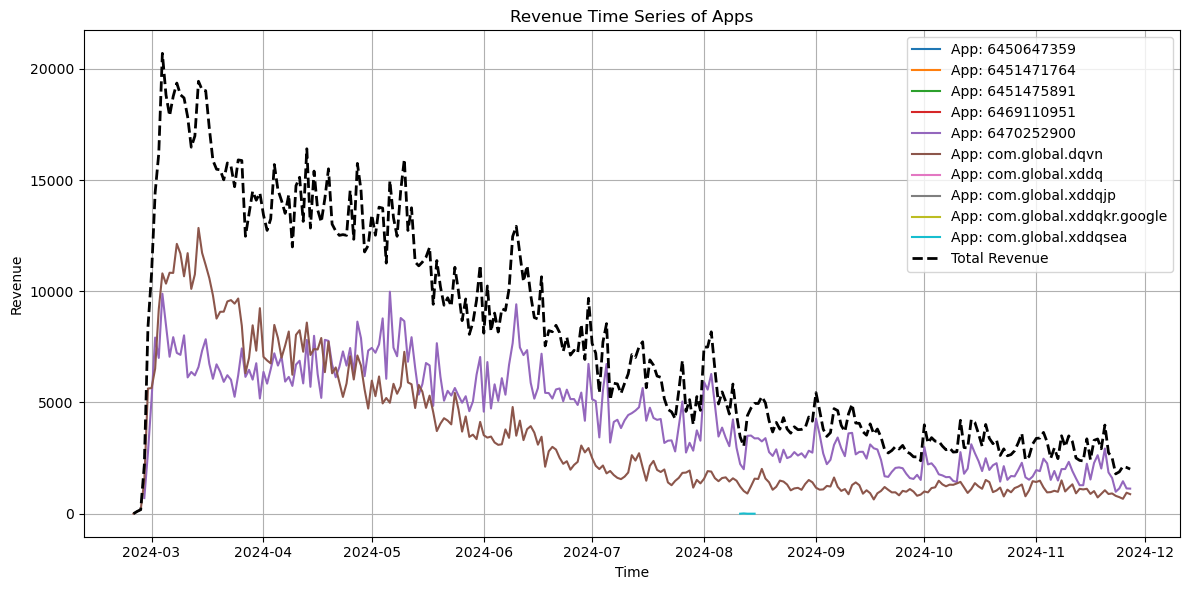

In [626]:
plot_performance_streams_df(
    test_performance_df
)

In [1025]:
# Why Open World Adventure subgenre jumps in revenue hugely 2019 - 2020?

In [1032]:
df_game_revenue_adjusted_with_genre_info[
    df_game_revenue_adjusted_with_genre_info['game_subgenre'] == 'Idle RPG'
].sort_values(by = 2024, ascending = False)

,game_class,game_genre,game_subgenre,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
Unified ID,,,,,,,,,,,,,,
6539d116d2e5a9284e6a76e2,Action & Strategy,RPG,Idle RPG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7601709
64d262a510a3142a25912bd2,Action & Strategy,RPG,Idle RPG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7211842
64a91142f08b1411f1c62ffc,Action & Strategy,RPG,Idle RPG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2826016,2787271
6320fb30ad4adb161582e209,Action & Strategy,RPG,Idle RPG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99753,18178,1919770,2676618
63578bb99d838447746c5887,Action & Strategy,RPG,Idle RPG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,183234,1747840,1753168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6535dfd78636176c51d89db4,Action & Strategy,RPG,Idle RPG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39,NaN
653b30f39c7c3e380cc0b71c,Action & Strategy,RPG,Idle RPG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,796,NaN
654d78f787b2754c24cf45ba,Action & Strategy,RPG,Idle RPG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86,NaN


# Old Stuffs